In [2]:
import numpy as np
import pandas as pd
import h5py
import os
import glob
from datetime import datetime
from datetime import timedelta
from matplotlib import pyplot as plt
import geopandas as gpd
import matplotlib.dates as md
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import warnings
from scipy.interpolate import interp2d
from scipy.interpolate import interp1d
from scipy.interpolate import make_interp_spline
warnings.filterwarnings('ignore')
import scipy.ndimage as ndimage
from matplotlib import cm
from matplotlib.colors import LogNorm
import matplotlib.ticker as ticker
from sklearn import preprocessing
import seaborn as sns
from scipy.stats import pearsonr
from scipy import stats

In [3]:
def simple_read(path):
    with open(path) as f:
        first_line = f.readline()
        header_line = int(first_line[0:-2].split(",")[0])-1
        #all_lines = f.readlines()
    data = pd.read_csv(path, sep=',', skiprows=header_line)
    data.columns = [i.strip() for i in data.columns]
    #date = all_lines[5][0:10].split(',')
    #dt = datetime(int(date[0]), int(date[1]), int(date[2]))

    acc = 0
    boo = False
    for letter in path:
        if letter == '2':
            boo = True
        elif boo and letter == '0':
            acc -= 1
            break
        acc += 1
    #print(path[:acc+4], path[acc+4:acc+6], path[acc+6:acc+8])
    dt = datetime(int(path[acc:acc+4]), int(path[acc+4:acc+6]), int(path[acc+6:acc+8]))
    
    for column in data.keys():
        if 'Time' in column:
            data[column] = dt + pd.to_timedelta(data[column], unit='seconds')
    return data.replace(-999999, np.NaN)

In [4]:
DAY22 = simple_read('C:/Users/taiwoajayi/Documents/Ozone/f(RH)/activate-mrg1_hu25_20220602_R0_L1_20230727T154849.ict')

start_index = np.where(DAY22["Time_Start"] == pd.to_datetime("2022-06-02 12:58:55"))
stop_index = np.where(DAY22["Time_Start"] == pd.to_datetime("2022-06-02 13:10:00"))

DAY22_subset = DAY22[start_index[0][0]:stop_index[0][0]]

# Print the modified subset dataframe
DAY22_subset


,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Static_Air_Temp_THORNHILL,Sc550_submicron_amb_ZIEMBA,Sc550_submicron_ZIEMBA,RH_Sc_submicron_ZIEMBA,Abs532_total_ZIEMBA,Ext532_submicron_amb_ZIEMBA,fRH550_RH20to80_ZIEMBA,SSA_550nm_ZIEMBA,SSA_amb_550nm_ZIEMBA
5981,2022-06-02 12:58:55,2022-06-02 12:58:56,32.901061,-69.417865,115.705,24.050,15.875,13.400,57.15,0.410,16.970,1.435,NaN,NaN
5982,2022-06-02 12:58:56,2022-06-02 12:58:57,32.901505,-69.416658,115.605,24.070,15.550,14.065,57.20,0.430,16.655,1.235,NaN,NaN
5983,2022-06-02 12:58:57,2022-06-02 12:58:58,32.901950,-69.415451,114.775,24.065,16.045,14.460,57.20,-0.245,16.495,1.245,NaN,NaN
5984,2022-06-02 12:58:58,2022-06-02 12:58:59,32.902395,-69.414241,113.025,24.085,16.415,14.395,57.15,-0.905,16.220,1.325,NaN,NaN
5985,2022-06-02 12:58:59,2022-06-02 12:59:00,32.902841,-69.413027,110.485,24.125,16.525,14.565,57.15,-0.175,17.075,1.315,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6641,2022-06-02 13:09:55,2022-06-02 13:09:56,32.856578,-69.176604,3810.860,3.060,NaN,2.070,29.30,-5.270,NaN,NaN,NaN,NaN
6642,2022-06-02 13:09:56,2022-06-02 13:09:57,32.856534,-69.174895,3811.410,3.040,NaN,1.790,29.30,-6.140,NaN,NaN,NaN,NaN
6643,2022-06-02 13:09:57,2022-06-02 13:09:58,32.856492,-69.173186,3812.340,3.005,NaN,1.225,29.30,0.420,NaN,NaN,NaN,NaN
6644,2022-06-02 13:09:58,2022-06-02 13:09:59,32.856451,-69.171477,3813.680,2.985,NaN,1.235,29.30,9.350,NaN,NaN,NaN,NaN


In [5]:
nbins = 20
bins = np.linspace(DAY22_subset.GPS_Altitude_THORNHILL.min(), DAY22_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY22_subset['Bins'] = pd.cut(DAY22_subset['GPS_Altitude_THORNHILL'], bins)
DAY22_subset_median = DAY22_subset.groupby('Bins').median()
DAY22_subset_median

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Static_Air_Temp_THORNHILL,Sc550_submicron_amb_ZIEMBA,Sc550_submicron_ZIEMBA,RH_Sc_submicron_ZIEMBA,Abs532_total_ZIEMBA,Ext532_submicron_amb_ZIEMBA,fRH550_RH20to80_ZIEMBA,SSA_550nm_ZIEMBA,SSA_amb_550nm_ZIEMBA
Bins,,,,,,,,,,,,,,
"(105.985, 291.908]",2022-06-02 12:59:12.000,2022-06-02 12:59:13.000,32.908859,-69.397118,182.2350,23.3200,16.5250,14.5650,56.900,0.3000,17.4750,1.2750,NaN,NaN
"(291.908, 477.83]",2022-06-02 12:59:41.000,2022-06-02 12:59:42.000,32.934998,-69.379643,388.9450,21.6650,16.4250,14.1200,56.100,-0.3300,16.8300,1.4000,NaN,NaN
"(477.83, 663.753]",2022-06-02 13:00:05.000,2022-06-02 13:00:06.000,32.955627,-69.395696,571.9250,20.5650,15.1500,13.3050,54.700,-0.5250,15.1900,1.3450,NaN,NaN
"(663.753, 849.676]",2022-06-02 13:00:27.500,2022-06-02 13:00:28.500,32.955277,-69.423800,763.2650,19.5925,13.1300,10.5825,53.050,-0.3650,13.3775,1.7650,NaN,NaN
"(849.676, 1035.599]",2022-06-02 13:00:49.500,2022-06-02 13:00:50.500,32.936339,-69.440578,944.0275,18.1925,13.6075,10.6725,51.375,0.1450,14.2575,1.4875,NaN,NaN
"(1035.599, 1221.522]",2022-06-02 13:01:12.000,2022-06-02 13:01:13.000,32.911789,-69.433273,1120.2100,17.5450,11.6700,10.5650,50.000,-1.4750,10.7650,1.2250,NaN,NaN
"(1221.522, 1407.444]",2022-06-02 13:01:35.500,2022-06-02 13:01:36.500,32.900627,-69.404055,1331.2700,16.2675,10.2075,9.5825,48.125,-0.5675,9.7675,1.2450,NaN,NaN
"(1407.444, 1593.367]",2022-06-02 13:01:59.500,2022-06-02 13:02:00.500,32.910887,-69.373075,1494.2100,15.1150,10.1500,9.7675,46.750,-0.6525,9.7100,1.0850,NaN,NaN
"(1593.367, 1779.29]",2022-06-02 13:02:22.000,2022-06-02 13:02:23.000,32.936250,-69.364681,1682.6500,13.7200,9.4350,7.7750,45.400,-0.4950,9.2750,1.4650,NaN,NaN


In [6]:
DAY22_subset_25 = DAY22_subset_median - DAY22_subset.groupby('Bins').quantile(.25)
DAY22_subset_25
DAY22_subset_75 = DAY22_subset.groupby('Bins').quantile(.75) - DAY22_subset_median
DAY22_subset_75

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Static_Air_Temp_THORNHILL,Sc550_submicron_amb_ZIEMBA,Sc550_submicron_ZIEMBA,RH_Sc_submicron_ZIEMBA,Abs532_total_ZIEMBA,Ext532_submicron_amb_ZIEMBA,fRH550_RH20to80_ZIEMBA,SSA_550nm_ZIEMBA,SSA_amb_550nm_ZIEMBA
Bins,,,,,,,,,,,,,,
"(105.985, 291.908]",0 days 00:00:08,0 days 00:00:08,0.005096,0.008789,48.51500,0.67000,0.64000,0.57000,0.2000,0.39500,0.65500,0.10500,NaN,NaN
"(291.908, 477.83]",0 days 00:00:06,0 days 00:00:06,0.006425,0.000766,40.48000,0.37000,1.58500,1.88500,0.2000,0.92500,2.46000,0.09000,NaN,NaN
"(477.83, 663.753]",0 days 00:00:05.500000,0 days 00:00:05.500000,0.001940,0.006010,49.47000,0.26000,0.84250,0.56250,0.3750,0.35250,1.21750,0.18250,NaN,NaN
"(663.753, 849.676]",0 days 00:00:05.250000128,0 days 00:00:05.250000128,0.002122,0.006326,38.95250,0.18125,0.39625,3.22750,0.4375,0.48625,1.04500,0.26125,NaN,NaN
"(849.676, 1035.599]",0 days 00:00:05.250000128,0 days 00:00:05.250000128,0.005637,0.001915,40.55375,0.33125,0.71375,1.34500,0.3000,0.31000,0.98375,0.07875,NaN,NaN
"(1035.599, 1221.522]",0 days 00:00:05.500000,0 days 00:00:05.500000,0.005465,0.005521,46.84500,0.18500,0.38500,1.37000,0.2750,0.89500,1.37750,0.27500,NaN,NaN
"(1221.522, 1407.444]",0 days 00:00:05.749999872,0 days 00:00:05.749999872,0.000862,0.008256,30.42500,0.20875,0.42875,0.35375,0.4000,0.61625,1.37125,0.10250,NaN,NaN
"(1407.444, 1593.367]",0 days 00:00:05.749999872,0 days 00:00:05.749999872,0.005764,0.004713,45.85500,0.15125,1.22250,1.04500,0.1500,0.68375,0.89500,0.25375,NaN,NaN
"(1593.367, 1779.29]",0 days 00:00:05,0 days 00:00:05,0.005791,0.000575,46.45000,0.39000,0.68000,1.39500,0.3000,0.43000,0.89000,0.36500,NaN,NaN


Text(0.5, 1.0, '06_02_12:58 - 13:10:00 UTC')

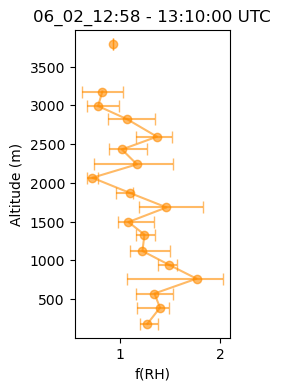

In [7]:
fig, ax = plt.subplots(figsize=(2, 4))
ax.errorbar(DAY22_subset_median['fRH550_RH20to80_ZIEMBA'], DAY22_subset_median['GPS_Altitude_THORNHILL'], xerr=[DAY22_subset_25['fRH550_RH20to80_ZIEMBA'], DAY22_subset_75['fRH550_RH20to80_ZIEMBA']], marker='o', linestyle='-', capsize=4, alpha=.6, color="darkorange", label = '>10nm')
ax.set_xlabel('f(RH)')
ax.set_ylabel('Altitude (m)')
#fig.suptitle('f(RH)', fontsize=16)
ax.set_title('06_02_12:58 - 13:10:00 UTC')

Text(0.5, 1.0, '06_02_12:58 - 13:10:00 UTC')

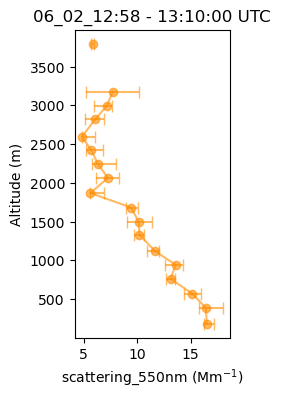

In [8]:
fig, ax = plt.subplots(figsize=(2, 4))
ax.errorbar(DAY22_subset_median['Sc550_submicron_amb_ZIEMBA'], DAY22_subset_median['GPS_Altitude_THORNHILL'], xerr=[DAY22_subset_25['Sc550_submicron_amb_ZIEMBA'], DAY22_subset_75['Sc550_submicron_amb_ZIEMBA']], marker='o', linestyle='-', capsize=4, alpha=.6, color="darkorange", label = '>10nm')
ax.set_xlabel('scattering_550nm (Mm$^{-1}$)')
ax.set_ylabel('Altitude (m)')
#fig.suptitle('f(RH)', fontsize=16)
ax.set_title('06_02_12:58 - 13:10:00 UTC')

Text(0.5, 1.0, '06_02_12:58 - 13:10:00 UTC')

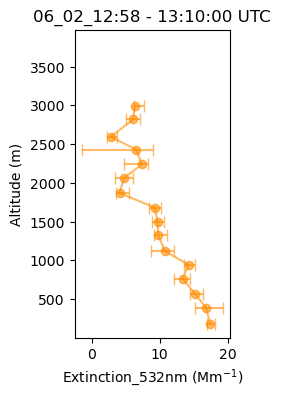

In [9]:
fig, ax = plt.subplots(figsize=(2, 4))
ax.errorbar(DAY22_subset_median['Ext532_submicron_amb_ZIEMBA'], DAY22_subset_median['GPS_Altitude_THORNHILL'], xerr=[DAY22_subset_25['Ext532_submicron_amb_ZIEMBA'], DAY22_subset_75['Ext532_submicron_amb_ZIEMBA']], marker='o', linestyle='-', capsize=4, alpha=.6, color="darkorange", label = '>10nm')
ax.set_xlabel('Extinction_532nm (Mm$^{-1}$)')
ax.set_ylabel('Altitude (m)')
#fig.suptitle('f(RH)', fontsize=16)
ax.set_title('06_02_12:58 - 13:10:00 UTC')

In [10]:
DAY2 = simple_read('C:/Users/taiwoajayi/Documents/Ozone/f(RH)/activate-mrg1_hu25_20220602_R0_L1_20230727T154849.ict')
start_index = np.where(DAY2["Time_Start"] == pd.to_datetime("2022-06-02 13:48:00"))
stop_index = np.where(DAY2["Time_Start"] == pd.to_datetime("2022-06-02 14:11:00"))

DAY2_subset = DAY2[start_index[0][0]:stop_index[0][0]]
DAY2_subset



,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Static_Air_Temp_THORNHILL,Sc550_submicron_amb_ZIEMBA,Sc550_submicron_ZIEMBA,RH_Sc_submicron_ZIEMBA,Abs532_total_ZIEMBA,Ext532_submicron_amb_ZIEMBA,fRH550_RH20to80_ZIEMBA,SSA_550nm_ZIEMBA,SSA_amb_550nm_ZIEMBA
8926,2022-06-02 13:48:00,2022-06-02 13:48:01,32.397719,-65.920473,1896.68,12.265,5.18,3.965,42.10,-0.305,4.77,0.99,NaN,NaN
8927,2022-06-02 13:48:01,2022-06-02 13:48:02,32.397400,-65.918900,1897.28,12.245,5.18,5.820,42.05,-0.800,4.77,0.99,NaN,NaN
8928,2022-06-02 13:48:02,2022-06-02 13:48:03,32.397079,-65.917327,1898.01,12.225,5.98,6.380,42.00,-1.150,4.89,0.82,NaN,NaN
8929,2022-06-02 13:48:03,2022-06-02 13:48:04,32.396758,-65.915754,1898.83,12.215,5.98,5.975,42.00,-0.670,4.89,0.82,NaN,NaN
8930,2022-06-02 13:48:04,2022-06-02 13:48:05,32.396435,-65.914182,1899.75,12.200,8.25,6.920,42.00,0.425,9.38,1.02,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10301,2022-06-02 14:10:55,2022-06-02 14:10:56,32.264343,-65.038703,3176.07,7.140,NaN,1.795,31.20,15.615,NaN,NaN,NaN,NaN
10302,2022-06-02 14:10:56,2022-06-02 14:10:57,32.263327,-65.039317,3180.14,7.125,NaN,2.410,31.20,20.720,NaN,NaN,NaN,NaN
10303,2022-06-02 14:10:57,2022-06-02 14:10:58,32.262289,-65.039886,3184.23,7.125,NaN,2.415,31.10,12.290,NaN,NaN,NaN,NaN
10304,2022-06-02 14:10:58,2022-06-02 14:10:59,32.261232,-65.040413,3188.41,7.100,NaN,2.640,31.00,-2.715,NaN,NaN,NaN,NaN


In [11]:
nbins = 20
bins = np.linspace(DAY2_subset.GPS_Altitude_THORNHILL.min(), DAY2_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY2_subset['Bins'] = pd.cut(DAY2_subset['GPS_Altitude_THORNHILL'], bins)
DAY2_subset_median = DAY2_subset.groupby('Bins').median()
DAY2_subset_median

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Static_Air_Temp_THORNHILL,Sc550_submicron_amb_ZIEMBA,Sc550_submicron_ZIEMBA,RH_Sc_submicron_ZIEMBA,Abs532_total_ZIEMBA,Ext532_submicron_amb_ZIEMBA,fRH550_RH20to80_ZIEMBA,SSA_550nm_ZIEMBA,SSA_amb_550nm_ZIEMBA
Bins,,,,,,,,,,,,,,
"(106.28, 260.607]",2022-06-02 13:58:07.000,2022-06-02 13:58:08.000,32.212884,-65.048915,129.9950,23.7500,15.1550,11.3500,54.200,0.4600,16.3100,1.4800,NaN,NaN
"(260.607, 414.935]",2022-06-02 13:59:23.500,2022-06-02 13:59:24.500,32.243630,-64.982119,312.9625,22.1450,15.3800,11.4050,53.400,0.6250,16.6525,1.4575,NaN,NaN
"(414.935, 569.262]",2022-06-02 13:55:05.000,2022-06-02 13:55:06.000,32.276937,-65.274051,449.9600,20.9950,16.5950,10.9900,51.900,0.5100,17.9750,1.5850,0.88200,0.92400
"(569.262, 723.59]",2022-06-02 14:00:59.500,2022-06-02 14:01:00.500,32.264739,-65.037435,658.1225,19.7700,14.3850,9.4600,50.575,0.3000,14.5375,1.7850,0.85400,0.90575
"(723.59, 877.917]",2022-06-02 14:01:34.500,2022-06-02 14:01:35.500,32.232674,-65.025610,784.5150,18.9700,13.5300,9.2975,49.500,0.2500,14.8225,1.7025,0.82100,0.87350
"(877.917, 1032.245]",2022-06-02 14:02:06.000,2022-06-02 14:02:07.000,32.231287,-64.985946,966.0450,17.9300,11.0950,7.7350,48.300,0.1550,12.4250,1.7400,0.84350,0.87550
"(1032.245, 1186.572]",2022-06-02 14:02:34.500,2022-06-02 14:02:35.500,32.256490,-64.955171,1107.9450,17.2375,9.9025,7.4450,46.950,-0.0675,10.1300,1.5925,0.86850,0.89700
"(1186.572, 1340.9]",2022-06-02 14:03:11.500,2022-06-02 14:03:12.500,32.285203,-64.967662,1259.7850,16.2700,8.3100,6.1125,45.200,-0.0250,8.4300,1.5950,0.84150,0.88000
"(1340.9, 1495.227]",2022-06-02 14:03:46.500,2022-06-02 14:03:47.500,32.287492,-65.008714,1410.3050,15.3575,8.1000,5.7000,43.850,0.1975,8.8650,1.4325,0.81675,0.85200


In [12]:
DAY2_subset_25 = DAY2_subset_median - DAY2_subset.groupby('Bins').quantile(.25)
DAY2_subset_25
DAY2_subset_75 = DAY2_subset.groupby('Bins').quantile(.75) - DAY2_subset_median
DAY2_subset_75

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Static_Air_Temp_THORNHILL,Sc550_submicron_amb_ZIEMBA,Sc550_submicron_ZIEMBA,RH_Sc_submicron_ZIEMBA,Abs532_total_ZIEMBA,Ext532_submicron_amb_ZIEMBA,fRH550_RH20to80_ZIEMBA,SSA_550nm_ZIEMBA,SSA_amb_550nm_ZIEMBA
Bins,,,,,,,,,,,,,,
"(106.28, 260.607]",0 days 00:00:38,0 days 00:00:38,0.011386,0.045676,43.15500,0.09000,0.80000,1.32000,0.200,0.40000,0.98000,0.24500,NaN,NaN
"(260.607, 414.935]",0 days 00:00:15.250000128,0 days 00:00:15.250000128,0.004031,0.007064,36.90000,0.20750,1.00750,1.57625,0.400,0.57375,1.79875,0.22000,NaN,NaN
"(414.935, 569.262]",0 days 00:01:06.500000,0 days 00:01:06.500000,0.014650,0.088544,32.04750,0.08500,1.36750,1.09750,0.225,0.59750,1.49750,0.19750,0.009125,0.005250
"(569.262, 723.59]",0 days 00:00:13.250000128,0 days 00:00:13.250000128,0.046041,0.002170,32.76375,0.18500,1.01750,0.87875,0.600,0.91250,2.93875,0.16250,0.012625,0.007125
"(723.59, 877.917]",0 days 00:00:13.250000128,0 days 00:00:13.250000128,0.083007,0.015434,39.46500,0.14750,1.80250,0.83500,0.300,1.17250,2.27625,0.34875,0.014000,0.008750
"(877.917, 1032.245]",0 days 00:00:09.500000,0 days 00:00:09.500000,0.089212,0.011983,29.57500,0.29250,1.29500,0.82250,0.400,0.89000,0.96500,0.22250,0.004500,0.003000
"(1032.245, 1186.572]",0 days 00:00:11.749999872,0 days 00:00:11.749999872,0.067394,0.006049,36.28750,0.22250,0.43000,1.19375,0.650,0.95250,1.33500,0.33125,0.002500,0.003250
"(1186.572, 1340.9]",0 days 00:00:12.749999872,0 days 00:00:12.749999872,0.012262,0.012110,40.45500,0.19500,0.54750,1.26000,0.600,0.89500,1.85250,0.34500,0.008500,0.006000
"(1340.9, 1495.227]",0 days 00:00:11.250000128,0 days 00:00:11.250000128,0.042959,0.012559,35.74500,0.09625,0.49125,0.84625,0.350,1.21375,1.47625,0.34250,0.011625,0.014250


Text(0.5, 1.0, '06_02_13:48 - 14:11 UTC')

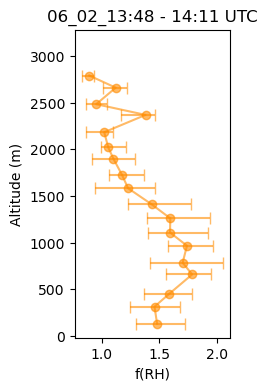

In [13]:
fig, ax = plt.subplots(figsize=(2, 4))
ax.errorbar(DAY2_subset_median['fRH550_RH20to80_ZIEMBA'], DAY2_subset_median['GPS_Altitude_THORNHILL'], xerr=[DAY2_subset_25['fRH550_RH20to80_ZIEMBA'], DAY2_subset_75['fRH550_RH20to80_ZIEMBA']], marker='o', linestyle='-', capsize=4, alpha=.6, color="darkorange", label = '>10nm')
ax.set_xlabel('f(RH)')
ax.set_ylabel('Altitude (m)')
#fig.suptitle('f(RH)', fontsize=16)
ax.set_title('06_02_13:48 - 14:11 UTC')

Text(0.5, 1.0, '06_02_13:48 - 14:11 UTC')

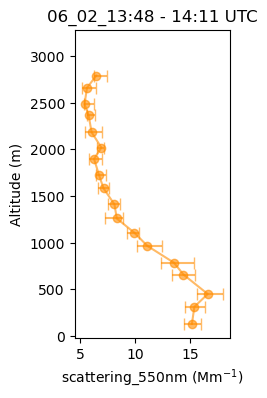

In [14]:
fig, ax = plt.subplots(figsize=(2, 4))
ax.errorbar(DAY2_subset_median['Sc550_submicron_amb_ZIEMBA'], DAY2_subset_median['GPS_Altitude_THORNHILL'], xerr=[DAY2_subset_25['Sc550_submicron_amb_ZIEMBA'], DAY2_subset_75['Sc550_submicron_amb_ZIEMBA']], marker='o', linestyle='-', capsize=4, alpha=.6, color="darkorange", label = '>10nm')
ax.set_xlabel('scattering_550nm (Mm$^{-1}$)')
ax.set_ylabel('Altitude (m)')
#fig.suptitle('f(RH)', fontsize=16)
ax.set_title('06_02_13:48 - 14:11 UTC')

Text(0.5, 1.0, '06_02_13:48 - 14:11 UTC')

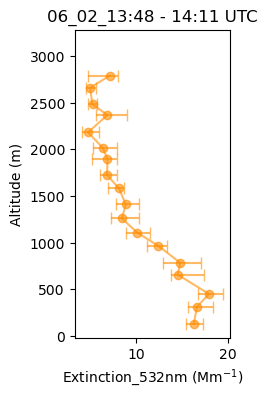

In [15]:
fig, ax = plt.subplots(figsize=(2, 4))
ax.errorbar(DAY2_subset_median['Ext532_submicron_amb_ZIEMBA'], DAY2_subset_median['GPS_Altitude_THORNHILL'], xerr=[DAY2_subset_25['Ext532_submicron_amb_ZIEMBA'], DAY2_subset_75['Ext532_submicron_amb_ZIEMBA']], marker='o', linestyle='-', capsize=4, alpha=.6, color="darkorange", label = '>10nm')
ax.set_xlabel('Extinction_532nm (Mm$^{-1}$)')
ax.set_ylabel('Altitude (m)')
#fig.suptitle('f(RH)', fontsize=16)
ax.set_title('06_02_13:48 - 14:11 UTC')

In [16]:
DAY2b = simple_read('C:/Users/taiwoajayi/Documents/Ozone/f(RH)/activate-mrg1_hu25_20220602_R0_L2_20230727T154849.ict')
start_index = np.where(DAY2b["Time_Start"]==pd.to_datetime("2022-06-02 18:36:00"))
stop_index = np.where(DAY2b["Time_Start"]==pd.to_datetime("2022-06-02 18:53:00"))
DAY2b_subset = DAY2b[start_index[0][0]:stop_index[0][0]]
DAY2b_subset = DAY2b_subset.replace(-888888, 0)
DAY2b_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Static_Air_Temp_THORNHILL,Sc550_submicron_amb_ZIEMBA,Sc550_submicron_ZIEMBA,RH_Sc_submicron_ZIEMBA,Abs532_total_ZIEMBA,Ext532_submicron_amb_ZIEMBA,fRH550_RH20to80_ZIEMBA,SSA_550nm_ZIEMBA,SSA_amb_550nm_ZIEMBA
9180,2022-06-02 18:36:00,2022-06-02 18:36:01,32.312301,-65.009805,191.225,23.290,13.930,11.495,53.0,0.465,15.040,1.330,NaN,NaN
9181,2022-06-02 18:36:01,2022-06-02 18:36:02,32.312336,-65.010962,193.480,23.280,16.625,10.000,53.1,0.815,18.195,1.945,NaN,NaN
9182,2022-06-02 18:36:02,2022-06-02 18:36:03,32.312332,-65.012116,195.600,23.265,17.740,10.070,53.2,0.505,19.045,2.065,NaN,NaN
9183,2022-06-02 18:36:03,2022-06-02 18:36:04,32.312294,-65.013268,197.010,23.245,16.210,11.740,53.2,0.080,17.035,1.530,NaN,NaN
9184,2022-06-02 18:36:04,2022-06-02 18:36:05,32.312221,-65.014415,197.440,23.215,16.310,12.590,53.2,0.455,17.520,1.390,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10195,2022-06-02 18:52:55,2022-06-02 18:52:56,32.205808,-64.977280,3678.610,4.190,NaN,3.700,31.4,7.235,NaN,NaN,NaN,NaN
10196,2022-06-02 18:52:56,2022-06-02 18:52:57,32.205215,-64.976028,3684.900,4.180,NaN,3.385,31.4,9.280,NaN,NaN,NaN,NaN
10197,2022-06-02 18:52:57,2022-06-02 18:52:58,32.204648,-64.974760,3691.340,4.220,NaN,3.170,31.4,-1.860,NaN,NaN,NaN,NaN
10198,2022-06-02 18:52:58,2022-06-02 18:52:59,32.204104,-64.973478,3697.790,4.295,NaN,2.195,31.4,-12.285,NaN,NaN,NaN,NaN


In [17]:
nbins = 20
bins = np.linspace(DAY2b_subset.GPS_Altitude_THORNHILL.min(), DAY2b_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY2b_subset['Bins'] = pd.cut(DAY2b_subset['GPS_Altitude_THORNHILL'], bins)
DAY2b_subset_median = DAY2b_subset.groupby('Bins').median()
DAY2b_subset_median

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Static_Air_Temp_THORNHILL,Sc550_submicron_amb_ZIEMBA,Sc550_submicron_ZIEMBA,RH_Sc_submicron_ZIEMBA,Abs532_total_ZIEMBA,Ext532_submicron_amb_ZIEMBA,fRH550_RH20to80_ZIEMBA,SSA_550nm_ZIEMBA,SSA_amb_550nm_ZIEMBA
Bins,,,,,,,,,,,,,,
"(132.5, 311.083]",2022-06-02 18:36:45.500,2022-06-02 18:36:46.500,32.282614,-65.035667,191.1225,23.2875,13.3475,10.8225,53.600,0.4850,14.450,1.4025,NaN,NaN
"(311.083, 489.666]",2022-06-02 18:38:01.500,2022-06-02 18:38:02.500,32.240532,-64.982618,384.2900,22.2500,9.0100,7.8325,51.150,0.2450,9.330,1.4525,0.88150,0.90000
"(489.666, 668.249]",2022-06-02 18:39:05.000,2022-06-02 18:39:06.000,32.290858,-64.989390,561.4700,20.9700,9.2850,8.6200,49.000,-0.0800,10.140,1.1600,0.88700,0.90375
"(668.249, 846.832]",2022-06-02 18:40:07.000,2022-06-02 18:40:08.000,32.258643,-65.021762,753.5350,19.7200,8.0450,6.7400,47.300,-0.0400,8.340,1.4350,NaN,NaN
"(846.832, 1025.415]",2022-06-02 18:41:01.500,2022-06-02 18:41:02.500,32.250738,-64.962283,940.4200,18.5050,7.6450,6.6125,46.100,0.1425,8.210,1.2775,NaN,NaN
"(1025.415, 1203.998]",2022-06-02 18:41:52.500,2022-06-02 18:41:53.500,32.299232,-64.954250,1111.9950,17.6525,7.4850,6.5125,45.200,-0.2950,7.365,1.3950,NaN,NaN
"(1203.998, 1382.581]",2022-06-02 18:42:45.500,2022-06-02 18:42:46.500,32.290507,-65.005753,1271.8950,16.8150,6.5700,5.5925,43.925,0.0275,6.785,0.9600,NaN,NaN
"(1382.581, 1561.164]",2022-06-02 18:43:40.500,2022-06-02 18:43:41.500,32.247731,-64.973601,1479.7500,15.4700,6.4250,4.7000,42.400,-0.2900,5.760,1.1700,NaN,NaN
"(1561.164, 1739.747]",2022-06-02 18:44:32.000,2022-06-02 18:44:33.000,32.272387,-64.918661,1659.9700,15.2200,6.2700,4.8800,41.000,-1.1950,5.125,1.0900,NaN,NaN


In [18]:
DAY2b_subset_25 = DAY2b_subset_median - DAY2b_subset.groupby('Bins').quantile(.25)
DAY2b_subset_25
DAY2b_subset_75 = DAY2b_subset.groupby('Bins').quantile(.75) - DAY2b_subset_median
DAY2b_subset_75

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Static_Air_Temp_THORNHILL,Sc550_submicron_amb_ZIEMBA,Sc550_submicron_ZIEMBA,RH_Sc_submicron_ZIEMBA,Abs532_total_ZIEMBA,Ext532_submicron_amb_ZIEMBA,fRH550_RH20to80_ZIEMBA,SSA_550nm_ZIEMBA,SSA_amb_550nm_ZIEMBA
Bins,,,,,,,,,,,,,,
"(132.5, 311.083]",0 days 00:00:22.250000128,0 days 00:00:22.250000128,0.021885,0.008480,43.36750,0.30125,1.19375,0.90000,0.1000,0.59000,1.54875,0.17625,NaN,NaN
"(311.083, 489.666]",0 days 00:00:15.250000128,0 days 00:00:15.250000128,0.012638,0.012445,42.35625,0.23875,0.62250,0.87750,1.4250,2.03625,2.39125,0.12000,0.005000,0.0040
"(489.666, 668.249]",0 days 00:00:16,0 days 00:00:16,0.003499,0.014844,53.97500,0.15500,1.05500,0.67500,0.3000,0.42500,1.04000,0.41500,0.000250,0.0005
"(668.249, 846.832]",0 days 00:00:14.500000,0 days 00:00:14.500000,0.013503,0.012284,48.51000,0.38500,0.52000,0.87750,0.3750,1.55750,2.23500,0.16500,NaN,NaN
"(846.832, 1025.415]",0 days 00:00:12.250000128,0 days 00:00:12.250000128,0.009892,0.010450,29.91000,0.47250,0.71250,0.88500,0.1000,0.57875,0.70500,0.11875,NaN,NaN
"(1025.415, 1203.998]",0 days 00:00:12.749999872,0 days 00:00:12.749999872,0.007259,0.007432,41.51750,0.14375,0.39500,0.68750,0.3000,0.54375,0.74250,0.18250,NaN,NaN
"(1203.998, 1382.581]",0 days 00:00:13.250000128,0 days 00:00:13.250000128,0.011389,0.007551,54.45250,0.31750,0.65000,1.18750,0.2750,0.29625,0.79250,0.27000,NaN,NaN
"(1382.581, 1561.164]",0 days 00:00:13.749999872,0 days 00:00:13.749999872,0.003726,0.018331,40.32000,0.58625,0.24500,0.42125,0.4625,0.64250,1.23000,0.50000,NaN,NaN
"(1561.164, 1739.747]",0 days 00:00:11.500000,0 days 00:00:11.500000,0.011928,0.004221,46.63500,0.08750,0.77000,1.06250,0.3000,2.65500,4.24250,0.12500,NaN,NaN


Text(0.5, 1.0, '06_02_18:36 - 18:53 UTC')

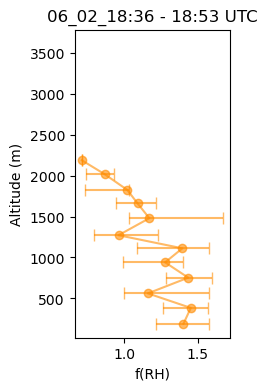

In [19]:
fig, ax = plt.subplots(figsize=(2, 4))
ax.errorbar(DAY2b_subset_median['fRH550_RH20to80_ZIEMBA'], DAY2b_subset_median['GPS_Altitude_THORNHILL'], xerr=[DAY2b_subset_25['fRH550_RH20to80_ZIEMBA'], DAY2b_subset_75['fRH550_RH20to80_ZIEMBA']], marker='o', linestyle='-', capsize=4, alpha=.6, color="darkorange", label = '>10nm')
ax.set_xlabel('f(RH)')
ax.set_ylabel('Altitude (m)')
#fig.suptitle('f(RH)', fontsize=16)
ax.set_title('06_02_18:36 - 18:53 UTC')

Text(0.5, 1.0, '06_02_18:36 - 18:53 UTC')

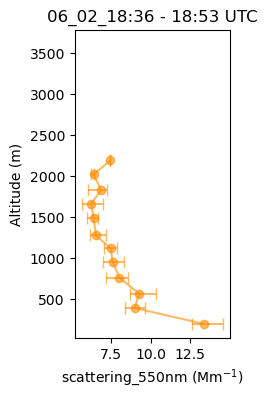

In [20]:
fig, ax = plt.subplots(figsize=(2, 4))
ax.errorbar(DAY2b_subset_median['Sc550_submicron_amb_ZIEMBA'], DAY2b_subset_median['GPS_Altitude_THORNHILL'], xerr=[DAY2b_subset_25['Sc550_submicron_amb_ZIEMBA'], DAY2b_subset_75['Sc550_submicron_amb_ZIEMBA']], marker='o', linestyle='-', capsize=4, alpha=.6, color="darkorange", label = '>10nm')
ax.set_xlabel('scattering_550nm (Mm$^{-1}$)')
ax.set_ylabel('Altitude (m)')
#fig.suptitle('f(RH)', fontsize=16)
ax.set_title('06_02_18:36 - 18:53 UTC')

Text(0.5, 1.0, '06_02_18:36 - 18:53 UTC')

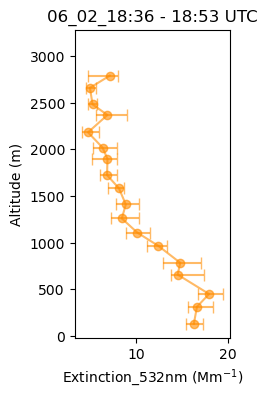

In [21]:
fig, ax = plt.subplots(figsize=(2, 4))
ax.errorbar(DAY2_subset_median['Ext532_submicron_amb_ZIEMBA'], DAY2_subset_median['GPS_Altitude_THORNHILL'], xerr=[DAY2_subset_25['Ext532_submicron_amb_ZIEMBA'], DAY2_subset_75['Ext532_submicron_amb_ZIEMBA']], marker='o', linestyle='-', capsize=4, alpha=.6, color="darkorange", label = '>10nm')
ax.set_xlabel('Extinction_532nm (Mm$^{-1}$)')
ax.set_ylabel('Altitude (m)')
#fig.suptitle('f(RH)', fontsize=16)
ax.set_title('06_02_18:36 - 18:53 UTC')

In [22]:
DAY3 = simple_read('C:/Users/taiwoajayi/Documents/Ozone/f(RH)/activate-mrg1_hu25_20220603_R0_20230727T154850.ict')
start_index= np.where(DAY3["Time_Start"]==pd.to_datetime("2022-06-03 13:30:00"))
stop_index= np.where(DAY3["Time_Start"]==pd.to_datetime("2022-06-03 15:00:00"))
    
DAY3_subset = DAY3[start_index[0][0]:stop_index[0][0]]
DAY3_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Static_Air_Temp_THORNHILL,Sc550_submicron_amb_ZIEMBA,Sc550_submicron_ZIEMBA,RH_Sc_submicron_ZIEMBA,Abs532_total_ZIEMBA,Ext532_submicron_amb_ZIEMBA,fRH550_RH20to80_ZIEMBA,SSA_550nm_ZIEMBA,SSA_amb_550nm_ZIEMBA
2467,2022-06-03 13:30:00,2022-06-03 13:30:01,33.872982,-67.052387,2858.90,8.545,NaN,3.390,35.95,1.235,NaN,NaN,NaN,NaN
2468,2022-06-03 13:30:01,2022-06-03 13:30:02,33.872534,-67.053832,2861.55,8.525,NaN,2.665,35.90,0.690,NaN,NaN,NaN,NaN
2469,2022-06-03 13:30:02,2022-06-03 13:30:03,33.872086,-67.055272,2863.82,8.495,NaN,2.950,35.90,-0.605,NaN,NaN,NaN,NaN
2470,2022-06-03 13:30:03,2022-06-03 13:30:04,33.871638,-67.056704,2865.57,8.480,NaN,3.125,35.90,-0.900,NaN,NaN,NaN,NaN
2471,2022-06-03 13:30:04,2022-06-03 13:30:05,33.871187,-67.058127,2866.59,8.455,NaN,3.060,35.80,-0.995,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7862,2022-06-03 14:59:55,2022-06-03 14:59:56,32.712767,-65.244314,2413.61,10.995,NaN,1.240,36.50,-0.040,NaN,NaN,NaN,NaN
7863,2022-06-03 14:59:56,2022-06-03 14:59:57,32.712103,-65.243151,2408.15,11.045,NaN,0.930,36.50,-0.020,NaN,NaN,NaN,NaN
7864,2022-06-03 14:59:57,2022-06-03 14:59:58,32.711441,-65.241989,2402.02,11.090,NaN,0.140,36.50,1.420,NaN,NaN,NaN,NaN
7865,2022-06-03 14:59:58,2022-06-03 14:59:59,32.710779,-65.240827,2395.43,11.130,NaN,0.165,36.50,1.855,NaN,NaN,NaN,NaN


In [23]:
nbins = 20
bins = np.linspace(DAY3_subset.GPS_Altitude_THORNHILL.min(), DAY3_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY3_subset['Bins'] = pd.cut(DAY3_subset['GPS_Altitude_THORNHILL'], bins)
DAY3_subset_median = DAY3_subset.groupby('Bins').median()
DAY3_subset_median

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Static_Air_Temp_THORNHILL,Sc550_submicron_amb_ZIEMBA,Sc550_submicron_ZIEMBA,RH_Sc_submicron_ZIEMBA,Abs532_total_ZIEMBA,Ext532_submicron_amb_ZIEMBA,fRH550_RH20to80_ZIEMBA,SSA_550nm_ZIEMBA,SSA_amb_550nm_ZIEMBA
Bins,,,,,,,,,,,,,,
"(94.825, 370.151]",2022-06-03 13:49:57.000,2022-06-03 13:49:58.000,34.115487,-67.206434,131.235,23.2500,13.2000,10.9650,56.4,0.5900,14.3250,1.3100,0.850500,0.87350
"(370.151, 645.478]",2022-06-03 14:09:49.000,2022-06-03 14:09:50.000,34.173190,-67.281351,498.600,20.3350,16.6150,12.2050,52.8,0.5600,18.7700,1.5350,0.902500,0.93300
"(645.478, 920.804]",2022-06-03 14:22:42.000,2022-06-03 14:22:43.000,34.202326,-67.234070,863.570,18.5850,11.7500,9.9650,46.6,0.1700,12.2800,1.4400,0.881250,0.90493
"(920.804, 1196.13]",2022-06-03 14:18:42.500,2022-06-03 14:18:43.500,34.026322,-67.536288,936.840,18.2500,10.3750,9.3275,46.6,0.3300,11.2150,1.3775,0.876000,0.89200
"(1196.13, 1471.456]",2022-06-03 14:25:43.000,2022-06-03 14:25:44.000,34.283647,-67.030360,1327.480,16.8050,6.8000,5.6400,44.1,0.6400,7.0150,1.1800,0.739250,0.79150
"(1471.456, 1746.782]",2022-06-03 14:29:51.000,2022-06-03 14:29:52.000,34.175179,-67.254158,1555.080,16.2850,7.4375,7.4500,37.9,0.2750,7.9650,1.0700,0.772000,0.82500
"(1746.782, 2022.109]",2022-06-03 13:32:08.500,2022-06-03 13:32:09.500,33.812818,-67.042618,1886.845,13.9175,8.1700,7.8700,35.4,0.9250,9.6675,1.1275,0.890000,0.89050
"(2022.109, 2297.435]",2022-06-03 13:31:37.500,2022-06-03 13:31:38.500,33.799565,-67.081631,2149.580,12.2450,9.2200,8.6675,34.2,0.9225,10.9500,1.2500,0.767750,0.77275
"(2297.435, 2572.761]",2022-06-03 14:34:40.500,2022-06-03 14:34:41.500,33.820365,-67.095526,2450.625,10.4600,8.1350,6.4100,36.2,0.2125,8.7150,1.1600,0.832000,0.86250


In [24]:
DAY3_subset_25 = DAY3_subset_median - DAY3_subset.groupby('Bins').quantile(.25)
DAY3_subset_25
DAY3_subset_75 = DAY3_subset.groupby('Bins').quantile(.75) - DAY3_subset_median
DAY3_subset_75

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Static_Air_Temp_THORNHILL,Sc550_submicron_amb_ZIEMBA,Sc550_submicron_ZIEMBA,RH_Sc_submicron_ZIEMBA,Abs532_total_ZIEMBA,Ext532_submicron_amb_ZIEMBA,fRH550_RH20to80_ZIEMBA,SSA_550nm_ZIEMBA,SSA_amb_550nm_ZIEMBA
Bins,,,,,,,,,,,,,,
"(94.825, 370.151]",0 days 00:07:29,0 days 00:07:29,0.115971,0.077436,113.6500,0.16000,0.89250,0.86500,0.30,0.61000,1.28500,0.15000,0.058375,0.051500
"(370.151, 645.478]",0 days 00:02:42.500000,0 days 00:02:42.500000,0.080624,0.190818,8.7725,0.17000,6.14000,2.88000,0.20,1.91000,7.14750,0.20250,0.017750,0.016250
"(645.478, 920.804]",0 days 00:01:15.500000,0 days 00:01:15.500000,0.059937,0.094632,43.5000,0.73750,3.63750,1.89000,1.30,1.77750,4.29500,0.23500,0.024875,0.024070
"(920.804, 1196.13]",0 days 00:02:38.250000128,0 days 00:02:38.250000128,0.101843,0.208143,54.4625,0.22500,2.44125,2.02500,0.60,1.76000,2.71500,0.28250,0.023750,0.030317
"(1196.13, 1471.456]",0 days 00:00:22.500000,0 days 00:00:22.500000,0.010911,0.025582,54.5850,0.61750,0.68500,0.96500,1.45,1.10250,1.31000,0.10000,0.048125,0.031375
"(1471.456, 1746.782]",0 days 00:01:57,0 days 00:01:57,0.085818,0.140580,12.2200,0.22500,1.24250,1.71500,0.70,1.04500,1.63500,0.22625,0.116500,0.062500
"(1746.782, 2022.109]",0 days 01:01:47.250000128,0 days 01:01:47.250000128,0.207986,0.016846,69.3600,0.44625,1.81500,1.80750,1.40,1.60250,2.75250,0.16375,0.003000,0.004875
"(2022.109, 2297.435]",0 days 01:02:40.250000128,0 days 01:02:40.250000128,0.204335,0.016025,65.3625,0.31625,1.00000,1.34750,2.30,2.12750,2.26500,0.23500,0.038000,0.041875
"(2297.435, 2572.761]",0 days 00:24:57.250000128,0 days 00:24:57.250000128,0.165831,1.830987,63.3725,0.45375,1.25250,2.16375,0.10,0.76000,1.28250,0.14500,0.015125,0.006875


Text(0.5, 1.0, '06_03')

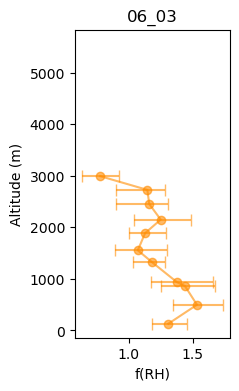

In [25]:
fig, ax = plt.subplots(figsize=(2, 4))
ax.errorbar(DAY3_subset_median['fRH550_RH20to80_ZIEMBA'], DAY3_subset_median['GPS_Altitude_THORNHILL'], xerr=[DAY3_subset_25['fRH550_RH20to80_ZIEMBA'], DAY3_subset_75['fRH550_RH20to80_ZIEMBA']], marker='o', linestyle='-', capsize=4, alpha=.6, color="darkorange", label = '>10nm')
ax.set_xlabel('f(RH)')
ax.set_ylabel('Altitude (m)')
#fig.suptitle('f(RH)', fontsize=16)
plt.title('06_03')

Text(0.5, 1.0, '06_03')

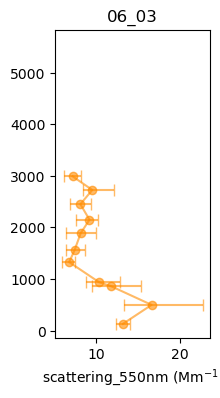

In [26]:
fig, ax = plt.subplots(figsize=(2, 4))
ax.errorbar(DAY3_subset_median['Sc550_submicron_amb_ZIEMBA'], DAY3_subset_median['GPS_Altitude_THORNHILL'], xerr=[DAY3_subset_25['Sc550_submicron_amb_ZIEMBA'], DAY3_subset_75['Sc550_submicron_amb_ZIEMBA']], marker='o', linestyle='-', capsize=4, alpha=.6, color="darkorange", label = '>10nm')
ax.set_xlabel('scattering_550nm (Mm$^{-1}$)')
plt.title('06_03')

Text(0.5, 1.0, '06_03')

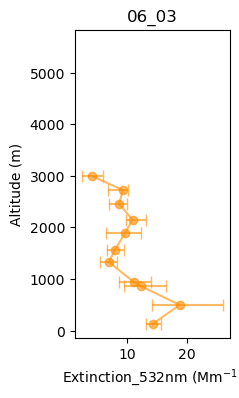

In [27]:
fig, ax = plt.subplots(figsize=(2, 4))
ax.errorbar(DAY3_subset_median['Ext532_submicron_amb_ZIEMBA'], DAY3_subset_median['GPS_Altitude_THORNHILL'], xerr=[DAY3_subset_25['Ext532_submicron_amb_ZIEMBA'], DAY3_subset_75['Ext532_submicron_amb_ZIEMBA']], marker='o', linestyle='-', capsize=4, alpha=.6, color="darkorange", label = '>10nm')
ax.set_xlabel('Extinction_532nm (Mm$^{-1}$)')
ax.set_ylabel('Altitude (m)')
#fig.suptitle('f(RH)', fontsize=16)
plt.title('06_03')

In [28]:
DAY7 = simple_read('C:/Users/taiwoajayi/Documents/Ozone/f(RH)/activate-mrg1_hu25_20220607_R0_L1_20230727T154850.ict')
start_index = np.where(DAY7["Time_Start"]==pd.to_datetime("2022-06-07 14:32:00"))
stop_index = np.where(DAY7["Time_Start"]==pd.to_datetime("2022-06-07 14:47:00"))
    
DAY7_subset =DAY7[start_index[0][0]:stop_index[0][0]]
DAY7_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Static_Air_Temp_THORNHILL,Sc550_submicron_amb_ZIEMBA,Sc550_submicron_ZIEMBA,RH_Sc_submicron_ZIEMBA,Abs532_total_ZIEMBA,Ext532_submicron_amb_ZIEMBA,fRH550_RH20to80_ZIEMBA,SSA_550nm_ZIEMBA,SSA_amb_550nm_ZIEMBA
10397,2022-06-07 14:32:00,2022-06-07 14:32:01,32.250498,-64.999220,127.595,21.705,22.625,21.160,44.75,0.630,23.725,1.245,NaN,NaN
10398,2022-06-07 14:32:01,2022-06-07 14:32:02,32.249883,-64.998233,126.585,21.705,24.015,21.545,44.80,0.585,25.105,1.395,NaN,NaN
10399,2022-06-07 14:32:02,2022-06-07 14:32:03,32.249267,-64.997244,125.870,21.700,23.895,20.920,44.80,0.200,24.600,1.520,NaN,NaN
10400,2022-06-07 14:32:03,2022-06-07 14:32:04,32.248648,-64.996254,125.955,21.735,21.175,18.410,44.75,0.150,21.780,1.535,NaN,NaN
10401,2022-06-07 14:32:04,2022-06-07 14:32:05,32.248027,-64.995263,126.990,21.755,21.990,19.490,44.75,0.395,22.860,1.445,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11292,2022-06-07 14:46:55,2022-06-07 14:46:56,32.255021,-64.999573,2800.660,9.430,NaN,0.090,28.85,-0.165,NaN,NaN,NaN,NaN
11293,2022-06-07 14:46:56,2022-06-07 14:46:57,32.255098,-64.998248,2805.770,9.405,NaN,1.925,28.85,0.090,NaN,NaN,NaN,NaN
11294,2022-06-07 14:46:57,2022-06-07 14:46:58,32.255152,-64.996919,2810.920,9.380,NaN,1.775,28.90,0.025,NaN,NaN,NaN,NaN
11295,2022-06-07 14:46:58,2022-06-07 14:46:59,32.255184,-64.995588,2816.140,9.355,NaN,0.805,28.90,0.370,NaN,NaN,NaN,NaN


In [29]:
nbins = 20
bins = np.linspace(DAY7_subset.GPS_Altitude_THORNHILL.min(), DAY7_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY7_subset['Bins'] = pd.cut(DAY7_subset['GPS_Altitude_THORNHILL'], bins)
DAY7_subset_median = DAY7_subset.groupby('Bins').median()
DAY7_subset_median

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Static_Air_Temp_THORNHILL,Sc550_submicron_amb_ZIEMBA,Sc550_submicron_ZIEMBA,RH_Sc_submicron_ZIEMBA,Abs532_total_ZIEMBA,Ext532_submicron_amb_ZIEMBA,fRH550_RH20to80_ZIEMBA,SSA_550nm_ZIEMBA,SSA_amb_550nm_ZIEMBA
Bins,,,,,,,,,,,,,,
"(125.87, 260.648]",2022-06-07 14:32:27.000,2022-06-07 14:32:28.000,32.229906,-64.976511,187.9700,21.1850,23.0800,20.3400,44.80,0.4300,24.3800,1.4300,NaN,NaN
"(260.648, 395.426]",2022-06-07 14:33:22.500,2022-06-07 14:33:23.500,32.182262,-65.000790,320.0050,19.9875,24.2925,21.1650,44.60,0.3800,25.4375,1.4325,NaN,NaN
"(395.426, 530.204]",2022-06-07 14:34:19.000,2022-06-07 14:34:20.000,32.207365,-65.046934,461.4850,18.5900,25.2450,20.5450,44.20,0.3700,26.4550,1.4600,NaN,NaN
"(530.204, 664.982]",2022-06-07 14:35:16.500,2022-06-07 14:35:17.500,32.234627,-65.007191,594.3025,17.2975,28.4100,22.3625,44.00,0.2175,29.6350,1.4275,NaN,NaN
"(664.982, 799.76]",2022-06-07 14:36:14.500,2022-06-07 14:36:15.500,32.188964,-64.983852,732.7375,16.1475,27.6550,21.0500,43.70,0.3200,28.6050,1.4650,NaN,NaN
"(799.76, 934.538]",2022-06-07 14:37:10.000,2022-06-07 14:37:11.000,32.176238,-65.041720,867.8700,15.3600,20.4750,16.2900,42.40,0.2950,21.8050,1.5500,NaN,NaN
"(934.538, 1069.316]",2022-06-07 14:38:02.000,2022-06-07 14:38:03.000,32.220114,-65.063618,994.2450,14.6450,17.3100,14.2400,40.70,0.2600,18.1100,1.5400,NaN,NaN
"(1069.316, 1204.094]",2022-06-07 14:38:51.000,2022-06-07 14:38:52.000,32.252250,-65.031225,1133.5100,14.1850,21.4150,15.7850,40.00,0.3250,22.6850,1.6350,NaN,NaN
"(1204.094, 1338.872]",2022-06-07 14:39:37.000,2022-06-07 14:39:38.000,32.232720,-64.985893,1270.7400,13.7950,15.3450,12.8650,39.70,-0.1100,15.8750,1.5350,NaN,NaN


In [30]:
DAY7_subset_25 = DAY7_subset_median - DAY7_subset.groupby('Bins').quantile(.25)
DAY7_subset_25
DAY7_subset_75 = DAY7_subset.groupby('Bins').quantile(.75) - DAY7_subset_median
DAY7_subset_75

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Static_Air_Temp_THORNHILL,Sc550_submicron_amb_ZIEMBA,Sc550_submicron_ZIEMBA,RH_Sc_submicron_ZIEMBA,Abs532_total_ZIEMBA,Ext532_submicron_amb_ZIEMBA,fRH550_RH20to80_ZIEMBA,SSA_550nm_ZIEMBA,SSA_amb_550nm_ZIEMBA
Bins,,,,,,,,,,,,,,
"(125.87, 260.648]",0 days 00:00:13,0 days 00:00:13,0.011336,0.003252,31.67000,0.18000,1.10000,0.93000,0.0000,0.33500,0.92000,0.1050,NaN,NaN
"(260.648, 395.426]",0 days 00:00:14.250000128,0 days 00:00:14.250000128,0.005641,0.015637,29.24875,0.34250,0.84000,0.76000,0.1000,0.35625,0.78625,0.1500,NaN,NaN
"(395.426, 530.204]",0 days 00:00:13.500000,0 days 00:00:13.500000,0.012655,0.004133,30.89250,0.36750,1.21500,0.98250,0.2000,0.29000,1.10750,0.0975,NaN,NaN
"(530.204, 664.982]",0 days 00:00:14.749999872,0 days 00:00:14.749999872,0.002633,0.015085,37.98625,0.32875,1.08625,1.04375,0.0250,0.58375,1.28500,0.1350,NaN,NaN
"(664.982, 799.76]",0 days 00:00:13.749999872,0 days 00:00:13.749999872,0.013848,0.003731,33.29125,0.22625,2.58375,0.95375,0.2000,0.56250,2.51625,0.1000,NaN,NaN
"(799.76, 934.538]",0 days 00:00:13.500000,0 days 00:00:13.500000,0.009012,0.014638,31.83750,0.19250,1.83750,1.07500,0.4750,0.87000,2.24250,0.1275,NaN,NaN
"(934.538, 1069.316]",0 days 00:00:12,0 days 00:00:12,0.010999,0.002238,44.29500,0.41000,0.91000,0.96000,0.3000,0.47500,1.04500,0.1650,NaN,NaN
"(1069.316, 1204.094]",0 days 00:00:12,0 days 00:00:12,0.001751,0.014105,35.63000,0.23000,1.84000,1.76000,0.0000,0.39000,1.58500,0.1950,NaN,NaN
"(1204.094, 1338.872]",0 days 00:00:10.500000,0 days 00:00:10.500000,0.009505,0.002794,32.42000,0.15500,3.16250,2.48250,0.2000,0.83750,2.77500,0.1725,NaN,NaN


Text(0.5, 1.0, '06_07_14:32 -14:47 UTC')

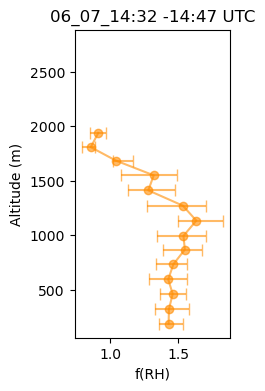

In [31]:
fig, ax = plt.subplots(figsize=(2, 4))
ax.errorbar(DAY7_subset_median['fRH550_RH20to80_ZIEMBA'], DAY7_subset_median['GPS_Altitude_THORNHILL'], xerr=[DAY7_subset_25['fRH550_RH20to80_ZIEMBA'], DAY7_subset_75['fRH550_RH20to80_ZIEMBA']], marker='o', linestyle='-', capsize=4, alpha=.6, color="darkorange", label = '>10nm')
ax.set_xlabel('f(RH)')
ax.set_ylabel('Altitude (m)')
#fig.suptitle('f(RH)', fontsize=16)
ax.set_title('06_07_14:32 -14:47 UTC')

Text(0.5, 1.0, '06_07_14:32 -14:47 UTC')

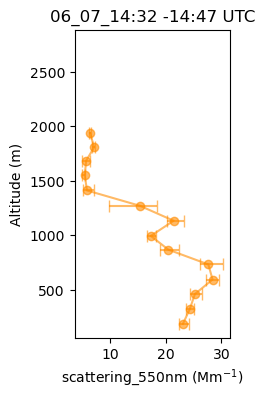

In [32]:
fig, ax = plt.subplots(figsize=(2, 4))
ax.errorbar(DAY7_subset_median['Sc550_submicron_amb_ZIEMBA'], DAY7_subset_median['GPS_Altitude_THORNHILL'], xerr=[DAY7_subset_25['Sc550_submicron_amb_ZIEMBA'], DAY7_subset_75['Sc550_submicron_amb_ZIEMBA']], marker='o', linestyle='-', capsize=4, alpha=.6, color="darkorange", label = '>10nm')
ax.set_xlabel('scattering_550nm (Mm$^{-1}$)')
ax.set_ylabel('Altitude (m)')
#fig.suptitle('f(RH)', fontsize=16)

ax.set_title('06_07_14:32 -14:47 UTC')

Text(0.5, 1.0, '06_07_14:32 -14:47 UTC')

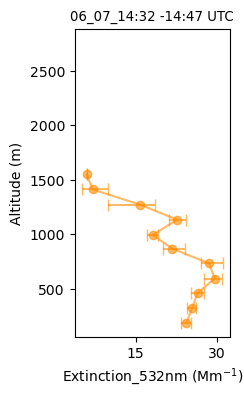

In [33]:
fig, ax = plt.subplots(figsize=(2, 4))
plt.rcParams['font.size'] = '8'
ax.errorbar(DAY7_subset_median['Ext532_submicron_amb_ZIEMBA'], DAY7_subset_median['GPS_Altitude_THORNHILL'], xerr=[DAY7_subset_25['Ext532_submicron_amb_ZIEMBA'], DAY7_subset_75['Ext532_submicron_amb_ZIEMBA']], marker='o', linestyle='-', capsize=4, alpha=.6, color="darkorange", label = '>10nm')
ax.set_xlabel('Extinction_532nm (Mm$^{-1}$)')
ax.set_ylabel('Altitude (m)')
ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=2)) 
ax.xaxis.set_minor_locator(ticker.NullLocator())
#fig.suptitle('f(RH)', fontsize=16)
ax.set_title('06_07_14:32 -14:47 UTC')

In [34]:
DAY7b = simple_read('C:/Users/taiwoajayi/Documents/Ozone/f(RH)/activate-mrg1_hu25_20220607_R0_L2_20230727T154850.ict')
start_index = np.where(DAY7b["Time_Start"]==pd.to_datetime("2022-06-07 19:08:00"))
stop_index = np.where(DAY7b["Time_Start"]==pd.to_datetime("2022-06-07 19:23:00"))
    
DAY7b_subset =DAY7b[start_index[0][0]:stop_index[0][0]]
DAY7b_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Static_Air_Temp_THORNHILL,Sc550_submicron_amb_ZIEMBA,Sc550_submicron_ZIEMBA,RH_Sc_submicron_ZIEMBA,Abs532_total_ZIEMBA,Ext532_submicron_amb_ZIEMBA,fRH550_RH20to80_ZIEMBA,SSA_550nm_ZIEMBA,SSA_amb_550nm_ZIEMBA
10420,2022-06-07 19:08:00,2022-06-07 19:08:01,32.242823,-65.003952,133.320,21.455,NaN,NaN,47.70,NaN,NaN,NaN,NaN,NaN
10421,2022-06-07 19:08:01,2022-06-07 19:08:02,32.243085,-65.002775,133.120,21.445,NaN,NaN,47.70,NaN,NaN,NaN,NaN,NaN
10422,2022-06-07 19:08:02,2022-06-07 19:08:03,32.243347,-65.001596,132.930,21.440,NaN,NaN,47.70,NaN,NaN,NaN,NaN,NaN
10423,2022-06-07 19:08:03,2022-06-07 19:08:04,32.243610,-65.000416,132.720,21.460,NaN,NaN,47.70,NaN,NaN,NaN,NaN,NaN
10424,2022-06-07 19:08:04,2022-06-07 19:08:05,32.243873,-64.999235,132.595,21.475,NaN,NaN,47.70,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11315,2022-06-07 19:22:55,2022-06-07 19:22:56,32.296480,-65.011792,3518.030,5.895,NaN,NaN,29.70,NaN,NaN,NaN,NaN,NaN
11316,2022-06-07 19:22:56,2022-06-07 19:22:57,32.296519,-65.013093,3524.890,5.850,NaN,NaN,29.70,NaN,NaN,NaN,NaN,NaN
11317,2022-06-07 19:22:57,2022-06-07 19:22:58,32.296518,-65.014396,3531.840,5.795,NaN,NaN,29.70,NaN,NaN,NaN,NaN,NaN
11318,2022-06-07 19:22:58,2022-06-07 19:22:59,32.296479,-65.015699,3538.850,5.735,NaN,NaN,29.65,NaN,NaN,NaN,NaN,NaN


In [35]:
nbins = 20
bins = np.linspace(DAY7b_subset.GPS_Altitude_THORNHILL.min(), DAY7b_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY7b_subset['Bins'] = pd.cut(DAY7b_subset['GPS_Altitude_THORNHILL'], bins)
DAY7b_subset_median = DAY7b_subset.groupby('Bins').median()
DAY7b_subset_median

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Static_Air_Temp_THORNHILL,Sc550_submicron_amb_ZIEMBA,Sc550_submicron_ZIEMBA,RH_Sc_submicron_ZIEMBA,Abs532_total_ZIEMBA,Ext532_submicron_amb_ZIEMBA,fRH550_RH20to80_ZIEMBA,SSA_550nm_ZIEMBA,SSA_amb_550nm_ZIEMBA
Bins,,,,,,,,,,,,,,
"(132.595, 303.26]",2022-06-07 19:08:28.000,2022-06-07 19:08:29.000,32.257846,-64.976147,210.165,20.8900,NaN,NaN,47.60,NaN,NaN,NaN,NaN,NaN
"(303.26, 473.926]",2022-06-07 19:09:23.000,2022-06-07 19:09:24.000,32.299892,-65.003903,388.610,19.1050,NaN,NaN,46.60,NaN,NaN,NaN,NaN,NaN
"(473.926, 644.591]",2022-06-07 19:10:16.000,2022-06-07 19:10:17.000,32.270860,-65.050200,553.840,17.4900,NaN,NaN,46.10,NaN,NaN,NaN,NaN,NaN
"(644.591, 815.256]",2022-06-07 19:11:06.000,2022-06-07 19:11:07.000,32.236773,-65.016539,727.605,15.7500,NaN,NaN,46.00,NaN,NaN,NaN,NaN,NaN
"(815.256, 985.921]",2022-06-07 19:11:57.000,2022-06-07 19:11:58.000,32.268496,-64.981012,894.580,14.4900,NaN,NaN,45.50,NaN,NaN,NaN,NaN,NaN
"(985.921, 1156.586]",2022-06-07 19:12:50.000,2022-06-07 19:12:51.000,32.297975,-65.025065,1079.310,13.3400,NaN,NaN,44.40,NaN,NaN,NaN,NaN,NaN
"(1156.586, 1327.252]",2022-06-07 19:13:46.000,2022-06-07 19:13:47.000,32.254313,-65.055631,1249.830,13.6300,NaN,NaN,41.55,NaN,NaN,NaN,NaN,NaN
"(1327.252, 1497.917]",2022-06-07 19:14:42.000,2022-06-07 19:14:43.000,32.235256,-64.999635,1404.740,15.3050,NaN,NaN,35.90,NaN,NaN,NaN,NaN,NaN
"(1497.917, 1668.582]",2022-06-07 19:15:35.500,2022-06-07 19:15:36.500,32.283800,-64.989856,1578.760,15.0925,NaN,NaN,32.30,NaN,NaN,NaN,NaN,NaN


In [36]:

DAY7b_subset_25 = DAY7b_subset_median - DAY7b_subset.groupby('Bins').quantile(.25)
DAY7b_subset_25
DAY7b_subset_75 = DAY7b_subset.groupby('Bins').quantile(.75) - DAY7b_subset_median
DAY7b_subset_75

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Static_Air_Temp_THORNHILL,Sc550_submicron_amb_ZIEMBA,Sc550_submicron_ZIEMBA,RH_Sc_submicron_ZIEMBA,Abs532_total_ZIEMBA,Ext532_submicron_amb_ZIEMBA,fRH550_RH20to80_ZIEMBA,SSA_550nm_ZIEMBA,SSA_amb_550nm_ZIEMBA
Bins,,,,,,,,,,,,,,
"(132.595, 303.26]",0 days 00:00:13.500000,0 days 00:00:13.500000,0.013547,0.002931,37.7050,0.51750,NaN,NaN,0.1000,NaN,NaN,NaN,NaN,NaN
"(303.26, 473.926]",0 days 00:00:13.500000,0 days 00:00:13.500000,0.002504,0.015890,38.4625,0.48000,NaN,NaN,0.2000,NaN,NaN,NaN,NaN,NaN
"(473.926, 644.591]",0 days 00:00:12.500000,0 days 00:00:12.500000,0.013278,0.003860,44.6375,0.38000,NaN,NaN,0.2000,NaN,NaN,NaN,NaN,NaN
"(644.591, 815.256]",0 days 00:00:12,0 days 00:00:12,0.003080,0.014534,39.2300,0.55000,NaN,NaN,0.0000,NaN,NaN,NaN,NaN,NaN
"(815.256, 985.921]",0 days 00:00:13,0 days 00:00:13,0.013432,0.002435,48.8150,0.23000,NaN,NaN,0.2000,NaN,NaN,NaN,NaN,NaN
"(985.921, 1156.586]",0 days 00:00:13,0 days 00:00:13,0.002024,0.016621,38.6100,0.18500,NaN,NaN,0.3000,NaN,NaN,NaN,NaN,NaN
"(1156.586, 1327.252]",0 days 00:00:14.500000,0 days 00:00:14.500000,0.015633,0.007776,38.2500,1.33500,NaN,NaN,0.9000,NaN,NaN,NaN,NaN,NaN
"(1327.252, 1497.917]",0 days 00:00:13,0 days 00:00:13,0.009127,0.011747,44.8000,0.07000,NaN,NaN,1.1000,NaN,NaN,NaN,NaN,NaN
"(1497.917, 1668.582]",0 days 00:00:13.250000128,0 days 00:00:13.250000128,0.008584,0.007586,44.5350,0.08000,NaN,NaN,0.7375,NaN,NaN,NaN,NaN,NaN


Text(0.5, 1.0, '06_07_19:08 - 19:23')

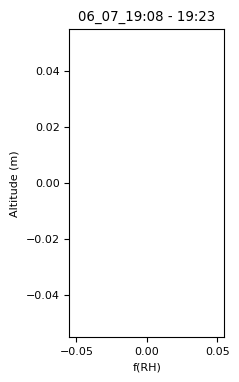

In [37]:
fig, ax = plt.subplots(figsize=(2, 4))
ax.errorbar(DAY7b_subset_median['fRH550_RH20to80_ZIEMBA'], DAY7b_subset_median['GPS_Altitude_THORNHILL'], xerr=[DAY7b_subset_25['fRH550_RH20to80_ZIEMBA'], DAY7b_subset_75['fRH550_RH20to80_ZIEMBA']], marker='o', linestyle='-', capsize=4, alpha=.6, color="darkorange", label = '>10nm')
ax.set_xlabel('f(RH)')
ax.set_ylabel('Altitude (m)')
#fig.suptitle('f(RH)', fontsize=16)
ax.set_title('06_07_19:08 - 19:23')

Text(0.5, 1.0, '06_07_19:08 - 19:23')

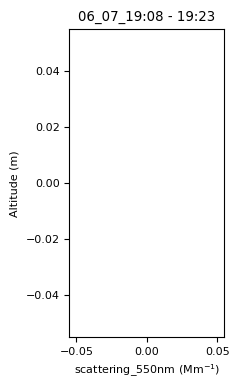

In [38]:
fig, ax = plt.subplots(figsize=(2, 4))
ax.errorbar(DAY7b_subset_median['Sc550_submicron_amb_ZIEMBA'], DAY7b_subset_median['GPS_Altitude_THORNHILL'], xerr=[DAY7b_subset_25['Sc550_submicron_amb_ZIEMBA'], DAY7b_subset_75['Sc550_submicron_amb_ZIEMBA']], marker='o', linestyle='-', capsize=4, alpha=.6, color="darkorange", label = '>10nm')
ax.set_xlabel('scattering_550nm (Mm$^{-1}$)')
ax.set_ylabel('Altitude (m)')
#fig.suptitle('f(RH)', fontsize=16)
ax.set_title('06_07_19:08 - 19:23')

Text(0.5, 1.0, '06_07_19:08 - 19:23')

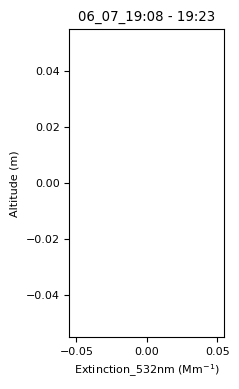

In [39]:
fig, ax = plt.subplots(figsize=(2, 4))
ax.errorbar(DAY7b_subset_median['Ext532_submicron_amb_ZIEMBA'], DAY7b_subset_median['GPS_Altitude_THORNHILL'], xerr=[DAY7b_subset_25['Ext532_submicron_amb_ZIEMBA'], DAY7b_subset_75['Ext532_submicron_amb_ZIEMBA']], marker='o', linestyle='-', capsize=4, alpha=.6, color="darkorange", label = '>10nm')
ax.set_xlabel('Extinction_532nm (Mm$^{-1}$)')
ax.set_ylabel('Altitude (m)')
#fig.suptitle('f(RH)', fontsize=16)
ax.set_title('06_07_19:08 - 19:23')

In [40]:
DAY8 = simple_read('C:/Users/taiwoajayi/Documents/Ozone/f(RH)/activate-mrg1_hu25_20220608_R0_L2_20230727T154851.ict')
start_index = np.where(DAY8["Time_Start"]==pd.to_datetime("2022-06-08 20:30:00"))
stop_index = np.where(DAY8["Time_Start"]==pd.to_datetime("2022-06-08 20:45:00"))
    
DAY8_subset = DAY8[start_index[0][0]:stop_index[0][0]]
DAY8_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Static_Air_Temp_THORNHILL,Sc550_submicron_amb_ZIEMBA,Sc550_submicron_ZIEMBA,RH_Sc_submicron_ZIEMBA,Abs532_total_ZIEMBA,Ext532_submicron_amb_ZIEMBA,fRH550_RH20to80_ZIEMBA,SSA_550nm_ZIEMBA,SSA_amb_550nm_ZIEMBA
10668,2022-06-08 20:30:00,2022-06-08 20:30:01,32.267080,-64.998961,152.725,21.365,11.455,12.305,47.60,1.210,12.935,0.745,NaN,NaN
10669,2022-06-08 20:30:01,2022-06-08 20:30:02,32.268158,-64.999178,153.350,21.390,12.040,13.010,47.60,0.440,12.770,0.730,NaN,NaN
10670,2022-06-08 20:30:02,2022-06-08 20:30:03,32.269234,-64.999434,153.870,21.405,13.275,13.885,47.65,-0.530,13.065,0.855,NaN,NaN
10671,2022-06-08 20:30:03,2022-06-08 20:30:04,32.270310,-64.999724,154.255,21.375,12.860,12.815,47.70,-0.170,13.005,1.015,NaN,NaN
10672,2022-06-08 20:30:04,2022-06-08 20:30:05,32.271382,-65.000051,154.510,21.390,12.120,12.020,47.70,0.265,12.680,1.050,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11563,2022-06-08 20:44:55,2022-06-08 20:44:56,32.251172,-65.086081,3838.620,3.190,NaN,0.710,32.20,4.205,NaN,NaN,0.3190,NaN
11564,2022-06-08 20:44:56,2022-06-08 20:44:57,32.250122,-65.085465,3847.170,3.130,NaN,1.490,32.20,4.705,NaN,NaN,0.3190,NaN
11565,2022-06-08 20:44:57,2022-06-08 20:44:58,32.249088,-65.084808,3855.660,3.065,NaN,1.835,32.20,4.775,NaN,NaN,0.3115,NaN
11566,2022-06-08 20:44:58,2022-06-08 20:44:59,32.248074,-65.084107,3864.100,3.005,NaN,1.920,32.20,4.660,NaN,NaN,0.2985,NaN


In [41]:
nbins = 20
bins = np.linspace(DAY8_subset.GPS_Altitude_THORNHILL.min(), DAY8_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY8_subset['Bins'] = pd.cut(DAY8_subset['GPS_Altitude_THORNHILL'], bins)
DAY8_subset_median = DAY8_subset.groupby('Bins').median()
DAY8_subset_median
DAY8_subset_25 = DAY8_subset_median - DAY8_subset.groupby('Bins').quantile(.25)
DAY8_subset_25
DAY8_subset_75 = DAY8_subset.groupby('Bins').quantile(.75) - DAY8_subset_median
DAY8_subset_75

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Static_Air_Temp_THORNHILL,Sc550_submicron_amb_ZIEMBA,Sc550_submicron_ZIEMBA,RH_Sc_submicron_ZIEMBA,Abs532_total_ZIEMBA,Ext532_submicron_amb_ZIEMBA,fRH550_RH20to80_ZIEMBA,SSA_550nm_ZIEMBA,SSA_amb_550nm_ZIEMBA
Bins,,,,,,,,,,,,,,
"(147.455, 333.705]",0 days 00:00:27,0 days 00:00:27,0.007854,0.035028,64.2550,0.18000,0.85000,0.92500,0.0000,0.33500,0.92000,0.10000,NaN,NaN
"(333.705, 519.956]",0 days 00:00:13.250000128,0 days 00:00:13.250000128,0.008836,0.014153,42.6200,0.43875,0.94625,1.49750,0.0000,0.46125,1.10750,0.12125,NaN,NaN
"(519.956, 706.206]",0 days 00:00:14.500000,0 days 00:00:14.500000,0.014929,0.006504,44.2025,0.42250,0.53000,1.38250,0.2000,0.38500,0.50500,0.20500,NaN,NaN
"(706.206, 892.456]",0 days 00:00:14.500000,0 days 00:00:14.500000,0.003217,0.013764,48.1300,0.46500,1.28500,0.89250,0.1000,0.38750,1.07250,0.16500,NaN,NaN
"(892.456, 1078.706]",0 days 00:00:15,0 days 00:00:15,0.014171,0.003605,48.4600,0.32500,31.76875,12.03500,0.1000,1.05000,30.55500,0.26000,NaN,NaN
"(1078.706, 1264.956]",0 days 00:00:14.500000,0 days 00:00:14.500000,0.004731,0.016424,46.0750,0.86250,4.31000,4.03750,0.4000,1.26000,4.24000,0.25000,NaN,NaN
"(1264.956, 1451.207]",0 days 00:00:16.749999872,0 days 00:00:16.749999872,0.008973,0.004759,36.2825,0.14625,0.42500,1.08250,2.0375,0.79625,4.80625,0.16500,NaN,NaN
"(1451.207, 1637.457]",0 days 00:00:11.250000128,0 days 00:00:11.250000128,0.009496,0.006688,52.9550,0.25875,NaN,1.29375,0.4000,0.83500,NaN,NaN,NaN,NaN
"(1637.457, 1823.707]",0 days 00:00:10.749999872,0 days 00:00:10.749999872,0.008963,0.009932,46.5500,0.41500,NaN,0.42500,0.0250,0.37125,NaN,NaN,NaN,NaN


Text(0.5, 1.0, '06_08_20:30 – 20:45 UTC')

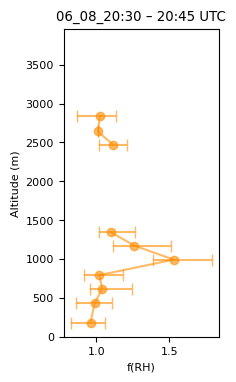

In [42]:
fig, ax = plt.subplots(figsize=(2, 4))
ax.errorbar(DAY8_subset_median['fRH550_RH20to80_ZIEMBA'], DAY8_subset_median['GPS_Altitude_THORNHILL'], xerr=[DAY8_subset_25['fRH550_RH20to80_ZIEMBA'], DAY8_subset_75['fRH550_RH20to80_ZIEMBA']], marker='o', linestyle='-', capsize=4, alpha=.6, color="darkorange", label = '>10nm')
ax.set_xlabel('f(RH)')
ax.set_ylabel('Altitude (m)')
#fig.suptitle('f(RH)', fontsize=16)
ax.set_title('06_08_20:30 – 20:45 UTC')

Text(0.5, 1.0, '06_08_20:30 – 20:45 UTC')

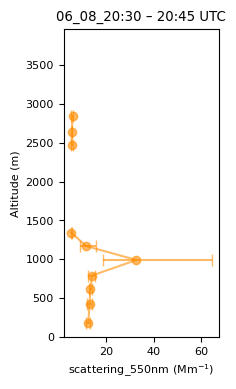

In [43]:
fig, ax = plt.subplots(figsize=(2, 4))
ax.errorbar(DAY8_subset_median['Sc550_submicron_amb_ZIEMBA'], DAY8_subset_median['GPS_Altitude_THORNHILL'], xerr=[DAY8_subset_25['Sc550_submicron_amb_ZIEMBA'], DAY8_subset_75['Sc550_submicron_amb_ZIEMBA']], marker='o', linestyle='-', capsize=4, alpha=.6, color="darkorange", label = '>10nm')
ax.set_xlabel('scattering_550nm (Mm$^{-1}$)')
ax.set_ylabel('Altitude (m)')
#fig.suptitle('f(RH)', fontsize=16)
ax.set_title('06_08_20:30 – 20:45 UTC')

Text(0.5, 1.0, '06_08_20:30 – 20:45 UTC')

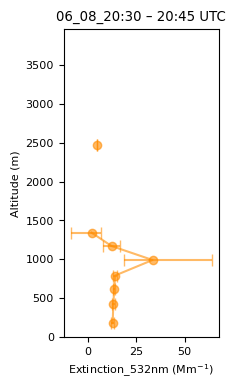

In [44]:
fig, ax = plt.subplots(figsize=(2, 4))
ax.errorbar(DAY8_subset_median['Ext532_submicron_amb_ZIEMBA'], DAY8_subset_median['GPS_Altitude_THORNHILL'], xerr=[DAY8_subset_25['Ext532_submicron_amb_ZIEMBA'], DAY8_subset_75['Ext532_submicron_amb_ZIEMBA']], marker='o', linestyle='-', capsize=4, alpha=.6, color="darkorange", label = '>10nm')
ax.set_xlabel('Extinction_532nm (Mm$^{-1}$)')
ax.set_ylabel('Altitude (m)')
#fig.suptitle('f(RH)', fontsize=16)
ax.set_title('06_08_20:30 – 20:45 UTC')

In [45]:
DAY10 = simple_read('C:/Users/taiwoajayi/Documents/Ozone/f(RH)/activate-mrg1_hu25_20220610_R0_L1_20230727T154852.ict')
start_index = np.where(DAY10["Time_Start"]==pd.to_datetime("2022-06-10 15:17:00"))
stop_index = np.where(DAY10["Time_Start"]==pd.to_datetime("2022-06-10 15:25:00"))
    
DAY10_subset = DAY10[start_index[0][0]:stop_index[0][0]]
DAY10_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Static_Air_Temp_THORNHILL,Sc550_submicron_amb_ZIEMBA,Sc550_submicron_ZIEMBA,RH_Sc_submicron_ZIEMBA,Abs532_total_ZIEMBA,Ext532_submicron_amb_ZIEMBA,fRH550_RH20to80_ZIEMBA,SSA_550nm_ZIEMBA,SSA_amb_550nm_ZIEMBA
10616,2022-06-10 15:17:00,2022-06-10 15:17:01,32.206691,-64.996969,122.040,23.330,NaN,NaN,61.4,NaN,NaN,NaN,NaN,NaN
10617,2022-06-10 15:17:01,2022-06-10 15:17:02,32.207809,-64.997169,122.105,23.320,NaN,NaN,61.4,NaN,NaN,NaN,NaN,NaN
10618,2022-06-10 15:17:02,2022-06-10 15:17:03,32.208928,-64.997370,122.170,23.280,NaN,NaN,61.4,NaN,NaN,NaN,NaN,NaN
10619,2022-06-10 15:17:03,2022-06-10 15:17:04,32.210048,-64.997569,122.240,23.315,NaN,NaN,61.4,NaN,NaN,NaN,NaN,NaN
10620,2022-06-10 15:17:04,2022-06-10 15:17:05,32.211167,-64.997768,122.315,23.370,NaN,NaN,61.5,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11091,2022-06-10 15:24:55,2022-06-10 15:24:56,32.207088,-65.031191,3540.260,7.225,NaN,NaN,43.2,NaN,NaN,NaN,NaN,NaN
11092,2022-06-10 15:24:56,2022-06-10 15:24:57,32.207061,-65.029663,3546.970,7.175,NaN,NaN,43.2,NaN,NaN,NaN,NaN,NaN
11093,2022-06-10 15:24:57,2022-06-10 15:24:58,32.207068,-65.028134,3553.620,7.145,NaN,NaN,43.2,NaN,NaN,NaN,NaN,NaN
11094,2022-06-10 15:24:58,2022-06-10 15:24:59,32.207109,-65.026603,3560.200,7.115,NaN,NaN,43.2,NaN,NaN,NaN,NaN,NaN


In [46]:
nbins = 20
bins = np.linspace(DAY10_subset.GPS_Altitude_THORNHILL.min(), DAY10_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY10_subset['Bins'] = pd.cut(DAY10_subset['GPS_Altitude_THORNHILL'], bins)
DAY10_subset_median = DAY10_subset.groupby('Bins').median()
DAY10_subset_median
DAY10_subset_25 = DAY10_subset_median - DAY10_subset.groupby('Bins').quantile(.25)
DAY10_subset_25
DAY10_subset_75 = DAY10_subset.groupby('Bins').quantile(.75) - DAY10_subset_median
DAY10_subset_75

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Static_Air_Temp_THORNHILL,Sc550_submicron_amb_ZIEMBA,Sc550_submicron_ZIEMBA,RH_Sc_submicron_ZIEMBA,Abs532_total_ZIEMBA,Ext532_submicron_amb_ZIEMBA,fRH550_RH20to80_ZIEMBA,SSA_550nm_ZIEMBA,SSA_amb_550nm_ZIEMBA
Bins,,,,,,,,,,,,,,
"(122.04, 294.274]",0 days 00:00:17,0 days 00:00:17,0.019265,0.003430,46.49000,0.06500,NaN,NaN,0.0500,NaN,NaN,NaN,NaN,NaN
"(294.274, 466.509]",0 days 00:00:05,0 days 00:00:05,0.003220,0.004873,42.82500,0.21000,NaN,NaN,0.2500,NaN,NaN,NaN,NaN,NaN
"(466.509, 638.743]",0 days 00:00:05,0 days 00:00:05,0.000502,0.006371,41.04500,0.18000,NaN,NaN,0.3000,NaN,NaN,NaN,NaN,NaN
"(638.743, 810.978]",0 days 00:00:04.749999872,0 days 00:00:04.749999872,0.001362,0.005948,39.60000,0.21500,NaN,NaN,0.3500,NaN,NaN,NaN,NaN,NaN
"(810.978, 983.212]",0 days 00:00:04.749999872,0 days 00:00:04.749999872,0.003760,0.004314,42.35375,0.33500,NaN,NaN,0.3750,NaN,NaN,NaN,NaN,NaN
"(983.212, 1155.447]",0 days 00:00:04.500000,0 days 00:00:04.500000,0.004850,0.001614,40.62500,0.23000,NaN,NaN,0.6750,NaN,NaN,NaN,NaN,NaN
"(1155.447, 1327.682]",0 days 00:00:04.749999872,0 days 00:00:04.749999872,0.005316,0.002019,41.13500,0.23125,NaN,NaN,0.3625,NaN,NaN,NaN,NaN,NaN
"(1327.682, 1499.916]",0 days 00:00:04.749999872,0 days 00:00:04.749999872,0.004214,0.004939,41.76500,0.21875,NaN,NaN,0.1000,NaN,NaN,NaN,NaN,NaN
"(1499.916, 1672.15]",0 days 00:00:05,0 days 00:00:05,0.002058,0.006995,39.61000,0.17000,NaN,NaN,0.0000,NaN,NaN,NaN,NaN,NaN


Text(0.5, 1.0, '06_10_15:17 – 15:25 UTC')

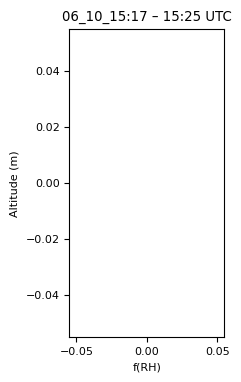

In [47]:
fig, ax = plt.subplots(figsize=(2, 4))
ax.errorbar(DAY10_subset_median['fRH550_RH20to80_ZIEMBA'], DAY10_subset_median['GPS_Altitude_THORNHILL'], xerr=[DAY10_subset_25['fRH550_RH20to80_ZIEMBA'], DAY10_subset_75['fRH550_RH20to80_ZIEMBA']], marker='o', linestyle='-', capsize=4, alpha=.6, color="darkorange", label = '>10nm')
ax.set_xlabel('f(RH)')
ax.set_ylabel('Altitude (m)')
#fig.suptitle('f(RH)', fontsize=16)
ax.set_title('06_10_15:17 – 15:25 UTC')

Text(0.5, 1.0, '06_10_15:17 – 15:25 UTC')

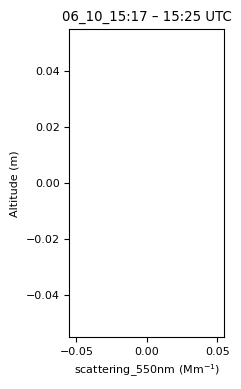

In [48]:
fig, ax = plt.subplots(figsize=(2, 4))
ax.errorbar(DAY10_subset_median['Sc550_submicron_amb_ZIEMBA'], DAY10_subset_median['GPS_Altitude_THORNHILL'], xerr=[DAY10_subset_25['Sc550_submicron_amb_ZIEMBA'], DAY10_subset_75['Sc550_submicron_amb_ZIEMBA']], marker='o', linestyle='-', capsize=4, alpha=.6, color="darkorange", label = '>10nm')
ax.set_xlabel('scattering_550nm (Mm$^{-1}$)')
ax.set_ylabel('Altitude (m)')
#fig.suptitle('f(RH)', fontsize=16)
ax.set_title('06_10_15:17 – 15:25 UTC')

Text(0.5, 1.0, '06_10_15:17 – 15:25 UTC')

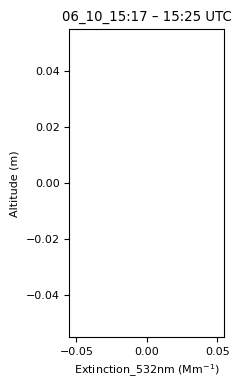

In [49]:
fig, ax = plt.subplots(figsize=(2, 4))
ax.errorbar(DAY10_subset_median['Ext532_submicron_amb_ZIEMBA'], DAY10_subset_median['GPS_Altitude_THORNHILL'], xerr=[DAY10_subset_25['Ext532_submicron_amb_ZIEMBA'], DAY10_subset_75['Ext532_submicron_amb_ZIEMBA']], marker='o', linestyle='-', capsize=4, alpha=.6, color="darkorange", label = '>10nm')
ax.set_xlabel('Extinction_532nm (Mm$^{-1}$)')
ax.set_ylabel('Altitude (m)')
#fig.suptitle('f(RH)', fontsize=16)
ax.set_title('06_10_15:17 – 15:25 UTC')

In [50]:
DAY10b = simple_read('C:/Users/taiwoajayi/Documents/Ozone/f(RH)/activate-mrg1_hu25_20220610_R0_L2_20230727T154852.ict')
start_index = np.where(DAY10b["Time_Start"]==pd.to_datetime("2022-06-10 19:30:00"))
stop_index = np.where(DAY10b["Time_Start"]==pd.to_datetime("2022-06-10 19:51:00"))
    
DAY110b_subset = DAY10b[start_index[0][0]:stop_index[0][0]]
DAY110b_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Static_Air_Temp_THORNHILL,Sc550_submicron_amb_ZIEMBA,Sc550_submicron_ZIEMBA,RH_Sc_submicron_ZIEMBA,Abs532_total_ZIEMBA,Ext532_submicron_amb_ZIEMBA,fRH550_RH20to80_ZIEMBA,SSA_550nm_ZIEMBA,SSA_amb_550nm_ZIEMBA
7182,2022-06-10 19:30:00,2022-06-10 19:30:01,31.639092,-65.606420,113.375,24.160,27.355,30.540,60.1,0.415,28.345,0.870,NaN,NaN
7183,2022-06-10 19:30:01,2022-06-10 19:30:02,31.639446,-65.607515,113.225,24.150,29.105,30.325,60.1,0.850,30.565,0.955,NaN,NaN
7184,2022-06-10 19:30:02,2022-06-10 19:30:03,31.639806,-65.608607,113.065,24.135,29.095,30.020,60.1,0.890,30.595,0.965,NaN,NaN
7185,2022-06-10 19:30:03,2022-06-10 19:30:04,31.640170,-65.609698,112.970,24.125,29.080,28.055,60.2,0.430,30.120,1.070,NaN,NaN
7186,2022-06-10 19:30:04,2022-06-10 19:30:05,31.640539,-65.610788,112.985,24.120,28.960,27.940,60.3,1.050,30.610,1.070,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8437,2022-06-10 19:50:55,2022-06-10 19:50:56,31.228702,-65.973911,4967.450,-1.930,NaN,2.700,29.2,5.515,NaN,NaN,0.3120,NaN
8438,2022-06-10 19:50:56,2022-06-10 19:50:57,31.227365,-65.974288,4964.110,-1.845,NaN,2.040,29.2,5.010,NaN,NaN,0.2990,NaN
8439,2022-06-10 19:50:57,2022-06-10 19:50:58,31.226025,-65.974659,4960.810,-1.830,NaN,1.465,29.3,2.245,NaN,NaN,0.2875,NaN
8440,2022-06-10 19:50:58,2022-06-10 19:50:59,31.224682,-65.975025,4957.520,-1.795,NaN,1.865,29.2,1.525,NaN,NaN,0.2780,NaN


In [51]:
nbins = 20
bins = np.linspace(DAY110b_subset.GPS_Altitude_THORNHILL.min(), DAY110b_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY110b_subset['Bins'] = pd.cut(DAY110b_subset['GPS_Altitude_THORNHILL'], bins)
DAY110b_subset_median = DAY110b_subset.groupby('Bins').median()
DAY110b_subset_median
DAY110b_subset_25 = DAY110b_subset_median - DAY110b_subset.groupby('Bins').quantile(.25)
DAY110b_subset_25
DAY110b_subset_75 = DAY110b_subset.groupby('Bins').quantile(.75) - DAY110b_subset_median
DAY110b_subset_75

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Static_Air_Temp_THORNHILL,Sc550_submicron_amb_ZIEMBA,Sc550_submicron_ZIEMBA,RH_Sc_submicron_ZIEMBA,Abs532_total_ZIEMBA,Ext532_submicron_amb_ZIEMBA,fRH550_RH20to80_ZIEMBA,SSA_550nm_ZIEMBA,SSA_amb_550nm_ZIEMBA
Bins,,,,,,,,,,,,,,
"(112.97, 357.058]",0 days 00:01:18,0 days 00:01:18,0.052221,0.078943,2.26500,0.09000,3.41625,3.58000,0.200,0.32000,3.19750,0.10000,NaN,NaN
"(357.058, 601.145]",0 days 00:00:11.250000128,0 days 00:00:11.250000128,0.007922,0.011272,63.13875,0.30750,1.74750,2.80625,0.625,0.54750,1.84125,0.08625,0.000375,0.000375
"(601.145, 845.233]",0 days 00:00:11.749999872,0 days 00:00:11.749999872,0.004252,0.009937,59.90500,0.38625,1.09125,1.77750,0.375,0.36250,1.19375,0.05625,NaN,NaN
"(845.233, 1089.32]",0 days 00:00:10.749999872,0 days 00:00:10.749999872,0.009107,0.006360,56.24500,0.51250,2.00000,2.79875,0.575,0.76500,2.35500,0.09000,NaN,NaN
"(1089.32, 1333.408]",0 days 00:00:11.500000,0 days 00:00:11.500000,0.012293,0.009116,55.20000,0.43750,2.56750,1.92500,0.375,0.18500,2.30000,0.15500,NaN,NaN
"(1333.408, 1577.495]",0 days 00:00:08.749999872,0 days 00:00:08.749999872,0.002226,0.011545,69.47250,0.27250,3.21625,3.34375,0.350,1.03500,3.73500,0.10875,NaN,NaN
"(1577.495, 1821.582]",0 days 00:00:09.250000128,0 days 00:00:09.250000128,0.006932,0.005957,45.91250,0.43750,1.63375,0.78875,0.350,0.41875,1.58875,0.25875,NaN,NaN
"(1821.582, 2065.67]",0 days 00:00:11,0 days 00:00:11,0.009504,0.007338,42.74000,0.39500,1.59000,1.20000,0.400,0.30000,0.88000,0.54500,NaN,NaN
"(2065.67, 2309.757]",0 days 00:00:09.250000128,0 days 00:00:09.250000128,0.006977,0.009989,55.74000,0.44000,0.41875,0.77375,0.350,0.67000,1.37250,0.15500,NaN,NaN


Text(0.5, 1.0, '06_10_19:30 - 19:51 UTC')

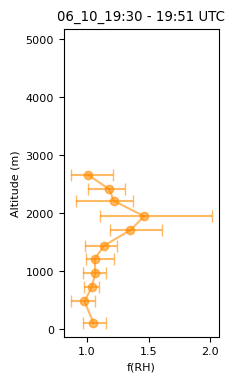

In [52]:
fig, ax = plt.subplots(figsize=(2, 4))
ax.errorbar(DAY110b_subset_median['fRH550_RH20to80_ZIEMBA'], DAY110b_subset_median['GPS_Altitude_THORNHILL'], xerr=[DAY110b_subset_25['fRH550_RH20to80_ZIEMBA'], DAY110b_subset_75['fRH550_RH20to80_ZIEMBA']], marker='o', linestyle='-', capsize=4, alpha=.6, color="darkorange", label = '>10nm')
ax.set_xlabel('f(RH)')
ax.set_ylabel('Altitude (m)')
#fig.suptitle('f(RH)', fontsize=16)
ax.set_title('06_10_19:30 - 19:51 UTC')

Text(0.5, 1.0, '06_10_19:30 - 19:51 UTC')

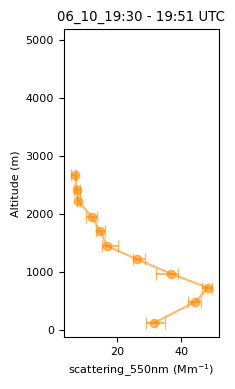

In [53]:
fig, ax = plt.subplots(figsize=(2, 4))
ax.errorbar(DAY110b_subset_median['Sc550_submicron_amb_ZIEMBA'], DAY110b_subset_median['GPS_Altitude_THORNHILL'], xerr=[DAY110b_subset_25['Sc550_submicron_amb_ZIEMBA'], DAY110b_subset_75['Sc550_submicron_amb_ZIEMBA']], marker='o', linestyle='-', capsize=4, alpha=.6, color="darkorange", label = '>10nm')
ax.set_xlabel('scattering_550nm (Mm$^{-1}$)')
ax.set_ylabel('Altitude (m)')
#fig.suptitle('f(RH)', fontsize=16)
ax.set_title('06_10_19:30 - 19:51 UTC')

Text(0.5, 1.0, '06_10_19:30 - 19:51 UTC')

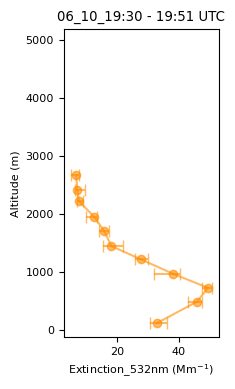

In [54]:
fig, ax = plt.subplots(figsize=(2, 4))
ax.errorbar(DAY110b_subset_median['Ext532_submicron_amb_ZIEMBA'], DAY110b_subset_median['GPS_Altitude_THORNHILL'], xerr=[DAY110b_subset_25['Ext532_submicron_amb_ZIEMBA'], DAY110b_subset_75['Ext532_submicron_amb_ZIEMBA']], marker='o', linestyle='-', capsize=4, alpha=.6, color="darkorange", label = '>10nm')
ax.set_xlabel('Extinction_532nm (Mm$^{-1}$)')
ax.set_ylabel('Altitude (m)')
#fig.suptitle('f(RH)', fontsize=16)
ax.set_title('06_10_19:30 - 19:51 UTC')

In [55]:
DAY10b = simple_read('C:/Users/taiwoajayi/Documents/Ozone/f(RH)/activate-mrg1_hu25_20220610_R0_L2_20230727T154852.ict')
start_index = np.where(DAY10b["Time_Start"]==pd.to_datetime("2022-06-10 20:25:00"))
stop_index = np.where(DAY10b["Time_Start"]==pd.to_datetime("2022-06-10 20:35:00"))
    
DAY10b_subset = DAY10b[start_index[0][0]:stop_index[0][0]]
DAY10b_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Static_Air_Temp_THORNHILL,Sc550_submicron_amb_ZIEMBA,Sc550_submicron_ZIEMBA,RH_Sc_submicron_ZIEMBA,Abs532_total_ZIEMBA,Ext532_submicron_amb_ZIEMBA,fRH550_RH20to80_ZIEMBA,SSA_550nm_ZIEMBA,SSA_amb_550nm_ZIEMBA
10482,2022-06-10 20:25:00,2022-06-10 20:25:01,31.199210,-65.892109,133.810,24.520,NaN,41.045,58.60,0.240,NaN,NaN,NaN,NaN
10483,2022-06-10 20:25:01,2022-06-10 20:25:02,31.200274,-65.891772,133.615,24.560,NaN,42.870,58.60,0.215,NaN,NaN,NaN,NaN
10484,2022-06-10 20:25:02,2022-06-10 20:25:03,31.201338,-65.891430,133.015,24.390,42.330,40.815,58.50,0.485,43.290,1.03,NaN,NaN
10485,2022-06-10 20:25:03,2022-06-10 20:25:04,31.202402,-65.891083,131.855,24.210,39.725,38.635,58.50,0.720,40.780,1.10,NaN,NaN
10486,2022-06-10 20:25:04,2022-06-10 20:25:05,31.203466,-65.890727,130.265,24.255,39.425,38.335,58.50,0.940,40.715,1.10,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11077,2022-06-10 20:34:55,2022-06-10 20:34:56,31.464508,-65.626679,4924.170,-1.585,NaN,1.625,30.70,3.135,NaN,NaN,NaN,NaN
11078,2022-06-10 20:34:56,2022-06-10 20:34:57,31.465555,-65.625580,4924.550,-1.575,NaN,1.225,30.70,3.700,NaN,NaN,NaN,NaN
11079,2022-06-10 20:34:57,2022-06-10 20:34:58,31.466603,-65.624479,4924.900,-1.570,NaN,-0.315,30.65,3.285,NaN,NaN,NaN,NaN
11080,2022-06-10 20:34:58,2022-06-10 20:34:59,31.467650,-65.623378,4925.210,-1.565,NaN,-0.155,30.60,2.890,NaN,NaN,NaN,NaN


In [56]:
nbins = 20
bins = np.linspace(DAY10b_subset.GPS_Altitude_THORNHILL.min(), DAY10b_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY10b_subset['Bins'] = pd.cut(DAY10b_subset['GPS_Altitude_THORNHILL'], bins)
DAY10b_subset_median = DAY10b_subset.groupby('Bins').median()
DAY10b_subset_median
DAY10b_subset_25 = DAY10b_subset_median - DAY10b_subset.groupby('Bins').quantile(.25)
DAY10b_subset_25
DAY10b_subset_75 = DAY10b_subset.groupby('Bins').quantile(.75) - DAY10b_subset_median
DAY10b_subset_75

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Static_Air_Temp_THORNHILL,Sc550_submicron_amb_ZIEMBA,Sc550_submicron_ZIEMBA,RH_Sc_submicron_ZIEMBA,Abs532_total_ZIEMBA,Ext532_submicron_amb_ZIEMBA,fRH550_RH20to80_ZIEMBA,SSA_550nm_ZIEMBA,SSA_amb_550nm_ZIEMBA
Bins,,,,,,,,,,,,,,
"(119.575, 360.352]",0 days 00:00:30.749999872,0 days 00:00:30.749999872,0.026552,0.025628,11.53625,0.55875,3.36375,3.66625,0.6000,0.72125,2.55500,0.07250,0.012250,0.012
"(360.352, 601.128]",0 days 00:00:05,0 days 00:00:05,0.005345,0.000487,63.40000,0.44000,0.89000,1.32000,0.2500,0.31500,1.73500,0.02500,NaN,NaN
"(601.128, 841.905]",0 days 00:00:04,0 days 00:00:04,0.002334,0.003576,59.49000,0.24500,4.01500,4.88000,0.3500,0.44000,4.30500,0.12000,NaN,NaN
"(841.905, 1082.682]",0 days 00:00:03.500000,0 days 00:00:03.500000,0.000212,0.003939,53.93000,0.33000,2.42750,1.66250,0.3750,0.35250,2.82000,0.14500,NaN,NaN
"(1082.682, 1323.459]",0 days 00:00:03.749999872,0 days 00:00:03.749999872,0.001746,0.003474,56.76750,0.41000,2.15375,3.03375,0.3750,0.84250,1.54125,0.03500,NaN,NaN
"(1323.459, 1564.236]",0 days 00:00:03.500000,0 days 00:00:03.500000,0.002901,0.001489,54.35500,0.25000,1.42750,3.26000,0.3500,0.58750,2.07500,0.11750,NaN,NaN
"(1564.236, 1805.012]",0 days 00:00:05.250000128,0 days 00:00:05.250000128,0.004838,0.003293,59.75250,0.55500,0.78500,1.01750,0.3875,0.56125,0.64625,0.04000,NaN,NaN
"(1805.012, 2045.789]",0 days 00:00:05.749999872,0 days 00:00:05.749999872,0.002513,0.007255,57.54000,0.09625,0.98875,1.34875,0.3750,1.08000,1.75500,0.06000,NaN,NaN
"(2045.789, 2286.566]",0 days 00:00:04.749999872,0 days 00:00:04.749999872,0.001430,0.006285,55.54750,0.45125,1.08625,0.92750,0.4250,0.49875,0.89125,0.09375,NaN,NaN


Text(0.5, 1.0, '06_10_20:25 - 20:35 UTC')

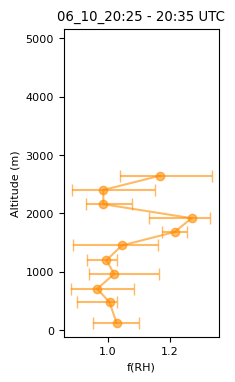

In [57]:
fig, ax = plt.subplots(figsize=(2, 4))
ax.errorbar(DAY10b_subset_median['fRH550_RH20to80_ZIEMBA'], DAY10b_subset_median['GPS_Altitude_THORNHILL'], xerr=[DAY10b_subset_25['fRH550_RH20to80_ZIEMBA'], DAY10b_subset_75['fRH550_RH20to80_ZIEMBA']], marker='o', linestyle='-', capsize=4, alpha=.6, color="darkorange", label = '>10nm')
ax.set_xlabel('f(RH)')
ax.set_ylabel('Altitude (m)')
#fig.suptitle('f(RH)', fontsize=16)
ax.set_title('06_10_20:25 - 20:35 UTC')

Text(0.5, 1.0, '06_10_20:25 - 20:35 UTC')

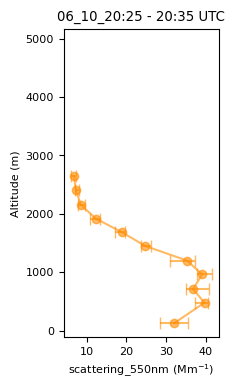

In [58]:
fig, ax = plt.subplots(figsize=(2, 4))
ax.errorbar(DAY10b_subset_median['Sc550_submicron_amb_ZIEMBA'], DAY10b_subset_median['GPS_Altitude_THORNHILL'], xerr=[DAY10b_subset_25['Sc550_submicron_amb_ZIEMBA'], DAY10b_subset_75['Sc550_submicron_amb_ZIEMBA']], marker='o', linestyle='-', capsize=4, alpha=.6, color="darkorange", label = '>10nm')
ax.set_xlabel('scattering_550nm (Mm$^{-1}$)')
ax.set_ylabel('Altitude (m)')
#fig.suptitle('f(RH)', fontsize=16)
ax.set_title('06_10_20:25 - 20:35 UTC')

Text(0.5, 1.0, '06_10_20:25 - 20:35 UTC')

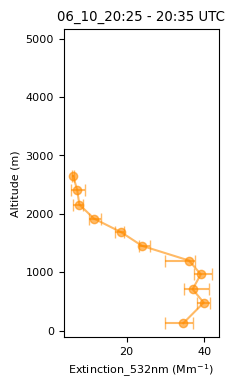

In [59]:
fig, ax = plt.subplots(figsize=(2, 4))
ax.errorbar(DAY10b_subset_median['Ext532_submicron_amb_ZIEMBA'], DAY10b_subset_median['GPS_Altitude_THORNHILL'], xerr=[DAY10b_subset_25['Ext532_submicron_amb_ZIEMBA'], DAY10b_subset_75['Ext532_submicron_amb_ZIEMBA']], marker='o', linestyle='-', capsize=4, alpha=.6, color="darkorange", label = '>10nm')
ax.set_xlabel('Extinction_532nm (Mm$^{-1}$)')
ax.set_ylabel('Altitude (m)')
#fig.suptitle('f(RH)', fontsize=16)
ax.set_title('06_10_20:25 - 20:35 UTC')

In [60]:
DAY11 = simple_read('C:/Users/taiwoajayi/Documents/Ozone/f(RH)/activate-mrg1_hu25_20220611_R0_L1_20230727T154853.ict')
start_index = np.where(DAY11["Time_Start"]==pd.to_datetime("2022-06-11 15:24:00"))
stop_index = np.where(DAY11["Time_Start"]==pd.to_datetime("2022-06-11 15:42:00"))
    
DAY11_subset = DAY11[start_index[0][0]:stop_index[0][0]]
DAY11_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Static_Air_Temp_THORNHILL,Sc550_submicron_amb_ZIEMBA,Sc550_submicron_ZIEMBA,RH_Sc_submicron_ZIEMBA,Abs532_total_ZIEMBA,Ext532_submicron_amb_ZIEMBA,fRH550_RH20to80_ZIEMBA,SSA_550nm_ZIEMBA,SSA_amb_550nm_ZIEMBA
10800,2022-06-11 15:24:00,2022-06-11 15:24:01,32.234864,-64.977277,137.985,23.790,33.015,37.430,61.20,0.690,34.410,0.845,NaN,NaN
10801,2022-06-11 15:24:01,2022-06-11 15:24:02,32.233969,-64.976649,138.245,23.800,35.620,35.750,61.20,1.125,37.500,0.995,NaN,NaN
10802,2022-06-11 15:24:02,2022-06-11 15:24:03,32.233058,-64.976063,138.485,23.770,33.285,29.855,61.20,1.945,35.935,1.155,NaN,NaN
10803,2022-06-11 15:24:03,2022-06-11 15:24:04,32.232130,-64.975521,138.740,23.725,29.055,28.250,61.20,1.860,31.525,1.055,NaN,NaN
10804,2022-06-11 15:24:04,2022-06-11 15:24:05,32.231186,-64.975026,139.035,23.715,30.160,33.750,61.20,1.290,32.075,0.870,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11875,2022-06-11 15:41:55,2022-06-11 15:41:56,32.259305,-64.971567,4701.700,-0.945,NaN,0.780,32.60,4.700,NaN,NaN,NaN,NaN
11876,2022-06-11 15:41:56,2022-06-11 15:41:57,32.258543,-64.970428,4708.440,-0.995,NaN,-1.310,32.60,3.215,NaN,NaN,NaN,NaN
11877,2022-06-11 15:41:57,2022-06-11 15:41:58,32.257745,-64.969326,4714.800,-1.050,NaN,0.205,32.60,4.640,NaN,NaN,NaN,NaN
11878,2022-06-11 15:41:58,2022-06-11 15:41:59,32.256913,-64.968261,4720.960,-1.060,NaN,2.635,32.55,7.540,NaN,NaN,NaN,NaN


In [61]:
nbins = 20
bins = np.linspace(DAY11_subset.GPS_Altitude_THORNHILL.min(), DAY11_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY11_subset['Bins'] = pd.cut(DAY11_subset['GPS_Altitude_THORNHILL'], bins)
DAY11_subset_median = DAY11_subset.groupby('Bins').median()
DAY11_subset_median
DAY11_subset_25 = DAY11_subset_median - DAY11_subset.groupby('Bins').quantile(.25)
DAY11_subset_25
DAY11_subset_75 = DAY11_subset.groupby('Bins').quantile(.75) - DAY11_subset_median
DAY11_subset_75

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Static_Air_Temp_THORNHILL,Sc550_submicron_amb_ZIEMBA,Sc550_submicron_ZIEMBA,RH_Sc_submicron_ZIEMBA,Abs532_total_ZIEMBA,Ext532_submicron_amb_ZIEMBA,fRH550_RH20to80_ZIEMBA,SSA_550nm_ZIEMBA,SSA_amb_550nm_ZIEMBA
Bins,,,,,,,,,,,,,,
"(137.295, 366.776]",0 days 00:00:38.749999872,0 days 00:00:38.749999872,0.019737,0.028329,63.0975,0.04500,1.48500,2.27875,0.2500,0.59000,1.4325,0.07125,NaN,NaN
"(366.776, 596.256]",0 days 00:00:17,0 days 00:00:17,0.014132,0.003947,51.5150,0.09500,2.66500,2.82000,1.0000,0.74000,3.2800,0.04000,NaN,NaN
"(596.256, 825.737]",0 days 00:00:11,0 days 00:00:11,0.007106,0.012731,69.3450,0.21500,1.36500,1.16000,0.5000,0.59000,1.1450,0.04000,0.000875,0.00075
"(825.737, 1055.218]",0 days 00:00:16.500000,0 days 00:00:16.500000,0.005502,0.020452,71.6350,0.31500,13.22250,14.53000,0.5000,0.90750,12.6175,0.03500,NaN,NaN
"(1055.218, 1284.699]",0 days 00:00:16,0 days 00:00:16,0.016132,0.004144,50.3300,0.26500,2.69500,4.89500,0.5000,0.68000,2.3250,0.07000,0.001000,0.00175
"(1284.699, 1514.18]",0 days 00:00:13.500000,0 days 00:00:13.500000,0.010896,0.014797,60.1850,0.21750,4.64250,2.72750,0.2000,0.58500,4.0975,0.03000,0.003000,0.00325
"(1514.18, 1743.66]",0 days 00:00:18.250000128,0 days 00:00:18.250000128,0.005987,0.022828,64.3225,0.03375,5.65625,4.30375,0.2000,0.48750,5.5325,0.05000,0.001250,0.00150
"(1743.66, 1973.141]",0 days 00:00:17.250000128,0 days 00:00:17.250000128,0.007032,0.014948,59.8675,0.18750,7.25375,8.67750,0.3000,0.45250,7.9800,0.07875,NaN,NaN
"(1973.141, 2202.622]",0 days 00:00:20.500000,0 days 00:00:20.500000,0.012450,0.023227,47.8250,0.33750,1.54500,1.54750,0.4000,0.81250,2.1250,0.14500,NaN,NaN


Text(0.5, 1.0, '06_11_15:24 – 15:42 UTC')

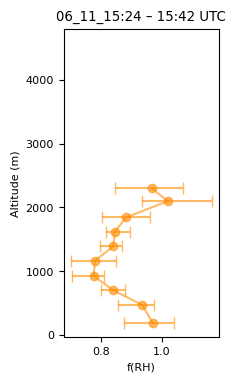

In [62]:
fig, ax = plt.subplots(figsize=(2, 4))
ax.errorbar(DAY11_subset_median['fRH550_RH20to80_ZIEMBA'], DAY11_subset_median['GPS_Altitude_THORNHILL'], xerr=[DAY11_subset_25['fRH550_RH20to80_ZIEMBA'], DAY11_subset_75['fRH550_RH20to80_ZIEMBA']], marker='o', linestyle='-', capsize=4, alpha=.6, color="darkorange", label = '>10nm')
ax.set_xlabel('f(RH)')
ax.set_ylabel('Altitude (m)')
#fig.suptitle('f(RH)', fontsize=16)
ax.set_title('06_11_15:24 – 15:42 UTC')

Text(0.5, 1.0, '06_11_15:24 – 15:42 UTC')

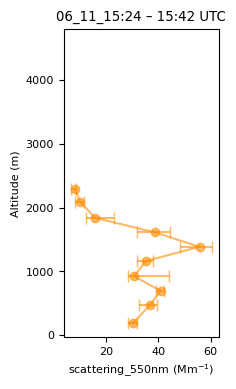

In [63]:
fig, ax = plt.subplots(figsize=(2, 4))
ax.errorbar(DAY11_subset_median['Sc550_submicron_amb_ZIEMBA'], DAY11_subset_median['GPS_Altitude_THORNHILL'], xerr=[DAY11_subset_25['Sc550_submicron_amb_ZIEMBA'], DAY11_subset_75['Sc550_submicron_amb_ZIEMBA']], marker='o', linestyle='-', capsize=4, alpha=.6, color="darkorange", label = '>10nm')
ax.set_xlabel('scattering_550nm (Mm$^{-1}$)')
ax.set_ylabel('Altitude (m)')
#fig.suptitle('f(RH)', fontsize=16)
ax.set_title('06_11_15:24 – 15:42 UTC')

Text(0.5, 1.0, '06_11_15:24 – 15:42 UTC')

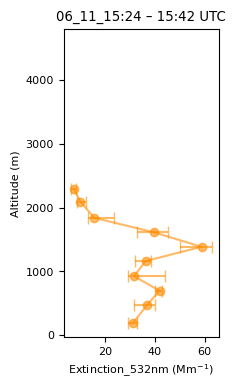

In [64]:
fig, ax = plt.subplots(figsize=(2, 4))
ax.errorbar(DAY11_subset_median['Ext532_submicron_amb_ZIEMBA'], DAY11_subset_median['GPS_Altitude_THORNHILL'], xerr=[DAY11_subset_25['Ext532_submicron_amb_ZIEMBA'], DAY11_subset_75['Ext532_submicron_amb_ZIEMBA']], marker='o', linestyle='-', capsize=4, alpha=.6, color="darkorange", label = '>10nm')
ax.set_xlabel('Extinction_532nm (Mm$^{-1}$)')
ax.set_ylabel('Altitude (m)')
#fig.suptitle('f(RH)', fontsize=16)
ax.set_title('06_11_15:24 – 15:42 UTC')

In [65]:
DAY11b = simple_read('C:/Users/taiwoajayi/Documents/Ozone/f(RH)/activate-mrg1_hu25_20220611_R0_L2_20230727T154853.ict')
start_index = np.where(DAY11b["Time_Start"]==pd.to_datetime("2022-06-11 20:08:00"))
stop_index = np.where(DAY11b["Time_Start"]==pd.to_datetime("2022-06-11 20:15:39"))
    
DAY11b_subset = DAY11b[start_index[0][0]:stop_index[0][0]]
DAY11b_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Static_Air_Temp_THORNHILL,Sc550_submicron_amb_ZIEMBA,Sc550_submicron_ZIEMBA,RH_Sc_submicron_ZIEMBA,Abs532_total_ZIEMBA,Ext532_submicron_amb_ZIEMBA,fRH550_RH20to80_ZIEMBA,SSA_550nm_ZIEMBA,SSA_amb_550nm_ZIEMBA
9830,2022-06-11 20:08:00,2022-06-11 20:08:01,31.216085,-64.640552,127.335,24.265,NaN,30.185,64.0,-0.270,NaN,NaN,NaN,NaN
9831,2022-06-11 20:08:01,2022-06-11 20:08:02,31.216703,-64.641627,125.935,24.310,NaN,28.315,64.0,-0.175,NaN,NaN,NaN,NaN
9832,2022-06-11 20:08:02,2022-06-11 20:08:03,31.217282,-64.642730,124.040,24.315,NaN,27.820,64.0,-0.465,NaN,NaN,NaN,NaN
9833,2022-06-11 20:08:03,2022-06-11 20:08:04,31.217824,-64.643860,121.770,24.340,NaN,28.645,64.0,-0.745,NaN,NaN,NaN,NaN
9834,2022-06-11 20:08:04,2022-06-11 20:08:05,31.218325,-64.645014,119.225,24.365,NaN,28.750,63.9,-0.705,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10284,2022-06-11 20:15:34,2022-06-11 20:15:35,31.204221,-64.650827,2831.710,9.030,NaN,1.575,40.8,-1.385,NaN,NaN,NaN,NaN
10285,2022-06-11 20:15:35,2022-06-11 20:15:36,31.203070,-64.651345,2823.550,9.080,NaN,1.135,40.8,3.965,NaN,NaN,NaN,NaN
10286,2022-06-11 20:15:36,2022-06-11 20:15:37,31.201921,-64.651869,2815.510,9.120,NaN,1.125,40.8,3.835,NaN,NaN,NaN,NaN
10287,2022-06-11 20:15:37,2022-06-11 20:15:38,31.200775,-64.652397,2808.060,9.170,NaN,1.305,40.8,1.575,NaN,NaN,NaN,NaN


In [66]:
nbins = 20
bins = np.linspace(DAY11b_subset.GPS_Altitude_THORNHILL.min(), DAY11b_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY11b_subset['Bins'] = pd.cut(DAY11b_subset['GPS_Altitude_THORNHILL'], bins)
DAY11b_subset_median = DAY11b_subset.groupby('Bins').median()
DAY11b_subset_median
DAY11b_subset_25 = DAY11b_subset_median - DAY11b_subset.groupby('Bins').quantile(.25)
DAY11b_subset_25
DAY11b_subset_75 = DAY11b_subset.groupby('Bins').quantile(.75) - DAY11b_subset_median
DAY11b_subset_75

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Static_Air_Temp_THORNHILL,Sc550_submicron_amb_ZIEMBA,Sc550_submicron_ZIEMBA,RH_Sc_submicron_ZIEMBA,Abs532_total_ZIEMBA,Ext532_submicron_amb_ZIEMBA,fRH550_RH20to80_ZIEMBA,SSA_550nm_ZIEMBA,SSA_amb_550nm_ZIEMBA
Bins,,,,,,,,,,,,,,
"(108.925, 261.267]",0 days 00:00:07.250000128,0 days 00:00:07.250000128,0.000770,0.010359,58.7275,0.09125,2.01000,1.80625,0.3000,0.91125,0.81125,0.08500,NaN,NaN
"(261.267, 413.609]",0 days 00:00:04.500000,0 days 00:00:04.500000,0.002125,0.004829,31.8250,0.06250,1.66250,1.83000,0.3500,0.84250,0.99000,0.11000,NaN,NaN
"(413.609, 565.952]",0 days 00:00:06.250000128,0 days 00:00:06.250000128,0.006338,0.001489,33.6925,0.22500,0.71500,3.99125,0.5250,0.28250,0.96500,0.05500,NaN,NaN
"(565.952, 718.294]",0 days 00:00:05.749999872,0 days 00:00:05.749999872,0.001687,0.006795,29.1200,0.08375,4.57625,4.10875,0.4750,2.73625,2.18500,0.17125,NaN,NaN
"(718.294, 870.636]",0 days 00:00:05,0 days 00:00:05,0.002913,0.004188,26.8000,0.22500,1.78500,0.94000,0.4000,1.22000,1.61000,0.11500,NaN,NaN
"(870.636, 1022.978]",0 days 00:00:05.250000128,0 days 00:00:05.250000128,0.005519,0.000637,28.8475,0.20500,1.91500,2.33375,0.2875,1.13250,1.95125,0.09375,NaN,NaN
"(1022.978, 1175.321]",0 days 00:00:04,0 days 00:00:04,0.002185,0.004282,34.8000,0.24500,1.25500,1.01000,0.3500,0.28500,1.24000,0.01000,NaN,NaN
"(1175.321, 1327.663]",0 days 00:00:04,0 days 00:00:04,0.001925,0.004800,32.9200,0.14500,0.92500,1.28000,0.3000,0.67500,1.52500,0.09500,NaN,NaN
"(1327.663, 1480.005]",0 days 00:00:03.749999872,0 days 00:00:03.749999872,0.003736,0.002654,42.1600,0.21250,1.08750,2.17625,0.2000,0.27500,1.04375,0.04875,NaN,NaN


Text(0.5, 1.0, '06_11_20:08 – 20:15:39 UTC')

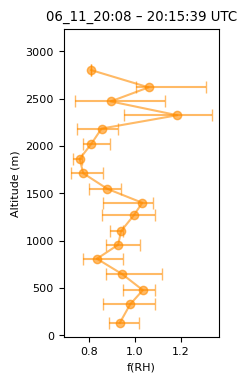

In [67]:
fig, ax = plt.subplots(figsize=(2, 4))
ax.errorbar(DAY11b_subset_median['fRH550_RH20to80_ZIEMBA'], DAY11b_subset_median['GPS_Altitude_THORNHILL'], xerr=[DAY11b_subset_25['fRH550_RH20to80_ZIEMBA'], DAY11b_subset_75['fRH550_RH20to80_ZIEMBA']], marker='o', linestyle='-', capsize=4, alpha=.6, color="darkorange", label = '>10nm')
ax.set_xlabel('f(RH)')
ax.set_ylabel('Altitude (m)')
#fig.suptitle('f(RH)', fontsize=16)
ax.set_title('06_11_20:08 – 20:15:39 UTC')

Text(0.5, 1.0, '06_11_20:08 – 20:15:39 UTC')

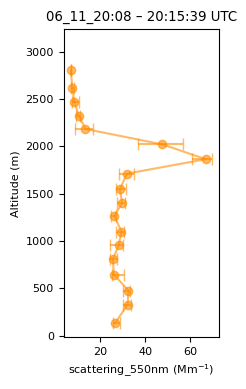

In [68]:
fig, ax = plt.subplots(figsize=(2, 4))
ax.errorbar(DAY11b_subset_median['Sc550_submicron_amb_ZIEMBA'], DAY11b_subset_median['GPS_Altitude_THORNHILL'], xerr=[DAY11b_subset_25['Sc550_submicron_amb_ZIEMBA'], DAY11b_subset_75['Sc550_submicron_amb_ZIEMBA']], marker='o', linestyle='-', capsize=4, alpha=.6, color="darkorange", label = '>10nm')
ax.set_xlabel('scattering_550nm (Mm$^{-1}$)')
ax.set_ylabel('Altitude (m)')
#fig.suptitle('f(RH)', fontsize=16)
ax.set_title('06_11_20:08 – 20:15:39 UTC')

Text(0.5, 1.0, '06_11_20:08 – 20:15:39 UTC')

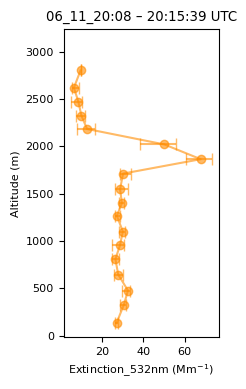

In [69]:
fig, ax = plt.subplots(figsize=(2, 4))
ax.errorbar(DAY11b_subset_median['Ext532_submicron_amb_ZIEMBA'], DAY11b_subset_median['GPS_Altitude_THORNHILL'], xerr=[DAY11b_subset_25['Ext532_submicron_amb_ZIEMBA'], DAY11b_subset_75['Ext532_submicron_amb_ZIEMBA']], marker='o', linestyle='-', capsize=4, alpha=.6, color="darkorange", label = '>10nm')
ax.set_xlabel('Extinction_532nm (Mm$^{-1}$)')
ax.set_ylabel('Altitude (m)')
#fig.suptitle('f(RH)', fontsize=16)
ax.set_title('06_11_20:08 – 20:15:39 UTC')

In [70]:
DAY13 = simple_read('C:/Users/taiwoajayi/Documents/Ozone/f(RH)/activate-mrg1_hu25_20220613_R0_L1_20230727T154853.ict')
start_index = np.where(DAY13["Time_Start"]==pd.to_datetime("2022-06-13 14:30:00"))
stop_index = np.where(DAY13["Time_Start"]==pd.to_datetime("2022-06-13 14:46:00"))
    
DAY13_subset = DAY13[start_index[0][0]:stop_index[0][0]]
DAY13_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Static_Air_Temp_THORNHILL,Sc550_submicron_amb_ZIEMBA,Sc550_submicron_ZIEMBA,RH_Sc_submicron_ZIEMBA,Abs532_total_ZIEMBA,Ext532_submicron_amb_ZIEMBA,fRH550_RH20to80_ZIEMBA,SSA_550nm_ZIEMBA,SSA_amb_550nm_ZIEMBA
10015,2022-06-13 14:30:00,2022-06-13 14:30:01,32.210354,-65.054053,141.795,23.865,9.180,8.535,60.40,-0.135,9.305,1.110,NaN,NaN
10016,2022-06-13 14:30:01,2022-06-13 14:30:02,32.209934,-65.052981,141.725,23.835,8.750,8.360,60.40,-0.450,8.550,1.080,NaN,NaN
10017,2022-06-13 14:30:02,2022-06-13 14:30:03,32.209541,-65.051894,141.615,23.830,9.355,8.750,60.35,-0.170,9.460,1.085,NaN,NaN
10018,2022-06-13 14:30:03,2022-06-13 14:30:04,32.209173,-65.050793,141.460,23.855,9.720,8.000,60.35,0.155,10.160,1.230,NaN,NaN
10019,2022-06-13 14:30:04,2022-06-13 14:30:05,32.208832,-65.049680,141.275,23.840,10.595,8.585,60.40,0.375,11.285,1.260,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10970,2022-06-13 14:45:55,2022-06-13 14:45:56,32.197220,-65.046274,4504.770,-0.020,NaN,1.520,32.80,6.245,NaN,NaN,0.21602,NaN
10971,2022-06-13 14:45:56,2022-06-13 14:45:57,32.196954,-65.044914,4514.670,-0.115,NaN,2.475,32.80,6.895,NaN,NaN,0.20603,NaN
10972,2022-06-13 14:45:57,2022-06-13 14:45:58,32.196726,-65.043543,4523.980,-0.215,NaN,1.985,32.80,7.010,NaN,NaN,0.20906,NaN
10973,2022-06-13 14:45:58,2022-06-13 14:45:59,32.196539,-65.042160,4532.940,-0.295,NaN,0.410,32.80,7.745,NaN,NaN,0.22361,NaN


In [71]:
nbins = 20
bins = np.linspace(DAY13_subset.GPS_Altitude_THORNHILL.min(), DAY13_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY13_subset['Bins'] = pd.cut(DAY13_subset['GPS_Altitude_THORNHILL'], bins)
DAY13_subset_median = DAY13_subset.groupby('Bins').median()
DAY13_subset_median
DAY13_subset_25 = DAY13_subset_median - DAY13_subset.groupby('Bins').quantile(.25)
DAY13_subset_25
DAY13_subset_75 = DAY13_subset.groupby('Bins').quantile(.75) - DAY13_subset_median
DAY13_subset_75

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Static_Air_Temp_THORNHILL,Sc550_submicron_amb_ZIEMBA,Sc550_submicron_ZIEMBA,RH_Sc_submicron_ZIEMBA,Abs532_total_ZIEMBA,Ext532_submicron_amb_ZIEMBA,fRH550_RH20to80_ZIEMBA,SSA_550nm_ZIEMBA,SSA_amb_550nm_ZIEMBA
Bins,,,,,,,,,,,,,,
"(138.195, 358.368]",0 days 00:00:28,0 days 00:00:28,0.030130,0.010359,112.47000,0.06000,1.48500,0.93500,0.1000,0.20000,1.61000,0.17000,NaN,NaN
"(358.368, 578.542]",0 days 00:00:14.250000128,0 days 00:00:14.250000128,0.002181,0.019058,54.09625,0.07875,1.57125,1.60625,0.7125,0.42875,1.63875,0.14250,NaN,NaN
"(578.542, 798.715]",0 days 00:00:14.749999872,0 days 00:00:14.749999872,0.016774,0.006472,62.55000,0.37500,5.34500,4.66250,1.1875,0.39375,5.74750,0.20375,NaN,NaN
"(798.715, 1018.888]",0 days 00:00:14.250000128,0 days 00:00:14.250000128,0.003778,0.018661,48.48500,0.27125,1.25125,1.41750,0.2500,0.43875,1.50250,0.11375,NaN,NaN
"(1018.888, 1239.061]",0 days 00:00:16.250000128,0 days 00:00:16.250000128,0.017967,0.003437,41.75000,0.24125,7.68000,6.95375,0.4250,0.43375,6.85000,0.05000,0.000500,0.00000
"(1239.061, 1459.234]",0 days 00:00:18,0 days 00:00:18,0.003568,0.024420,38.70000,0.11500,5.69500,6.24000,0.6000,0.51000,4.68000,0.03500,0.001500,0.00150
"(1459.234, 1679.408]",0 days 00:00:18.250000128,0 days 00:00:18.250000128,0.020121,0.018396,55.16250,0.56500,2.36000,2.00000,0.6500,0.58500,2.02125,0.04000,0.004125,0.00400
"(1679.408, 1899.581]",0 days 00:00:17.749999872,0 days 00:00:17.749999872,0.017841,0.012524,60.04750,0.45750,1.37750,1.48000,0.0000,0.46750,1.85125,0.04875,0.001250,0.00100
"(1899.581, 2119.754]",0 days 00:00:18.500000,0 days 00:00:18.500000,0.006497,0.016531,66.25000,0.13500,4.92750,5.51000,0.2000,0.49750,5.22250,0.06500,NaN,NaN


Text(0.5, 1.0, '06_13_14:30 – 14:46 UTC')

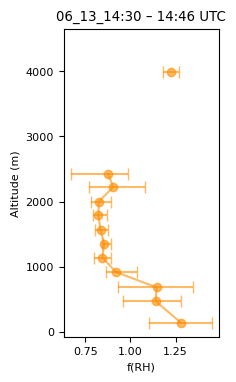

In [72]:
fig, ax = plt.subplots(figsize=(2, 4))
ax.errorbar(DAY13_subset_median['fRH550_RH20to80_ZIEMBA'], DAY13_subset_median['GPS_Altitude_THORNHILL'], xerr=[DAY13_subset_25['fRH550_RH20to80_ZIEMBA'], DAY13_subset_75['fRH550_RH20to80_ZIEMBA']], marker='o', linestyle='-', capsize=4, alpha=.6, color="darkorange", label = '>10nm')
ax.set_xlabel('f(RH)')
ax.set_ylabel('Altitude (m)')
#fig.suptitle('f(RH)', fontsize=16)
ax.set_title('06_13_14:30 – 14:46 UTC')

Text(0.5, 1.0, '06_13_14:30 – 14:46 UTC')

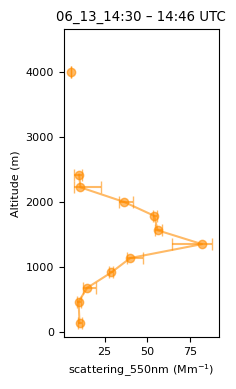

In [73]:
fig, ax = plt.subplots(figsize=(2, 4))
ax.errorbar(DAY13_subset_median['Sc550_submicron_amb_ZIEMBA'], DAY13_subset_median['GPS_Altitude_THORNHILL'], xerr=[DAY13_subset_25['Sc550_submicron_amb_ZIEMBA'], DAY13_subset_75['Sc550_submicron_amb_ZIEMBA']], marker='o', linestyle='-', capsize=4, alpha=.6, color="darkorange", label = '>10nm')
ax.set_xlabel('scattering_550nm (Mm$^{-1}$)')
ax.set_ylabel('Altitude (m)')
#fig.suptitle('f(RH)', fontsize=16)
ax.set_title('06_13_14:30 – 14:46 UTC')

Text(0.5, 1.0, '06_13_14:30 – 14:46 UTC')

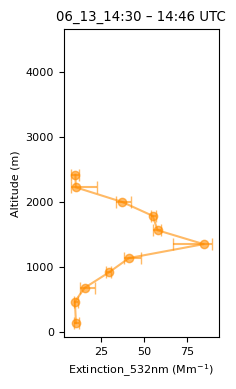

In [74]:
fig, ax = plt.subplots(figsize=(2, 4))
ax.errorbar(DAY13_subset_median['Ext532_submicron_amb_ZIEMBA'], DAY13_subset_median['GPS_Altitude_THORNHILL'], xerr=[DAY13_subset_25['Ext532_submicron_amb_ZIEMBA'], DAY13_subset_75['Ext532_submicron_amb_ZIEMBA']], marker='o', linestyle='-', capsize=4, alpha=.6, color="darkorange", label = '>10nm')
ax.set_xlabel('Extinction_532nm (Mm$^{-1}$)')
ax.set_ylabel('Altitude (m)')
#fig.suptitle('f(RH)', fontsize=16)
ax.set_title('06_13_14:30 – 14:46 UTC')

In [75]:
DAY13b = simple_read('C:/Users/taiwoajayi/Documents/Ozone/f(RH)/activate-mrg1_hu25_20220613_R0_L2_20230727T154853.ict')
start_index = np.where(DAY13b["Time_Start"]==pd.to_datetime("2022-06-13 19:46:00"))
stop_index = np.where(DAY13b["Time_Start"]==pd.to_datetime("2022-06-13 20:09:00")) 
DAY13b_subset = DAY13b[start_index[0][0]:stop_index[0][0]]
DAY13b_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Static_Air_Temp_THORNHILL,Sc550_submicron_amb_ZIEMBA,Sc550_submicron_ZIEMBA,RH_Sc_submicron_ZIEMBA,Abs532_total_ZIEMBA,Ext532_submicron_amb_ZIEMBA,fRH550_RH20to80_ZIEMBA,SSA_550nm_ZIEMBA,SSA_amb_550nm_ZIEMBA
10610,2022-06-13 19:46:00,2022-06-13 19:46:01,32.251226,-65.007304,106.13,24.700,NaN,7.265,62.8,0.090,NaN,NaN,NaN,NaN
10611,2022-06-13 19:46:01,2022-06-13 19:46:02,32.250414,-65.006555,105.59,24.680,NaN,7.045,62.8,-0.005,NaN,NaN,NaN,NaN
10612,2022-06-13 19:46:02,2022-06-13 19:46:03,32.249605,-65.005808,106.45,24.620,NaN,8.045,62.8,0.240,NaN,NaN,NaN,NaN
10613,2022-06-13 19:46:03,2022-06-13 19:46:04,32.248799,-65.005062,108.91,24.565,NaN,8.455,62.9,-0.305,NaN,NaN,NaN,NaN
10614,2022-06-13 19:46:04,2022-06-13 19:46:05,32.247996,-65.004323,112.60,24.550,NaN,8.765,62.9,-1.050,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11985,2022-06-13 20:08:55,2022-06-13 20:08:56,32.290180,-64.996666,4558.09,0.615,NaN,0.790,30.6,5.280,NaN,NaN,NaN,NaN
11986,2022-06-13 20:08:56,2022-06-13 20:08:57,32.289203,-64.997413,4565.53,0.565,NaN,0.790,30.6,6.150,NaN,NaN,NaN,NaN
11987,2022-06-13 20:08:57,2022-06-13 20:08:58,32.288204,-64.998124,4572.98,0.505,NaN,0.970,30.6,8.185,NaN,NaN,NaN,NaN
11988,2022-06-13 20:08:58,2022-06-13 20:08:59,32.287185,-64.998799,4580.36,0.450,NaN,0.305,30.5,8.685,NaN,NaN,NaN,NaN


In [76]:
nbins = 20
bins = np.linspace(DAY13b_subset.GPS_Altitude_THORNHILL.min(), DAY13b_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY13b_subset['Bins'] = pd.cut(DAY13b_subset['GPS_Altitude_THORNHILL'], bins)
DAY13b_subset_median = DAY13b_subset.groupby('Bins').median()
DAY13b_subset_median
DAY13b_subset_25 = DAY13b_subset_median - DAY13b_subset.groupby('Bins').quantile(.25)
DAY13b_subset_25
DAY13b_subset_75 = DAY13b_subset.groupby('Bins').quantile(.75) - DAY13b_subset_median
DAY13b_subset_75

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Static_Air_Temp_THORNHILL,Sc550_submicron_amb_ZIEMBA,Sc550_submicron_ZIEMBA,RH_Sc_submicron_ZIEMBA,Abs532_total_ZIEMBA,Ext532_submicron_amb_ZIEMBA,fRH550_RH20to80_ZIEMBA,SSA_550nm_ZIEMBA,SSA_amb_550nm_ZIEMBA
Bins,,,,,,,,,,,,,,
"(105.59, 329.686]",0 days 00:00:25.250000128,0 days 00:00:25.250000128,0.010465,0.025778,85.43875,0.47625,1.12000,1.39000,0.0000,0.24750,1.34500,0.22000,NaN,NaN
"(329.686, 553.781]",0 days 00:00:15.749999872,0 days 00:00:15.749999872,0.002415,0.014763,57.57375,0.46500,NaN,0.93250,0.6000,0.39500,NaN,NaN,NaN,NaN
"(553.781, 777.876]",0 days 00:00:16.500000,0 days 00:00:16.500000,0.015576,0.006068,56.09750,0.20750,0.49625,0.93250,0.4750,0.37500,0.57125,0.12875,NaN,NaN
"(777.876, 1001.972]",0 days 00:00:17.250000128,0 days 00:00:17.250000128,0.018314,0.004672,49.19125,0.11250,3.63500,3.46625,1.2500,1.20250,3.04250,0.10500,NaN,NaN
"(1001.972, 1226.067]",0 days 00:00:14,0 days 00:00:14,0.002129,0.015698,56.45000,0.17000,10.29500,11.51000,0.7500,0.82000,8.55500,0.09000,NaN,NaN
"(1226.067, 1450.163]",0 days 00:00:20,0 days 00:00:20,0.020834,0.007982,65.12000,0.15000,3.01500,2.79000,0.8000,0.39000,3.85000,0.05000,0.000500,0.000750
"(1450.163, 1674.258]",0 days 00:00:33.749999872,0 days 00:00:33.749999872,0.031172,0.014914,58.66000,0.10625,6.65000,7.30375,1.2000,0.65500,6.54500,0.04125,0.001500,0.000625
"(1674.258, 1898.354]",0 days 00:00:44.500000,0 days 00:00:44.500000,0.022624,0.036494,63.18000,0.07250,9.73250,12.47000,0.2000,0.55750,9.61500,0.04000,0.001000,0.001000
"(1898.354, 2122.449]",0 days 00:00:39.250000128,0 days 00:00:39.250000128,0.025898,0.031207,64.71000,0.29500,13.77750,13.61500,0.4375,0.52000,13.60500,0.03000,0.001000,0.000500


Text(0.5, 1.0, '06_13_19:46 – 20:09 UTC')

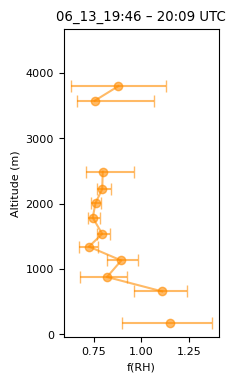

In [77]:
fig, ax = plt.subplots(figsize=(2, 4))
ax.errorbar(DAY13b_subset_median['fRH550_RH20to80_ZIEMBA'], DAY13b_subset_median['GPS_Altitude_THORNHILL'], xerr=[DAY13b_subset_25['fRH550_RH20to80_ZIEMBA'], DAY13b_subset_75['fRH550_RH20to80_ZIEMBA']], marker='o', linestyle='-', capsize=4, alpha=.6, color="darkorange", label = '>10nm')
ax.set_xlabel('f(RH)')
ax.set_ylabel('Altitude (m)')
#fig.suptitle('f(RH)', fontsize=16)
ax.set_title('06_13_19:46 – 20:09 UTC')

Text(0.5, 1.0, '06_13_19:46 – 20:09 UTC')

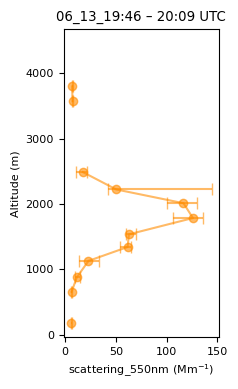

In [78]:
fig, ax = plt.subplots(figsize=(2, 4))
ax.errorbar(DAY13b_subset_median['Sc550_submicron_amb_ZIEMBA'], DAY13b_subset_median['GPS_Altitude_THORNHILL'], xerr=[DAY13b_subset_25['Sc550_submicron_amb_ZIEMBA'], DAY13b_subset_75['Sc550_submicron_amb_ZIEMBA']], marker='o', linestyle='-', capsize=4, alpha=.6, color="darkorange", label = '>10nm')
ax.set_xlabel('scattering_550nm (Mm$^{-1}$)')
ax.set_ylabel('Altitude (m)')
#fig.suptitle('f(RH)', fontsize=16)
ax.set_title('06_13_19:46 – 20:09 UTC')

In [79]:
2.55**2

6.5024999999999995

In [80]:
1.19625E5/688.44

173.76241938295274

Text(0.5, 1.0, '06_13_19:46 – 20:09 UTC')

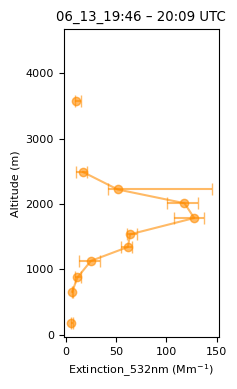

In [81]:
fig, ax = plt.subplots(figsize=(2, 4))
ax.errorbar(DAY13b_subset_median['Ext532_submicron_amb_ZIEMBA'], DAY13b_subset_median['GPS_Altitude_THORNHILL'], xerr=[DAY13b_subset_25['Ext532_submicron_amb_ZIEMBA'], DAY13b_subset_75['Ext532_submicron_amb_ZIEMBA']], marker='o', linestyle='-', capsize=4, alpha=.6, color="darkorange", label = '>10nm')
ax.set_xlabel('Extinction_532nm (Mm$^{-1}$)')
ax.set_ylabel('Altitude (m)')
ax.set_title('06_13_19:46 – 20:09 UTC')

In [82]:
DAY14 = simple_read('C:/Users/taiwoajayi/Documents/Ozone/f(RH)/activate-mrg1_hu25_20220614_R0_20230727T154854.ict')
start_index = np.where(DAY14["Time_Start"]==pd.to_datetime("2022-06-14 16:05:00"))
stop_index = np.where(DAY14["Time_Start"]==pd.to_datetime("2022-06-14 16:25:00"))
DAY14_subset = DAY14[start_index[0][0]:stop_index[0][0]]
DAY14_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Static_Air_Temp_THORNHILL,Sc550_submicron_amb_ZIEMBA,Sc550_submicron_ZIEMBA,RH_Sc_submicron_ZIEMBA,Abs532_total_ZIEMBA,Ext532_submicron_amb_ZIEMBA,fRH550_RH20to80_ZIEMBA,SSA_550nm_ZIEMBA,SSA_amb_550nm_ZIEMBA
9363,2022-06-14 16:05:00,2022-06-14 16:05:01,30.642555,-64.394685,117.000,25.355,NaN,13.505,62.5,0.590,NaN,NaN,NaN,NaN
9364,2022-06-14 16:05:01,2022-06-14 16:05:02,30.641725,-64.395343,117.085,25.370,NaN,12.035,62.5,0.290,NaN,NaN,NaN,NaN
9365,2022-06-14 16:05:02,2022-06-14 16:05:03,30.640923,-64.396042,117.190,25.370,NaN,10.200,62.5,0.545,NaN,NaN,NaN,NaN
9366,2022-06-14 16:05:03,2022-06-14 16:05:04,30.640148,-64.396780,117.295,25.345,NaN,9.905,62.5,0.615,NaN,NaN,NaN,NaN
9367,2022-06-14 16:05:04,2022-06-14 16:05:05,30.639403,-64.397555,117.380,25.375,NaN,11.545,62.5,-0.365,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10558,2022-06-14 16:24:55,2022-06-14 16:24:56,30.850057,-64.439182,8454.590,-26.050,9.2,9.720,25.7,7.200,15.95,0.35,0.6160,0.6520
10559,2022-06-14 16:24:56,2022-06-14 16:24:57,30.851471,-64.439393,8461.000,-26.100,NaN,7.810,25.7,6.480,NaN,NaN,0.6200,0.6550
10560,2022-06-14 16:24:57,2022-06-14 16:24:58,30.852885,-64.439595,8467.420,-26.180,NaN,4.775,25.7,4.790,NaN,NaN,0.6115,0.6505
10561,2022-06-14 16:24:58,2022-06-14 16:24:59,30.854300,-64.439786,8473.860,-26.260,NaN,2.875,25.7,4.150,NaN,NaN,0.5965,0.6440


In [83]:
nbins = 20
bins = np.linspace(DAY14_subset.GPS_Altitude_THORNHILL.min(), DAY14_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY14_subset['Bins'] = pd.cut(DAY14_subset['GPS_Altitude_THORNHILL'], bins)
DAY14_subset_median = DAY14_subset.groupby('Bins').median()
DAY14_subset_median
DAY14_subset_25 = DAY14_subset_median - DAY14_subset.groupby('Bins').quantile(.25)
DAY14_subset_25
DAY14_subset_75 = DAY14_subset.groupby('Bins').quantile(.75) - DAY14_subset_median
DAY14_subset_75

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Static_Air_Temp_THORNHILL,Sc550_submicron_amb_ZIEMBA,Sc550_submicron_ZIEMBA,RH_Sc_submicron_ZIEMBA,Abs532_total_ZIEMBA,Ext532_submicron_amb_ZIEMBA,fRH550_RH20to80_ZIEMBA,SSA_550nm_ZIEMBA,SSA_amb_550nm_ZIEMBA
Bins,,,,,,,,,,,,,,
"(117.0, 535.166]",0 days 00:00:20,0 days 00:00:20,0.016945,0.020369,158.20500,0.84500,1.9650,1.24000,0.5000,0.58500,1.27625,0.15625,NaN,NaN
"(535.166, 953.333]",0 days 00:00:13.250000128,0 days 00:00:13.250000128,0.002846,0.013087,97.72375,0.56625,5.2725,4.21500,1.1625,0.65500,5.27250,0.11375,NaN,NaN
"(953.333, 1371.5]",0 days 00:00:11.749999872,0 days 00:00:11.749999872,0.008928,0.007774,104.64000,0.77000,2.0975,2.78875,0.9000,0.89250,3.18500,0.06625,NaN,NaN
"(1371.5, 1789.666]",0 days 00:00:11.749999872,0 days 00:00:11.749999872,0.012780,0.004222,102.78000,0.51875,1.5175,2.55875,0.9000,0.68500,1.36000,0.06750,NaN,NaN
"(1789.666, 2207.832]",0 days 00:00:11.500000,0 days 00:00:11.500000,0.002138,0.014201,100.31500,0.85500,12.3150,12.50500,0.5000,0.53750,11.56000,0.13000,NaN,NaN
"(2207.832, 2625.999]",0 days 00:00:12.250000128,0 days 00:00:12.250000128,0.013057,0.002912,116.56250,0.77625,2.1500,4.54750,0.5250,0.59875,2.46250,0.13125,NaN,NaN
"(2625.999, 3044.166]",0 days 00:00:12.749999872,0 days 00:00:12.749999872,0.013603,0.012794,84.36000,0.65250,NaN,1.03125,0.5625,0.85750,NaN,NaN,NaN,NaN
"(3044.166, 3462.332]",0 days 00:00:12,0 days 00:00:12,0.002493,0.016610,94.40000,0.45500,NaN,0.51000,0.6000,1.46500,NaN,NaN,NaN,NaN
"(3462.332, 3880.498]",0 days 00:00:13.500000,0 days 00:00:13.500000,0.015262,0.003727,108.68500,0.79000,NaN,0.57000,0.6500,0.75500,NaN,NaN,0.082300,NaN


Text(0.5, 1.0, '06_14_16:05 – 16:25 UTC')

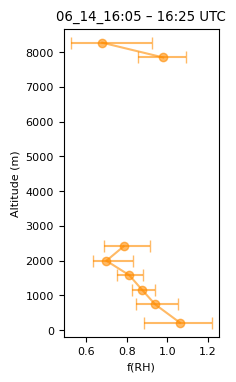

In [84]:
fig, ax = plt.subplots(figsize=(2, 4))
ax.errorbar(DAY14_subset_median['fRH550_RH20to80_ZIEMBA'], DAY14_subset_median['GPS_Altitude_THORNHILL'], xerr=[DAY14_subset_25['fRH550_RH20to80_ZIEMBA'], DAY14_subset_75['fRH550_RH20to80_ZIEMBA']], marker='o', linestyle='-', capsize=4, alpha=.6, color="darkorange", label = '>10nm')
ax.set_xlabel('f(RH)')
ax.set_ylabel('Altitude (m)')
ax.set_title('06_14_16:05 – 16:25 UTC')

Text(0.5, 1.0, '06_14_16:05 – 16:25 UTC')

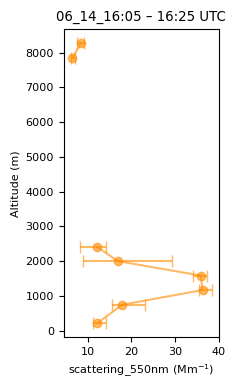

In [85]:
fig, ax = plt.subplots(figsize=(2, 4))
ax.errorbar(DAY14_subset_median['Sc550_submicron_amb_ZIEMBA'], DAY14_subset_median['GPS_Altitude_THORNHILL'], xerr=[DAY14_subset_25['Sc550_submicron_amb_ZIEMBA'], DAY14_subset_75['Sc550_submicron_amb_ZIEMBA']], marker='o', linestyle='-', capsize=4, alpha=.6, color="darkorange", label = '>10nm')
ax.set_xlabel('scattering_550nm (Mm$^{-1}$)')
ax.set_ylabel('Altitude (m)')
#fig.suptitle('f(RH)', fontsize=16)
ax.set_title('06_14_16:05 – 16:25 UTC')

Text(0.5, 1.0, '06_14_16:05 – 16:25 UTC')

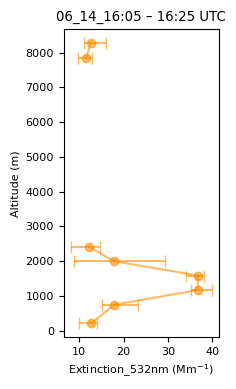

In [86]:
fig, ax = plt.subplots(figsize=(2, 4))
ax.errorbar(DAY14_subset_median['Ext532_submicron_amb_ZIEMBA'], DAY14_subset_median['GPS_Altitude_THORNHILL'], xerr=[DAY14_subset_25['Ext532_submicron_amb_ZIEMBA'], DAY14_subset_75['Ext532_submicron_amb_ZIEMBA']], marker='o', linestyle='-', capsize=4, alpha=.6, color="darkorange", label = '>10nm')
ax.set_xlabel('Extinction_532nm (Mm$^{-1}$)')
ax.set_ylabel('Altitude (m)')
#fig.suptitle('f(RH)', fontsize=16)
ax.set_title('06_14_16:05 – 16:25 UTC')

In [87]:
DAY17 = simple_read('C:/Users/taiwoajayi/Documents/Ozone/f(RH)/activate-mrg1_hu25_20220617_R0_20230727T154854.ict')
start_index = np.where(DAY17["Time_Start"]==pd.to_datetime("2022-06-17 16:20:00"))
stop_index = np.where(DAY17["Time_Start"]==pd.to_datetime("2022-06-17 16:47:00")) 
DAY17_subset = DAY17[start_index[0][0]:stop_index[0][0]]
DAY17_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Static_Air_Temp_THORNHILL,Sc550_submicron_amb_ZIEMBA,Sc550_submicron_ZIEMBA,RH_Sc_submicron_ZIEMBA,Abs532_total_ZIEMBA,Ext532_submicron_amb_ZIEMBA,fRH550_RH20to80_ZIEMBA,SSA_550nm_ZIEMBA,SSA_amb_550nm_ZIEMBA
10469,2022-06-17 16:20:00,2022-06-17 16:20:01,32.206574,-65.006772,134.100,21.905,14.935,13.165,50.40,0.055,14.875,1.525,NaN,NaN
10470,2022-06-17 16:20:01,2022-06-17 16:20:02,32.206131,-65.005761,133.795,21.935,15.045,13.780,50.55,0.765,15.700,1.365,NaN,NaN
10471,2022-06-17 16:20:02,2022-06-17 16:20:03,32.205725,-65.004728,133.485,21.940,15.455,14.870,50.55,1.340,16.685,1.180,NaN,NaN
10472,2022-06-17 16:20:03,2022-06-17 16:20:04,32.205357,-65.003676,133.170,21.930,14.330,14.235,50.50,0.855,15.095,1.025,NaN,NaN
10473,2022-06-17 16:20:04,2022-06-17 16:20:05,32.205027,-65.002606,132.825,21.950,13.950,14.175,50.50,-1.390,12.480,0.935,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12084,2022-06-17 16:46:55,2022-06-17 16:46:56,32.158601,-65.020304,7639.050,-17.335,NaN,1.235,25.20,15.920,NaN,NaN,NaN,NaN
12085,2022-06-17 16:46:56,2022-06-17 16:46:57,32.157293,-65.019563,7645.810,-17.400,NaN,1.015,25.30,11.905,NaN,NaN,NaN,NaN
12086,2022-06-17 16:46:57,2022-06-17 16:46:58,32.156002,-65.018778,7652.610,-17.450,NaN,0.930,25.30,12.900,NaN,NaN,NaN,NaN
12087,2022-06-17 16:46:58,2022-06-17 16:46:59,32.154729,-65.017953,7659.440,-17.510,NaN,0.950,25.30,18.000,NaN,NaN,NaN,NaN


In [88]:
nbins = 20
bins = np.linspace(DAY17_subset.GPS_Altitude_THORNHILL.min(), DAY17_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY17_subset['Bins'] = pd.cut(DAY17_subset['GPS_Altitude_THORNHILL'], bins)
DAY17_subset_median = DAY17_subset.groupby('Bins').median()
DAY17_subset_median
DAY17_subset_25 = DAY17_subset_median - DAY17_subset.groupby('Bins').quantile(.25)
DAY17_subset_25
DAY17_subset_75 = DAY17_subset.groupby('Bins').quantile(.75) - DAY17_subset_median
DAY17_subset_75

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Static_Air_Temp_THORNHILL,Sc550_submicron_amb_ZIEMBA,Sc550_submicron_ZIEMBA,RH_Sc_submicron_ZIEMBA,Abs532_total_ZIEMBA,Ext532_submicron_amb_ZIEMBA,fRH550_RH20to80_ZIEMBA,SSA_550nm_ZIEMBA,SSA_amb_550nm_ZIEMBA
Bins,,,,,,,,,,,,,,
"(124.73, 501.808]",0 days 00:00:41.250000128,0 days 00:00:41.250000128,0.018728,0.016713,128.98125,0.89625,1.17625,1.05375,0.525,0.57125,1.42125,0.24000,NaN,NaN
"(501.808, 878.885]",0 days 00:00:26,0 days 00:00:26,0.008572,0.010748,98.45000,0.65000,1.88000,1.08000,0.300,0.57000,2.05500,0.22500,NaN,NaN
"(878.885, 1255.962]",0 days 00:01:18.500000,0 days 00:01:18.500000,0.021372,0.023681,1.42000,0.36500,7.41000,3.54000,1.800,0.59750,7.04000,0.22000,0.000000,0.000000
"(1255.962, 1633.04]",0 days 00:00:33.250000128,0 days 00:00:33.250000128,0.035941,0.022201,88.02500,0.50500,2.83875,2.13750,0.200,0.51625,3.41375,0.23500,NaN,NaN
"(1633.04, 2010.117]",0 days 00:00:32.500000,0 days 00:00:32.500000,0.013719,0.036169,96.44000,2.26750,3.29250,4.02500,0.800,1.86000,7.41750,0.23750,0.021942,NaN
"(2010.117, 2387.195]",0 days 00:00:22.749999872,0 days 00:00:22.749999872,0.022723,0.008771,97.94000,0.39750,NaN,0.94375,1.200,0.78000,NaN,NaN,0.033500,NaN
"(2387.195, 2764.272]",0 days 00:00:14,0 days 00:00:14,0.003043,0.018270,99.41000,0.26500,NaN,0.74500,0.400,0.60000,NaN,NaN,0.029375,NaN
"(2764.272, 3141.35]",0 days 00:00:13,0 days 00:00:13,0.013954,0.013775,91.98000,0.50500,0.65500,1.73000,0.250,0.84000,1.86500,0.21500,0.032375,0.053875
"(3141.35, 3518.428]",0 days 00:00:12,0 days 00:00:12,0.011488,0.008179,87.37000,0.36500,0.27000,1.50500,0.200,0.99500,0.00000,0.28500,0.158250,0.069500


Text(0.5, 1.0, '06_17_16:20 – 16:47 UTC')

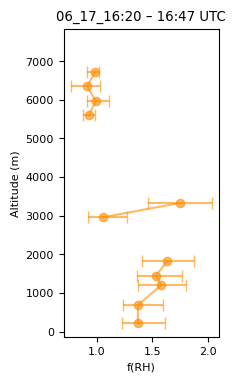

In [89]:
fig, ax = plt.subplots(figsize=(2, 4))
ax.errorbar(DAY17_subset_median['fRH550_RH20to80_ZIEMBA'], DAY17_subset_median['GPS_Altitude_THORNHILL'], xerr=[DAY17_subset_25['fRH550_RH20to80_ZIEMBA'], DAY17_subset_75['fRH550_RH20to80_ZIEMBA']], marker='o', linestyle='-', capsize=4, alpha=.6, color="darkorange", label = '>10nm')
ax.set_xlabel('f(RH)')
ax.set_ylabel('Altitude (m)')
#fig.suptitle('f(RH)', fontsize=16)
ax.set_title('06_17_16:20 – 16:47 UTC')

Text(0.5, 1.0, '06_17_16:20 – 16:47 UTC')

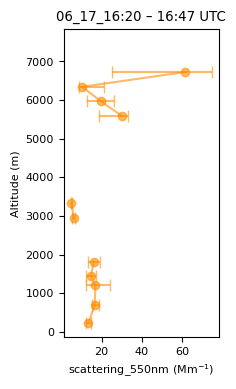

In [90]:
fig, ax = plt.subplots(figsize=(2, 4))
ax.errorbar(DAY17_subset_median['Sc550_submicron_amb_ZIEMBA'], DAY17_subset_median['GPS_Altitude_THORNHILL'], xerr=[DAY17_subset_25['Sc550_submicron_amb_ZIEMBA'], DAY17_subset_75['Sc550_submicron_amb_ZIEMBA']], marker='o', linestyle='-', capsize=4, alpha=.6, color="darkorange", label = '>10nm')
ax.set_xlabel('scattering_550nm (Mm$^{-1}$)')
ax.set_ylabel('Altitude (m)')
#fig.suptitle('f(RH)', fontsize=16)
ax.set_title('06_17_16:20 – 16:47 UTC')

Text(0.5, 1.0, '06_17_16:20 – 16:47 UTC')

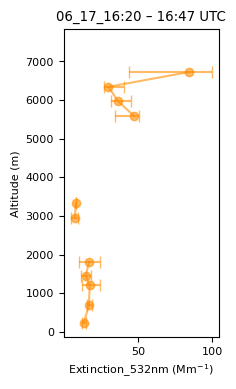

In [91]:
fig, ax = plt.subplots(figsize=(2, 4))
ax.errorbar(DAY17_subset_median['Ext532_submicron_amb_ZIEMBA'], DAY17_subset_median['GPS_Altitude_THORNHILL'], xerr=[DAY17_subset_25['Ext532_submicron_amb_ZIEMBA'], DAY17_subset_75['Ext532_submicron_amb_ZIEMBA']], marker='o', linestyle='-', capsize=4, alpha=.6, color="darkorange", label = '>10nm')
ax.set_xlabel('Extinction_532nm (Mm$^{-1}$)')
ax.set_ylabel('Altitude (m)')
#fig.suptitle('f(RH)', fontsize=16)
ax.set_title('06_17_16:20 – 16:47 UTC')

In [92]:
nbins = 100
bins_1000 = np.linspace(DAY22_subset.GPS_Altitude_THORNHILL.min(), DAY22_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY22_subset['Bins'] = pd.cut(DAY22_subset['GPS_Altitude_THORNHILL'], bins_1000)
DAY22_subset_1000 = DAY22_subset.groupby('Bins').median()
#locating the altitude of the spiral
start_altitude = 0
stop_altitude = 1000

start_index = np.where(DAY22_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY22_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY1000_subset_1000a = DAY22_subset_1000[start_index:stop_index]
DAY1000_subset_1000a

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Static_Air_Temp_THORNHILL,Sc550_submicron_amb_ZIEMBA,Sc550_submicron_ZIEMBA,RH_Sc_submicron_ZIEMBA,Abs532_total_ZIEMBA,Ext532_submicron_amb_ZIEMBA,fRH550_RH20to80_ZIEMBA,SSA_550nm_ZIEMBA,SSA_amb_550nm_ZIEMBA
Bins,,,,,,,,,,,,,,
"(105.985, 143.17]",2022-06-02 12:59:00.500,2022-06-02 12:59:01.500,32.903514,-69.411194,113.9000,24.0675,16.4675,14.5850,57.150,0.2825,17.2750,1.3050,NaN,NaN
"(143.17, 180.354]",2022-06-02 12:59:09.500,2022-06-02 12:59:10.500,32.907635,-69.400132,160.4275,23.4350,16.0425,13.0375,57.000,0.8875,17.8450,1.4475,NaN,NaN
"(180.354, 217.539]",2022-06-02 12:59:14.500,2022-06-02 12:59:15.500,32.910235,-69.394203,199.8250,23.1725,17.0175,14.7375,56.800,0.3800,18.0325,1.2525,NaN,NaN
"(217.539, 254.723]",2022-06-02 12:59:20.500,2022-06-02 12:59:21.500,32.914346,-69.387850,234.4575,22.8075,16.6600,14.6250,56.625,-0.3050,17.3300,1.2400,NaN,NaN
"(254.723, 291.908]",2022-06-02 12:59:26.000,2022-06-02 12:59:27.000,32.919085,-69.383209,276.6850,22.4650,17.1050,14.9700,56.600,0.3000,17.8400,1.2000,NaN,NaN
"(291.908, 329.092]",2022-06-02 12:59:32.000,2022-06-02 12:59:33.000,32.925125,-69.379793,304.7050,22.2450,16.3950,15.0500,56.400,-0.3050,16.6850,1.3150,NaN,NaN
"(329.092, 366.277]",2022-06-02 12:59:37.000,2022-06-02 12:59:38.000,32.930599,-69.378595,345.2250,21.8350,16.4250,16.2000,56.300,-0.2000,16.9950,1.0100,NaN,NaN
"(366.277, 403.461]",2022-06-02 12:59:40.500,2022-06-02 12:59:41.500,32.934451,-69.378665,383.8625,21.6475,18.3700,14.3675,56.100,0.4475,19.5200,1.3975,NaN,NaN
"(403.461, 440.646]",2022-06-02 12:59:45.500,2022-06-02 12:59:46.500,32.939847,-69.379819,420.9575,21.5525,15.4650,12.8175,55.825,-1.6625,14.5675,1.4425,NaN,NaN


In [93]:
#locating the altitude of the spiral
start_altitude = 1001
stop_altitude = 3500

start_index = np.where(DAY22_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY22_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY3000_subset_3000a = DAY22_subset_1000[start_index:stop_index]
DAY3000_subset_3000a

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Static_Air_Temp_THORNHILL,Sc550_submicron_amb_ZIEMBA,Sc550_submicron_ZIEMBA,RH_Sc_submicron_ZIEMBA,Abs532_total_ZIEMBA,Ext532_submicron_amb_ZIEMBA,fRH550_RH20to80_ZIEMBA,SSA_550nm_ZIEMBA,SSA_amb_550nm_ZIEMBA
Bins,,,,,,,,,,,,,,
"(998.414, 1035.599]",2022-06-02 13:00:58.500,2022-06-02 13:00:59.500,32.926077,-69.440875,1020.465,17.6600,12.4275,9.7175,50.75,-0.410,12.3675,1.4875,NaN,NaN
"(1035.599, 1072.783]",2022-06-02 13:01:03.000,2022-06-02 13:01:04.000,32.921032,-69.439333,1057.400,17.9000,11.2050,9.2750,50.50,-2.535,9.0650,1.6700,NaN,NaN
"(1072.783, 1109.968]",2022-06-02 13:01:08.000,2022-06-02 13:01:09.000,32.915694,-69.436460,1089.620,17.6250,11.9250,11.4750,50.20,-1.715,11.1200,1.1400,NaN,NaN
"(1109.968, 1147.152]",2022-06-02 13:01:13.000,2022-06-02 13:01:14.000,32.910879,-69.432361,1128.500,17.4750,12.2500,12.1300,49.90,-0.570,12.3300,1.1700,NaN,NaN
"(1147.152, 1184.337]",2022-06-02 13:01:17.500,2022-06-02 13:01:18.500,32.907172,-69.427752,1167.055,17.2325,11.8300,11.1975,49.45,-0.130,12.2700,1.2700,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(3266.672, 3303.856]",2022-06-02 13:06:03.500,2022-06-02 13:06:04.500,32.971773,-69.393744,3284.205,5.4900,NaN,2.3725,33.50,-0.495,NaN,NaN,NaN,NaN
"(3303.856, 3341.041]",2022-06-02 13:06:09.000,2022-06-02 13:06:10.000,32.970076,-69.401513,3322.510,5.2800,NaN,4.2000,33.30,-0.160,NaN,NaN,NaN,NaN
"(3341.041, 3378.225]",2022-06-02 13:06:13.500,2022-06-02 13:06:14.500,32.967769,-69.407456,3359.940,4.9725,NaN,3.4275,33.30,0.735,NaN,NaN,NaN,NaN


In [94]:
#binning data into groups
nbins = 100
bins_1000 = np.linspace(DAY2_subset.GPS_Altitude_THORNHILL.min(), DAY2_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY2_subset['Bins'] = pd.cut(DAY2_subset['GPS_Altitude_THORNHILL'], bins_1000)
DAY2_subset_1000 = DAY2_subset.groupby('Bins').median()
#locating the altitude of the spiral
start_altitude = 0
stop_altitude = 1000

start_index = np.where(DAY2_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY2_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY1000_subset_1000 = DAY2_subset_1000[start_index:stop_index]
DAY1000_subset_1000


,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Static_Air_Temp_THORNHILL,Sc550_submicron_amb_ZIEMBA,Sc550_submicron_ZIEMBA,RH_Sc_submicron_ZIEMBA,Abs532_total_ZIEMBA,Ext532_submicron_amb_ZIEMBA,fRH550_RH20to80_ZIEMBA,SSA_550nm_ZIEMBA,SSA_amb_550nm_ZIEMBA
Bins,,,,,,,,,,,,,,
"(106.28, 137.146]",2022-06-02 13:58:08.000,2022-06-02 13:58:09.000,32.208306,-65.047757,123.1500,23.8300,15.3850,11.3600,54.20,0.4600,16.6500,1.5650,NaN,NaN
"(137.146, 168.011]",2022-06-02 13:58:50.000,2022-06-02 13:58:51.000,32.204224,-64.996812,150.3850,23.5400,15.2950,11.8350,54.40,0.4150,16.0850,1.4500,NaN,NaN
"(168.011, 198.876]",2022-06-02 13:59:04.000,2022-06-02 13:59:05.000,32.212466,-64.981598,178.9650,23.3000,14.6850,10.7550,54.25,0.6550,16.1850,1.5650,NaN,NaN
"(198.876, 229.742]",2022-06-02 13:57:05.500,2022-06-02 13:57:06.500,32.234272,-65.119394,216.3950,23.0225,14.5275,12.3200,52.75,0.2275,15.8525,1.3100,NaN,NaN
"(229.742, 260.607]",2022-06-02 13:56:58.500,2022-06-02 13:56:59.500,32.237123,-65.127642,247.8450,22.7350,14.1500,11.4250,52.60,0.3100,15.0675,1.3150,NaN,NaN
"(260.607, 291.473]",2022-06-02 13:59:25.500,2022-06-02 13:59:26.500,32.233410,-64.973290,277.8950,22.4275,14.7225,11.3625,53.90,0.4125,16.3700,1.4050,NaN,NaN
"(291.473, 322.338]",2022-06-02 13:56:44.500,2022-06-02 13:56:45.500,32.242777,-65.144480,306.7500,22.1975,16.2000,11.4550,52.25,0.5750,17.5975,1.5750,NaN,NaN
"(322.338, 353.204]",2022-06-02 13:56:34.500,2022-06-02 13:56:35.500,32.246491,-65.156887,336.3375,21.9025,15.2375,11.4425,52.10,1.0650,17.6025,1.4350,NaN,NaN
"(353.204, 384.069]",2022-06-02 13:59:47.000,2022-06-02 13:59:48.000,32.249040,-64.980342,369.0100,21.6200,14.8850,12.7750,53.50,-0.0300,15.2600,1.2600,NaN,NaN


In [95]:
#locating the altitude of the spiral
start_altitude = 1001
stop_altitude = 3500

start_index = np.where(DAY2_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY2_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY3000_subset_3000 = DAY2_subset_1000[start_index:stop_index]
DAY3000_subset_3000

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Static_Air_Temp_THORNHILL,Sc550_submicron_amb_ZIEMBA,Sc550_submicron_ZIEMBA,RH_Sc_submicron_ZIEMBA,Abs532_total_ZIEMBA,Ext532_submicron_amb_ZIEMBA,fRH550_RH20to80_ZIEMBA,SSA_550nm_ZIEMBA,SSA_amb_550nm_ZIEMBA
Bins,,,,,,,,,,,,,,
"(1001.379, 1032.245]",2022-06-02 14:02:21.500,2022-06-02 14:02:22.500,32.233572,-64.967034,1016.815,17.6100,12.4625,7.9950,48.10,-0.1825,13.1200,1.7825,0.84550,0.8770
"(1032.245, 1063.11]",2022-06-02 14:02:28.000,2022-06-02 14:02:29.000,32.238559,-64.960542,1051.000,17.4800,10.5200,6.8900,47.90,-0.2200,10.9800,2.1350,0.86000,0.8875
"(1063.11, 1093.976]",2022-06-02 14:02:35.000,2022-06-02 14:02:36.000,32.244854,-64.954807,1077.130,17.4800,9.8850,8.1600,47.60,-0.7250,8.9600,1.5850,0.86900,0.8970
"(1093.976, 1124.842]",2022-06-02 14:02:41.000,2022-06-02 14:02:42.000,32.250788,-64.951200,1108.710,17.3100,9.6100,8.5300,47.30,0.0000,9.9550,1.3100,0.86950,0.8980
"(1124.842, 1155.707]",2022-06-02 14:02:47.500,2022-06-02 14:02:48.500,32.257540,-64.948780,1139.915,17.0700,10.0475,6.6250,46.90,0.1075,11.3725,1.9500,0.87200,0.9015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(3007.637, 3038.502]",2022-06-02 14:10:25.500,2022-06-02 14:10:26.500,32.281787,-65.007364,3024.730,8.2525,NaN,1.7500,31.85,-0.2375,NaN,NaN,NaN,NaN
"(3038.502, 3069.368]",2022-06-02 14:10:32.000,2022-06-02 14:10:33.000,32.280306,-65.015731,3053.620,7.9700,NaN,2.4250,31.70,0.0750,NaN,NaN,NaN,NaN
"(3069.368, 3100.234]",2022-06-02 14:10:36.500,2022-06-02 14:10:37.500,32.278437,-65.021220,3084.940,7.7275,NaN,2.4600,31.65,-0.7600,NaN,NaN,NaN,NaN


In [96]:
#binning data into groups
nbins = 100
bins_1000 = np.linspace(DAY2b_subset.GPS_Altitude_THORNHILL.min(), DAY2b_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY2b_subset['Bins'] = pd.cut(DAY2b_subset['GPS_Altitude_THORNHILL'], bins_1000)
DAY2b_subset_1000 = DAY2b_subset.groupby('Bins').median()
#locating the altitude of the spiral
start_altitude = 0
stop_altitude = 1000

start_index = np.where(DAY2b_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY2b_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY1000_subset_1000b = DAY2b_subset_1000[start_index:stop_index]
DAY1000_subset_1000b

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Static_Air_Temp_THORNHILL,Sc550_submicron_amb_ZIEMBA,Sc550_submicron_ZIEMBA,RH_Sc_submicron_ZIEMBA,Abs532_total_ZIEMBA,Ext532_submicron_amb_ZIEMBA,fRH550_RH20to80_ZIEMBA,SSA_550nm_ZIEMBA,SSA_amb_550nm_ZIEMBA
Bins,,,,,,,,,,,,,,
"(132.5, 168.217]",2022-06-02 18:36:33.500,2022-06-02 18:36:34.500,32.294860,-65.039923,151.3675,23.6775,13.1000,10.9000,53.70,0.4275,14.5100,1.4150,NaN,NaN
"(168.217, 203.933]",2022-06-02 18:36:12.000,2022-06-02 18:36:13.000,32.310300,-65.023333,186.7200,23.3100,15.4450,10.5250,53.40,0.4650,17.0350,1.6250,NaN,NaN
"(203.933, 239.65]",2022-06-02 18:37:02.000,2022-06-02 18:37:03.000,32.265793,-65.038849,214.3750,23.0900,12.7100,10.8550,53.70,0.6650,14.2300,1.2250,NaN,NaN
"(239.65, 275.366]",2022-06-02 18:37:13.000,2022-06-02 18:37:14.000,32.254715,-65.034943,260.1500,22.7500,13.4100,10.2250,53.60,0.8050,13.8700,1.3900,NaN,NaN
"(275.366, 311.083]",2022-06-02 18:37:24.000,2022-06-02 18:37:25.000,32.245041,-65.027102,289.4500,22.5300,12.0250,9.5250,53.50,0.5750,12.9700,1.5750,NaN,NaN
"(311.083, 346.8]",2022-06-02 18:37:38.000,2022-06-02 18:37:39.000,32.237004,-65.011946,332.1600,22.4900,8.7800,8.3500,53.00,-4.0100,3.8450,1.2150,NaN,NaN
"(346.8, 382.516]",2022-06-02 18:37:53.000,2022-06-02 18:37:54.000,32.236630,-64.992675,362.9050,22.5200,8.9750,7.9050,52.00,0.1800,9.3400,1.3800,NaN,NaN
"(382.516, 418.233]",2022-06-02 18:38:07.000,2022-06-02 18:38:08.000,32.244388,-64.977146,399.5450,22.1850,8.4150,7.6250,50.80,-0.9650,7.3250,1.4600,NaN,NaN
"(418.233, 453.949]",2022-06-02 18:38:19.000,2022-06-02 18:38:20.000,32.255430,-64.969121,432.9000,22.0200,9.0250,7.8650,50.00,1.0100,10.4950,1.5250,NaN,NaN


In [97]:
#locating the altitude of the spiral
start_altitude = 1001
stop_altitude = 3500

start_index = np.where(DAY2b_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY2b_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY3000_subset_3000b = DAY2b_subset_1000[start_index:stop_index]
DAY3000_subset_3000b

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Static_Air_Temp_THORNHILL,Sc550_submicron_amb_ZIEMBA,Sc550_submicron_ZIEMBA,RH_Sc_submicron_ZIEMBA,Abs532_total_ZIEMBA,Ext532_submicron_amb_ZIEMBA,fRH550_RH20to80_ZIEMBA,SSA_550nm_ZIEMBA,SSA_amb_550nm_ZIEMBA
Bins,,,,,,,,,,,,,,
"(989.698, 1025.415]",2022-06-02 18:41:23.000,2022-06-02 18:41:24.000,32.269872,-64.947192,1010.300,18.3050,7.405,5.905,45.800,-0.6550,7.0400,1.3200,NaN,NaN
"(1025.415, 1061.132]",2022-06-02 18:41:31.500,2022-06-02 18:41:32.500,32.278880,-64.945719,1046.060,18.0675,7.400,6.800,45.700,-0.5200,7.2850,0.7700,NaN,NaN
"(1061.132, 1096.848]",2022-06-02 18:41:40.500,2022-06-02 18:41:41.500,32.288332,-64.947078,1080.155,17.7900,7.220,6.435,45.500,-0.1700,7.2475,1.5425,NaN,NaN
"(1096.848, 1132.565]",2022-06-02 18:41:52.500,2022-06-02 18:41:53.500,32.299232,-64.954250,1111.995,17.6225,7.880,6.885,45.200,-0.2800,7.8550,1.3800,NaN,NaN
"(1132.565, 1168.281]",2022-06-02 18:42:04.500,2022-06-02 18:42:05.500,32.306221,-64.966341,1150.090,17.5925,7.445,6.575,44.800,-0.2375,7.3425,1.4375,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(3275.561, 3311.277]",2022-06-02 18:51:48.500,2022-06-02 18:51:49.500,32.275042,-65.008039,3293.650,6.6000,NaN,0.600,31.500,-0.6125,NaN,NaN,NaN,NaN
"(3311.277, 3346.994]",2022-06-02 18:51:54.000,2022-06-02 18:51:55.000,32.268640,-65.008712,3329.670,6.3600,NaN,1.005,31.700,0.2400,NaN,NaN,NaN,NaN
"(3346.994, 3382.711]",2022-06-02 18:51:59.000,2022-06-02 18:52:00.000,32.262831,-65.009201,3366.390,6.1750,NaN,0.625,31.700,-0.3050,NaN,NaN,NaN,NaN


In [98]:
#binning data into groups
nbins = 100
bins_1000 = np.linspace(DAY3_subset.GPS_Altitude_THORNHILL.min(), DAY3_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY3_subset['Bins'] = pd.cut(DAY3_subset['GPS_Altitude_THORNHILL'], bins_1000)
DAY3_subset_1000 = DAY3_subset.groupby('Bins').median()
#locating the altitude of the spiral
start_altitude = 0
stop_altitude = 1000

start_index = np.where(DAY3_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY3_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY1000_subset_3 = DAY3_subset_1000[start_index:stop_index]
DAY1000_subset_3

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Static_Air_Temp_THORNHILL,Sc550_submicron_amb_ZIEMBA,Sc550_submicron_ZIEMBA,RH_Sc_submicron_ZIEMBA,Abs532_total_ZIEMBA,Ext532_submicron_amb_ZIEMBA,fRH550_RH20to80_ZIEMBA,SSA_550nm_ZIEMBA,SSA_amb_550nm_ZIEMBA
Bins,,,,,,,,,,,,,,
"(94.825, 149.89]",2022-06-03 13:45:28.500,2022-06-03 13:45:29.500,34.142639,-67.165956,122.9500,23.3700,12.8000,10.8750,56.700,0.5650,13.9300,1.3025,0.88775,0.90200
"(149.89, 204.956]",2022-06-03 13:54:59.500,2022-06-03 13:55:00.500,33.928738,-67.590937,187.3925,22.7175,12.5025,10.2150,56.100,1.2050,14.2700,1.2900,0.84300,0.86850
"(204.956, 260.021]",2022-06-03 14:00:22.500,2022-06-03 14:00:23.500,34.111793,-67.404486,247.7050,22.2500,14.1425,11.1775,55.875,0.5600,15.5025,1.3225,0.89850,0.92050
"(260.021, 315.086]",2022-06-03 13:56:57.000,2022-06-03 13:56:58.000,33.959246,-67.563614,275.4400,22.0700,13.5850,10.8150,55.800,1.0850,14.9300,1.3750,0.74850,0.77900
"(315.086, 370.151]",2022-06-03 13:55:36.500,2022-06-03 13:55:37.500,33.976991,-67.341925,339.8950,21.6000,13.6600,11.6875,55.550,0.9050,14.7850,1.2250,0.77150,0.78950
"(370.151, 425.217]",2022-06-03 14:04:58.500,2022-06-03 14:04:59.500,34.251154,-67.066855,406.7575,21.3975,13.0550,11.0325,54.500,-0.5900,13.2625,1.3025,0.75200,0.77375
"(425.217, 480.282]",2022-06-03 14:05:23.500,2022-06-03 14:05:24.500,34.249331,-67.072107,456.6750,20.6875,15.0875,11.8650,54.050,0.7950,15.4675,1.5675,0.75400,0.77825
"(480.282, 535.347]",2022-06-03 14:10:05.000,2022-06-03 14:10:06.000,34.179626,-67.299747,499.2650,20.3150,17.7900,12.4400,52.800,0.5500,20.0100,1.5350,0.91050,0.93950
"(535.347, 590.412]",2022-06-03 14:14:56.000,2022-06-03 14:14:57.000,33.993495,-67.622091,562.7650,20.4850,12.5050,8.9550,51.300,1.0800,12.5500,1.5900,0.79100,0.81150


In [99]:
#locating the altitude of the spiral
start_altitude = 1001
stop_altitude = 3500

start_index = np.where(DAY3_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY3_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY3_subset_3000 = DAY3_subset_1000[start_index:stop_index]
DAY3_subset_3000

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Static_Air_Temp_THORNHILL,Sc550_submicron_amb_ZIEMBA,Sc550_submicron_ZIEMBA,RH_Sc_submicron_ZIEMBA,Abs532_total_ZIEMBA,Ext532_submicron_amb_ZIEMBA,fRH550_RH20to80_ZIEMBA,SSA_550nm_ZIEMBA,SSA_amb_550nm_ZIEMBA
Bins,,,,,,,,,,,,,,
"(975.869, 1030.934]",2022-06-03 14:16:33.500,2022-06-03 14:16:34.500,33.965128,-67.706089,1003.240,17.7325,9.6025,7.9350,46.550,0.2525,10.8875,1.3850,0.74150,0.76450
"(1030.934, 1086.0]",2022-06-03 14:16:45.000,2022-06-03 14:16:46.000,33.975829,-67.718794,1059.470,17.4450,8.6300,7.1250,46.600,-0.1900,8.3650,1.4550,0.88100,0.89200
"(1086.0, 1141.065]",2022-06-03 14:16:31.500,2022-06-03 14:16:32.500,33.988404,-67.726647,1108.940,17.8075,7.1900,6.5725,47.100,0.3625,7.3900,1.2975,0.79200,0.81850
"(1141.065, 1196.13]",2022-06-03 13:33:26.500,2022-06-03 13:33:27.500,33.858219,-67.077414,1171.680,17.8375,7.5525,5.5400,39.250,-3.0225,2.5125,1.0875,0.80975,0.83525
"(1196.13, 1251.195]",2022-06-03 14:25:41.000,2022-06-03 14:25:42.000,34.283454,-67.038518,1211.990,17.5050,6.9400,5.8550,46.300,0.2650,7.1150,1.2050,0.80150,0.82850
"(1251.195, 1306.26]",2022-06-03 13:33:12.000,2022-06-03 13:33:13.000,33.862823,-67.056964,1279.990,17.2050,6.6500,5.8250,38.300,0.9150,7.7700,1.2600,0.77500,0.81875
"(1306.26, 1361.326]",2022-06-03 13:59:32.500,2022-06-03 13:59:33.500,34.076123,-67.027614,1337.770,16.7200,7.4850,5.8875,41.400,0.8375,7.1300,1.1200,0.74000,0.79125
"(1361.326, 1416.391]",2022-06-03 14:26:11.500,2022-06-03 14:26:12.500,34.301374,-67.000262,1382.065,16.2950,6.7100,5.3575,44.200,0.2850,6.8475,1.1650,0.72825,0.79050
"(1416.391, 1471.456]",2022-06-03 13:32:49.000,2022-06-03 13:32:50.000,33.856856,-67.027029,1443.090,16.1350,5.6200,4.8350,36.900,0.9050,2.9700,1.1000,0.72125,0.77775


In [100]:
#binning data into groups
nbins = 100
bins_1000 = np.linspace(DAY7_subset.GPS_Altitude_THORNHILL.min(), DAY7_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY7_subset['Bins'] = pd.cut(DAY7_subset['GPS_Altitude_THORNHILL'], bins_1000)
DAY7_subset_1000 = DAY7_subset.groupby('Bins').median()
#locating the altitude of the spiral
start_altitude = 0
stop_altitude = 1000

start_index = np.where(DAY7_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY7_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY1000_subset_7 = DAY7_subset_1000[start_index:stop_index]
DAY1000_subset_7


,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Static_Air_Temp_THORNHILL,Sc550_submicron_amb_ZIEMBA,Sc550_submicron_ZIEMBA,RH_Sc_submicron_ZIEMBA,Abs532_total_ZIEMBA,Ext532_submicron_amb_ZIEMBA,fRH550_RH20to80_ZIEMBA,SSA_550nm_ZIEMBA,SSA_amb_550nm_ZIEMBA
Bins,,,,,,,,,,,,,,
"(125.87, 152.826]",2022-06-07 14:32:05.500,2022-06-07 14:32:06.500,32.247084,-64.993783,130.6300,21.6925,22.3075,20.1175,44.775,0.5100,23.6225,1.4400,NaN,NaN
"(152.826, 179.781]",2022-06-07 14:32:14.000,2022-06-07 14:32:15.000,32.241242,-64.985855,172.0250,21.3650,23.2100,21.2700,44.800,0.4300,24.3800,1.3750,NaN,NaN
"(179.781, 206.737]",2022-06-07 14:32:27.500,2022-06-07 14:32:28.500,32.229405,-64.976252,188.3900,21.1800,22.8025,20.3600,44.800,0.3275,23.8350,1.3775,NaN,NaN
"(206.737, 233.692]",2022-06-07 14:32:40.000,2022-06-07 14:32:41.000,32.216014,-64.972467,219.6400,20.9100,22.8900,18.9800,44.700,0.6500,24.1000,1.8400,NaN,NaN
"(233.692, 260.648]",2022-06-07 14:32:48.000,2022-06-07 14:32:49.000,32.207231,-64.973025,250.9800,20.6900,23.1650,20.0450,44.750,0.3950,24.5750,1.6250,NaN,NaN
"(260.648, 287.604]",2022-06-07 14:33:01.000,2022-06-07 14:33:02.000,32.193921,-64.978990,261.7850,20.5250,23.9100,21.1500,44.700,0.7400,25.1200,1.3650,NaN,NaN
"(287.604, 314.559]",2022-06-07 14:33:13.500,2022-06-07 14:33:14.500,32.184462,-64.990490,305.6750,20.1525,24.3600,21.3950,44.700,0.1300,25.6175,1.4500,NaN,NaN
"(314.559, 341.515]",2022-06-07 14:33:26.000,2022-06-07 14:33:27.000,32.179369,-65.005060,326.2850,19.9350,24.2300,21.7500,44.600,0.3500,25.9550,1.3750,NaN,NaN
"(341.515, 368.47]",2022-06-07 14:33:38.000,2022-06-07 14:33:39.000,32.179429,-65.019922,353.5650,19.6950,25.1600,21.3650,44.500,0.4100,26.4600,1.4150,NaN,NaN


In [101]:
#locating the altitude of the spiral
start_altitude = 1001
stop_altitude = 3500

start_index = np.where(DAY7_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY7_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY7_subset_3000 = DAY7_subset_1000[start_index:stop_index]
DAY7_subset_3000

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Static_Air_Temp_THORNHILL,Sc550_submicron_amb_ZIEMBA,Sc550_submicron_ZIEMBA,RH_Sc_submicron_ZIEMBA,Abs532_total_ZIEMBA,Ext532_submicron_amb_ZIEMBA,fRH550_RH20to80_ZIEMBA,SSA_550nm_ZIEMBA,SSA_amb_550nm_ZIEMBA
Bins,,,,,,,,,,,,,,
"(1015.405, 1042.36]",2022-06-07 14:38:12.000,2022-06-07 14:38:13.000,32.229355,-65.062216,1030.120,14.470,17.285,14.7500,40.4,0.440,18.5800,1.6100,NaN,NaN
"(1042.36, 1069.316]",2022-06-07 14:38:21.000,2022-06-07 14:38:22.000,32.237006,-65.057784,1055.940,14.425,18.075,14.2050,40.2,-0.390,18.1700,1.5850,NaN,NaN
"(1069.316, 1096.272]",2022-06-07 14:38:32.000,2022-06-07 14:38:33.000,32.245194,-65.050061,1084.140,14.435,20.025,15.2550,40.0,0.375,21.4100,1.6300,NaN,NaN
"(1096.272, 1123.227]",2022-06-07 14:38:42.500,2022-06-07 14:38:43.500,32.251219,-65.040481,1107.855,14.420,20.360,15.6975,40.0,0.360,21.8875,1.5975,NaN,NaN
"(1123.227, 1150.183]",2022-06-07 14:38:52.000,2022-06-07 14:38:53.000,32.254166,-65.030077,1136.620,14.125,23.475,19.0700,40.0,0.395,24.5150,1.4950,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(2659.696, 2686.652]",2022-06-07 14:46:31.000,2022-06-07 14:46:32.000,32.246810,-65.029401,2672.740,10.010,NaN,-1.8800,28.7,-0.055,NaN,NaN,NaN,NaN
"(2686.652, 2713.608]",2022-06-07 14:46:36.000,2022-06-07 14:46:37.000,32.249493,-65.023658,2699.640,9.815,NaN,-0.1800,28.8,0.330,NaN,NaN,NaN,NaN
"(2713.608, 2740.563]",2022-06-07 14:46:41.000,2022-06-07 14:46:42.000,32.251676,-65.017607,2726.120,9.720,NaN,1.5400,28.8,0.590,NaN,NaN,NaN,NaN


In [102]:
#binning data into groups
nbins = 100
bins_1000 = np.linspace(DAY7b_subset.GPS_Altitude_THORNHILL.min(), DAY7b_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY7b_subset['Bins'] = pd.cut(DAY7b_subset['GPS_Altitude_THORNHILL'], bins_1000)
DAY7b_subset_1000 = DAY7b_subset.groupby('Bins').median()
#locating the altitude of the spiral
start_altitude = 0
stop_altitude = 1000

start_index = np.where(DAY7b_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY7b_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY1000_subset_7b = DAY7b_subset_1000[start_index:stop_index]
DAY1000_subset_7b

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Static_Air_Temp_THORNHILL,Sc550_submicron_amb_ZIEMBA,Sc550_submicron_ZIEMBA,RH_Sc_submicron_ZIEMBA,Abs532_total_ZIEMBA,Ext532_submicron_amb_ZIEMBA,fRH550_RH20to80_ZIEMBA,SSA_550nm_ZIEMBA,SSA_amb_550nm_ZIEMBA
Bins,,,,,,,,,,,,,,
"(132.595, 166.728]",2022-06-07 19:08:09.000,2022-06-07 19:08:10.000,32.245348,-64.993377,138.9650,21.4500,NaN,NaN,47.70,NaN,NaN,NaN,NaN,NaN
"(166.728, 200.861]",2022-06-07 19:08:21.500,2022-06-07 19:08:22.500,32.252398,-64.980762,183.5400,21.2000,NaN,NaN,47.60,NaN,NaN,NaN,NaN,NaN
"(200.861, 234.994]",2022-06-07 19:08:31.500,2022-06-07 19:08:32.500,32.261138,-64.974323,217.5125,20.8025,NaN,NaN,47.40,NaN,NaN,NaN,NaN,NaN
"(234.994, 269.127]",2022-06-07 19:08:42.500,2022-06-07 19:08:43.500,32.272447,-64.972235,251.5325,20.4650,NaN,NaN,47.30,NaN,NaN,NaN,NaN,NaN
"(269.127, 303.26]",2022-06-07 19:08:51.500,2022-06-07 19:08:52.500,32.281722,-64.974383,286.8050,20.1600,NaN,NaN,47.10,NaN,NaN,NaN,NaN,NaN
"(303.26, 337.393]",2022-06-07 19:09:01.500,2022-06-07 19:09:02.500,32.290928,-64.980598,318.2300,19.7975,NaN,NaN,46.90,NaN,NaN,NaN,NaN,NaN
"(337.393, 371.526]",2022-06-07 19:09:12.000,2022-06-07 19:09:13.000,32.298341,-64.990692,354.8600,19.4450,NaN,NaN,46.80,NaN,NaN,NaN,NaN,NaN
"(371.526, 405.659]",2022-06-07 19:09:23.500,2022-06-07 19:09:24.500,32.302729,-65.004544,389.4000,19.0925,NaN,NaN,46.60,NaN,NaN,NaN,NaN,NaN
"(405.659, 439.792]",2022-06-07 19:09:35.000,2022-06-07 19:09:36.000,32.302622,-65.019577,421.5550,18.7250,NaN,NaN,46.50,NaN,NaN,NaN,NaN,NaN


In [103]:
#locating the altitude of the spiral
start_altitude = 1001
stop_altitude = 3500

start_index = np.where(DAY7b_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY7b_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY7b_subset_3000 = DAY7b_subset_1000[start_index:stop_index]
DAY7b_subset_3000

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Static_Air_Temp_THORNHILL,Sc550_submicron_amb_ZIEMBA,Sc550_submicron_ZIEMBA,RH_Sc_submicron_ZIEMBA,Abs532_total_ZIEMBA,Ext532_submicron_amb_ZIEMBA,fRH550_RH20to80_ZIEMBA,SSA_550nm_ZIEMBA,SSA_amb_550nm_ZIEMBA
Bins,,,,,,,,,,,,,,
"(985.921, 1020.054]",2022-06-07 19:12:28.500,2022-06-07 19:12:29.500,32.296267,-64.998305,1003.240,13.5550,NaN,NaN,44.800,NaN,NaN,NaN,NaN,NaN
"(1020.054, 1054.187]",2022-06-07 19:12:38.500,2022-06-07 19:12:39.500,32.300110,-65.010330,1036.910,13.4800,NaN,NaN,44.700,NaN,NaN,NaN,NaN,NaN
"(1054.187, 1088.32]",2022-06-07 19:12:48.000,2022-06-07 19:12:49.000,32.300666,-65.022512,1072.330,13.4250,NaN,NaN,44.450,NaN,NaN,NaN,NaN,NaN
"(1088.32, 1122.453]",2022-06-07 19:12:58.500,2022-06-07 19:12:59.500,32.297754,-65.035518,1104.765,13.1825,NaN,NaN,44.150,NaN,NaN,NaN,NaN,NaN
"(1122.453, 1156.586]",2022-06-07 19:13:10.500,2022-06-07 19:13:11.500,32.290292,-65.048118,1140.005,13.1800,NaN,NaN,43.675,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(3306.969, 3341.102]",2022-06-07 19:22:24.000,2022-06-07 19:22:25.000,32.278740,-64.979743,3325.470,6.9200,NaN,NaN,30.200,NaN,NaN,NaN,NaN,NaN
"(3341.102, 3375.235]",2022-06-07 19:22:29.500,2022-06-07 19:22:30.500,32.283576,-64.983815,3359.530,6.7100,NaN,NaN,30.100,NaN,NaN,NaN,NaN,NaN
"(3375.235, 3409.368]",2022-06-07 19:22:35.000,2022-06-07 19:22:36.000,32.287903,-64.988645,3393.950,6.5200,NaN,NaN,30.000,NaN,NaN,NaN,NaN,NaN


In [104]:
#binning data into groups
nbins = 100
bins_1000 = np.linspace(DAY8_subset.GPS_Altitude_THORNHILL.min(), DAY8_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY8_subset['Bins'] = pd.cut(DAY8_subset['GPS_Altitude_THORNHILL'], bins_1000)
DAY8_subset_1000 = DAY8_subset.groupby('Bins').median()
#locating the altitude of the spiral
start_altitude = 0
stop_altitude = 1000

start_index = np.where(DAY8_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY8_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY1000_subset_8 = DAY8_subset_1000[start_index:stop_index]
DAY1000_subset_8


,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Static_Air_Temp_THORNHILL,Sc550_submicron_amb_ZIEMBA,Sc550_submicron_ZIEMBA,RH_Sc_submicron_ZIEMBA,Abs532_total_ZIEMBA,Ext532_submicron_amb_ZIEMBA,fRH550_RH20to80_ZIEMBA,SSA_550nm_ZIEMBA,SSA_amb_550nm_ZIEMBA
Bins,,,,,,,,,,,,,,
"(147.455, 184.705]",2022-06-08 20:30:28.000,2022-06-08 20:30:29.000,32.293626,-65.017848,154.5400,21.3950,12.2100,12.6400,47.700,0.1050,12.7700,0.9050,NaN,NaN
"(184.705, 221.955]",2022-06-08 20:31:07.000,2022-06-08 20:31:08.000,32.300051,-65.066294,198.9850,20.9800,11.8550,11.4450,47.700,0.1750,12.4400,1.1000,NaN,NaN
"(221.955, 259.205]",2022-06-08 20:31:21.500,2022-06-08 20:31:22.500,32.291698,-65.080461,242.1600,20.6400,11.6875,11.5375,47.700,-0.2275,12.2600,1.0675,NaN,NaN
"(259.205, 296.455]",2022-06-08 20:31:32.500,2022-06-08 20:31:33.500,32.282742,-65.087275,278.0025,20.3325,13.5375,13.8725,47.700,-0.0275,14.1750,0.8900,NaN,NaN
"(296.455, 333.705]",2022-06-08 20:31:44.000,2022-06-08 20:31:45.000,32.272093,-65.089858,314.4600,19.9150,12.9150,14.7950,47.700,0.0250,13.7050,0.8050,NaN,NaN
"(333.705, 370.955]",2022-06-08 20:31:54.500,2022-06-08 20:31:55.500,32.262326,-65.088323,352.5375,19.5750,13.0175,13.2900,47.700,0.2475,13.8475,1.0400,NaN,NaN
"(370.955, 408.205]",2022-06-08 20:32:04.500,2022-06-08 20:32:05.500,32.253920,-65.083280,389.1225,19.2075,13.0450,14.6600,47.700,0.0900,13.9575,0.7975,NaN,NaN
"(408.205, 445.455]",2022-06-08 20:32:15.500,2022-06-08 20:32:16.500,32.246596,-65.074434,425.9075,18.8450,13.1050,13.9225,47.700,-0.1750,13.2650,0.9375,NaN,NaN
"(445.455, 482.705]",2022-06-08 20:32:27.000,2022-06-08 20:32:28.000,32.241922,-65.062468,462.3600,18.4650,12.4200,12.3550,47.700,-0.2100,12.6900,1.0750,NaN,NaN


In [105]:
#locating the altitude of the spiral
start_altitude = 1001
stop_altitude = 3500

start_index = np.where(DAY8_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY8_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY8_subset_3000 = DAY8_subset_1000[start_index:stop_index]
DAY8_subset_3000

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Static_Air_Temp_THORNHILL,Sc550_submicron_amb_ZIEMBA,Sc550_submicron_ZIEMBA,RH_Sc_submicron_ZIEMBA,Abs532_total_ZIEMBA,Ext532_submicron_amb_ZIEMBA,fRH550_RH20to80_ZIEMBA,SSA_550nm_ZIEMBA,SSA_amb_550nm_ZIEMBA
Bins,,,,,,,,,,,,,,
"(1004.206, 1041.456]",2022-06-08 20:35:22.000,2022-06-08 20:35:23.000,32.281187,-65.081965,1020.120,13.7750,34.570,22.9300,45.70,0.8050,35.8000,1.5250,NaN,NaN
"(1041.456, 1078.706]",2022-06-08 20:35:35.000,2022-06-08 20:35:36.000,32.268765,-65.078655,1060.190,13.4900,18.485,14.0050,45.50,-1.3600,18.0550,1.4300,NaN,NaN
"(1078.706, 1115.956]",2022-06-08 20:35:48.500,2022-06-08 20:35:49.500,32.257159,-65.071069,1096.685,13.1750,19.020,14.8175,45.15,-0.1625,19.2950,1.2625,NaN,NaN
"(1115.956, 1153.206]",2022-06-08 20:36:00.500,2022-06-08 20:36:01.500,32.249873,-65.060165,1134.755,12.9350,13.685,13.7400,44.75,-0.4225,13.9625,1.1525,NaN,NaN
"(1153.206, 1190.456]",2022-06-08 20:36:12.500,2022-06-08 20:36:13.500,32.247776,-65.046364,1173.080,13.7825,10.420,9.6050,44.40,-1.5650,9.5800,1.4625,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(3276.459, 3313.709]",2022-06-08 20:43:51.000,2022-06-08 20:43:52.000,32.296100,-65.043959,3293.800,7.2500,NaN,1.5700,30.10,2.2850,NaN,NaN,0.49650,NaN
"(3313.709, 3350.959]",2022-06-08 20:43:55.500,2022-06-08 20:43:56.500,32.297077,-65.049657,3332.045,6.8850,NaN,2.9600,30.10,5.3425,NaN,NaN,0.42425,NaN
"(3350.959, 3388.209]",2022-06-08 20:44:00.000,2022-06-08 20:44:01.000,32.297241,-65.055479,3370.540,6.5050,NaN,2.8350,30.20,2.2850,NaN,NaN,0.41950,NaN


In [106]:
#binning data into groups
nbins = 100
bins_1000 = np.linspace(DAY10_subset.GPS_Altitude_THORNHILL.min(), DAY10_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY10_subset['Bins'] = pd.cut(DAY10_subset['GPS_Altitude_THORNHILL'], bins_1000)
DAY10_subset_1000 = DAY10_subset.groupby('Bins').median()
#locating the altitude of the spiral
start_altitude = 0
stop_altitude = 1000

start_index = np.where(DAY10_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY10_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY1000_subset_10 = DAY10_subset_1000[start_index:stop_index]
DAY1000_subset_10

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Static_Air_Temp_THORNHILL,Sc550_submicron_amb_ZIEMBA,Sc550_submicron_ZIEMBA,RH_Sc_submicron_ZIEMBA,Abs532_total_ZIEMBA,Ext532_submicron_amb_ZIEMBA,fRH550_RH20to80_ZIEMBA,SSA_550nm_ZIEMBA,SSA_amb_550nm_ZIEMBA
Bins,,,,,,,,,,,,,,
"(122.04, 156.487]",2022-06-10 15:17:25.000,2022-06-10 15:17:26.000,32.234690,-65.001976,123.7050,23.1900,NaN,NaN,61.600,NaN,NaN,NaN,NaN,NaN
"(156.487, 190.934]",2022-06-10 15:17:52.500,2022-06-10 15:17:53.500,32.265725,-65.007644,173.7850,22.7775,NaN,NaN,61.600,NaN,NaN,NaN,NaN,NaN
"(190.934, 225.381]",2022-06-10 15:17:58.000,2022-06-10 15:17:59.000,32.271651,-65.009660,209.2900,22.5750,NaN,NaN,61.600,NaN,NaN,NaN,NaN,NaN
"(225.381, 259.828]",2022-06-10 15:18:03.000,2022-06-10 15:18:04.000,32.276788,-65.012279,244.1150,22.4300,NaN,NaN,61.400,NaN,NaN,NaN,NaN,NaN
"(259.828, 294.274]",2022-06-10 15:18:07.500,2022-06-10 15:18:08.500,32.281187,-65.015215,277.9725,22.2725,NaN,NaN,61.200,NaN,NaN,NaN,NaN,NaN
"(294.274, 328.721]",2022-06-10 15:18:12.000,2022-06-10 15:18:13.000,32.285285,-65.018704,312.6600,22.0500,NaN,NaN,61.000,NaN,NaN,NaN,NaN,NaN
"(328.721, 363.168]",2022-06-10 15:18:16.500,2022-06-10 15:18:17.500,32.288983,-65.022752,349.4500,21.7150,NaN,NaN,60.750,NaN,NaN,NaN,NaN,NaN
"(363.168, 397.615]",2022-06-10 15:18:20.500,2022-06-10 15:18:21.500,32.291912,-65.026738,383.6350,21.5925,NaN,NaN,60.550,NaN,NaN,NaN,NaN,NaN
"(397.615, 432.062]",2022-06-10 15:18:24.500,2022-06-10 15:18:25.500,32.294488,-65.031034,417.9100,21.4825,NaN,NaN,60.350,NaN,NaN,NaN,NaN,NaN


In [107]:
#locating the altitude of the spiral
start_altitude = 1001
stop_altitude = 3500

start_index = np.where(DAY10_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY10_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY10_subset_3000 = DAY10_subset_1000[start_index:stop_index]
DAY10_subset_3000.describe()

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Static_Air_Temp_THORNHILL,Sc550_submicron_amb_ZIEMBA,Sc550_submicron_ZIEMBA,RH_Sc_submicron_ZIEMBA,Abs532_total_ZIEMBA,Ext532_submicron_amb_ZIEMBA,fRH550_RH20to80_ZIEMBA,SSA_550nm_ZIEMBA,SSA_amb_550nm_ZIEMBA
count,72,72,72.000000,72.000000,72.000000,72.000000,0.0,0.0,72.000000,0.0,0.0,0.0,0.0,0.0
mean,2022-06-10 15:22:02.215277824,2022-06-10 15:22:03.215277568,32.251439,-65.054579,2223.083125,12.792951,NaN,NaN,48.492708,NaN,NaN,NaN,NaN,NaN
min,2022-06-10 15:19:33.500000,2022-06-10 15:19:34.500000,32.210292,-65.111223,1002.010000,7.595000,NaN,NaN,43.600000,NaN,NaN,NaN,NaN,NaN
25%,2022-06-10 15:20:44.375000064,2022-06-10 15:20:45.375000064,32.222546,-65.087423,1611.416250,10.728125,NaN,NaN,46.062500,NaN,NaN,NaN,NaN,NaN
50%,2022-06-10 15:21:59.500000,2022-06-10 15:22:00.500000,32.247502,-65.062052,2224.182500,12.378750,NaN,NaN,48.887500,NaN,NaN,NaN,NaN,NaN
75%,2022-06-10 15:23:18.124999936,2022-06-10 15:23:19.124999936,32.276819,-65.017371,2834.736250,14.861250,NaN,NaN,50.687500,NaN,NaN,NaN,NaN,NaN
max,2022-06-10 15:24:42.500000,2022-06-10 15:24:43.500000,32.302521,-64.988910,3449.025000,18.402500,NaN,NaN,54.800000,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,0.030873,0.040516,721.003619,2.818483,NaN,NaN,2.907598,NaN,NaN,NaN,NaN,NaN


In [108]:
#binning data into groups
nbins = 100
bins_1000 = np.linspace(DAY110b_subset.GPS_Altitude_THORNHILL.min(), DAY110b_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY110b_subset['Bins'] = pd.cut(DAY110b_subset['GPS_Altitude_THORNHILL'], bins_1000)
DAY110b_subset_1000 = DAY110b_subset.groupby('Bins').median()
#locating the altitude of the spiral
start_altitude = 0
stop_altitude = 1000

start_index = np.where(DAY110b_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY110b_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY1000_subset_110b = DAY110b_subset_1000[start_index:stop_index]
DAY1000_subset_110b

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Static_Air_Temp_THORNHILL,Sc550_submicron_amb_ZIEMBA,Sc550_submicron_ZIEMBA,RH_Sc_submicron_ZIEMBA,Abs532_total_ZIEMBA,Ext532_submicron_amb_ZIEMBA,fRH550_RH20to80_ZIEMBA,SSA_550nm_ZIEMBA,SSA_amb_550nm_ZIEMBA
Bins,,,,,,,,,,,,,,
"(112.97, 161.788]",2022-06-10 19:32:19.500,2022-06-10 19:32:20.500,31.700626,-65.755362,115.2325,24.0000,30.8350,29.7775,61.200,0.6950,32.3800,1.0550,NaN,NaN
"(161.788, 210.605]",2022-06-10 19:34:43.500,2022-06-10 19:34:44.500,31.798272,-65.891416,181.9325,23.8550,37.5075,35.3400,61.175,0.7775,37.6075,1.0950,NaN,NaN
"(210.605, 259.422]",2022-06-10 19:34:52.000,2022-06-10 19:34:53.000,31.805841,-65.897477,232.4700,23.7800,36.5750,34.6800,60.900,-0.8600,35.7950,1.1150,NaN,NaN
"(259.422, 308.24]",2022-06-10 19:35:00.000,2022-06-10 19:35:01.000,31.813945,-65.901028,286.4950,23.4550,38.7400,40.9650,60.600,-0.2850,39.5200,0.9150,NaN,NaN
"(308.24, 357.058]",2022-06-10 19:35:09.000,2022-06-10 19:35:10.000,31.823671,-65.902442,332.9850,23.0800,43.2500,43.3250,60.100,0.6300,44.9250,0.9600,NaN,NaN
"(357.058, 405.875]",2022-06-10 19:35:18.000,2022-06-10 19:35:19.000,31.833527,-65.901482,381.7600,22.7000,42.2450,41.1450,59.600,-0.4550,42.8950,1.0200,NaN,NaN
"(405.875, 454.692]",2022-06-10 19:35:27.000,2022-06-10 19:35:28.000,31.842996,-65.897901,429.9200,22.4050,42.7650,45.5500,59.100,0.4200,43.3950,0.9300,NaN,NaN
"(454.692, 503.51]",2022-06-10 19:35:36.000,2022-06-10 19:35:37.000,31.851346,-65.891483,479.5150,22.1600,45.1900,47.3350,58.600,0.4500,46.6450,0.9850,NaN,NaN
"(503.51, 552.328]",2022-06-10 19:35:45.000,2022-06-10 19:35:46.000,31.857986,-65.882745,529.9600,21.6700,46.7850,48.5700,58.100,1.2850,49.1450,0.9550,NaN,NaN


In [109]:
#locating the altitude of the spiral
start_altitude = 1001
stop_altitude = 3500

start_index = np.where(DAY110b_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY110b_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY110b_subset_3000 = DAY110b_subset_1000[start_index:stop_index]
DAY110b_subset_3000.describe()

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Static_Air_Temp_THORNHILL,Sc550_submicron_amb_ZIEMBA,Sc550_submicron_ZIEMBA,RH_Sc_submicron_ZIEMBA,Abs532_total_ZIEMBA,Ext532_submicron_amb_ZIEMBA,fRH550_RH20to80_ZIEMBA,SSA_550nm_ZIEMBA,SSA_amb_550nm_ZIEMBA
count,50,50,50.000000,50.000000,50.00000,50.000000,37.000000,50.000000,50.000000,50.000000,37.000000,37.000000,1.0000,0.0
mean,2022-06-10 19:40:40.389999616,2022-06-10 19:40:41.389999616,31.831694,-65.831992,2212.45680,12.556800,14.413581,9.633400,45.638500,-0.034550,14.978851,1.190270,0.4781,NaN
min,2022-06-10 19:37:18.500000,2022-06-10 19:37:19.500000,31.758285,-65.878375,1016.09500,7.902500,5.500000,-0.622500,38.600000,-3.347500,4.367500,0.705000,0.4781,NaN
25%,2022-06-10 19:38:59.249999872,2022-06-10 19:39:00.249999872,31.811919,-65.857824,1614.56625,9.975000,7.815000,3.975000,41.175000,-0.733750,8.000000,1.010000,0.4781,NaN
50%,2022-06-10 19:40:36.750000128,2022-06-10 19:40:37.750000128,31.834155,-65.830404,2214.46500,11.758750,12.317500,7.317500,45.550000,-0.135000,12.600000,1.150000,0.4781,NaN
75%,2022-06-10 19:42:20.624999936,2022-06-10 19:42:21.624999936,31.859045,-65.805386,2809.13750,15.105000,17.810000,11.696250,49.837500,0.543750,18.827500,1.302500,0.4781,NaN
max,2022-06-10 19:43:52.500000,2022-06-10 19:43:53.500000,31.871745,-65.791199,3415.82500,18.762500,34.420000,35.342500,54.200000,4.965000,34.650000,2.040000,0.4781,NaN
std,NaN,NaN,0.030311,0.028828,711.99631,3.087006,8.114846,8.551799,4.808921,1.228126,8.499924,0.257235,NaN,NaN


In [110]:
#binning data into groups
nbins = 100
bins_1000 = np.linspace(DAY10b_subset.GPS_Altitude_THORNHILL.min(), DAY10b_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY10b_subset['Bins'] = pd.cut(DAY10b_subset['GPS_Altitude_THORNHILL'], bins_1000)
DAY10b_subset_1000 = DAY10b_subset.groupby('Bins').median()
#locating the altitude of the spiral
start_altitude = 0
stop_altitude = 1000

start_index = np.where(DAY10b_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY10b_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY1000_subset_10b = DAY10b_subset_1000[start_index:stop_index]
DAY1000_subset_10b

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Static_Air_Temp_THORNHILL,Sc550_submicron_amb_ZIEMBA,Sc550_submicron_ZIEMBA,RH_Sc_submicron_ZIEMBA,Abs532_total_ZIEMBA,Ext532_submicron_amb_ZIEMBA,fRH550_RH20to80_ZIEMBA,SSA_550nm_ZIEMBA,SSA_amb_550nm_ZIEMBA
Bins,,,,,,,,,,,,,,
"(119.575, 167.73]",2022-06-10 20:25:54.000,2022-06-10 20:25:55.000,31.246358,-65.850461,127.6650,24.3250,31.3050,29.9550,57.450,1.0600,33.5800,1.0350,0.94775,0.95
"(167.73, 215.886]",2022-06-10 20:26:49.500,2022-06-10 20:26:50.500,31.294812,-65.804153,192.9050,23.6050,38.0075,38.7175,58.300,-0.2300,38.6775,1.0200,NaN,NaN
"(215.886, 264.041]",2022-06-10 20:26:53.500,2022-06-10 20:26:54.500,31.298720,-65.801157,242.3875,23.3125,35.7575,35.9725,58.300,0.6475,37.3275,0.9975,NaN,NaN
"(264.041, 312.196]",2022-06-10 20:26:57.500,2022-06-10 20:26:58.500,31.302887,-65.798766,289.1125,23.1575,34.8400,33.0800,58.275,-0.0675,35.3150,1.0475,NaN,NaN
"(312.196, 360.352]",2022-06-10 20:27:02.000,2022-06-10 20:27:03.000,31.307843,-65.796931,334.1400,23.0400,37.9250,43.4350,58.200,-1.2900,37.0100,0.9350,NaN,NaN
"(360.352, 408.507]",2022-06-10 20:27:07.000,2022-06-10 20:27:08.000,31.313522,-65.795905,384.2600,22.7500,43.1350,41.7250,58.100,-1.0900,42.5100,1.0500,NaN,NaN
"(408.507, 456.662]",2022-06-10 20:27:11.500,2022-06-10 20:27:12.500,31.318646,-65.795860,435.1125,22.4450,38.2475,36.2100,57.900,-0.6225,38.1675,1.1100,NaN,NaN
"(456.662, 504.818]",2022-06-10 20:27:15.000,2022-06-10 20:27:16.000,31.322558,-65.796392,479.9450,22.1350,39.9150,39.5700,57.700,-0.2800,40.2400,1.0100,NaN,NaN
"(504.818, 552.973]",2022-06-10 20:27:18.500,2022-06-10 20:27:19.500,31.326337,-65.797454,525.2150,21.8600,38.1925,40.9200,57.475,-0.9550,37.7875,0.9000,NaN,NaN


In [111]:
#locating the altitude of the spiral
start_altitude = 1001
stop_altitude = 3500

start_index = np.where(DAY10b_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY10b_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY10b_subset_3000 = DAY10b_subset_1000[start_index:stop_index]
DAY10b_subset_3000.describe()

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Static_Air_Temp_THORNHILL,Sc550_submicron_amb_ZIEMBA,Sc550_submicron_ZIEMBA,RH_Sc_submicron_ZIEMBA,Abs532_total_ZIEMBA,Ext532_submicron_amb_ZIEMBA,fRH550_RH20to80_ZIEMBA,SSA_550nm_ZIEMBA,SSA_amb_550nm_ZIEMBA
count,51,51,51.000000,51.000000,51.000000,51.000000,34.000000,51.000000,51.000000,51.000000,34.000000,34.000000,0.0,0.0
mean,2022-06-10 20:29:26.068627456,2022-06-10 20:29:27.068627456,31.329671,-65.801464,2215.111471,12.573725,17.820588,12.525000,46.723529,-0.911520,17.257279,1.095441,NaN,NaN
min,2022-06-10 20:27:53,2022-06-10 20:27:54,31.296727,-65.852543,1010.110000,7.180000,5.970000,-0.120000,40.475000,-9.000000,4.032500,0.760000,NaN,NaN
25%,2022-06-10 20:28:33.249999872,2022-06-10 20:28:34.249999872,31.306468,-65.840587,1612.202500,9.695000,7.933125,3.797500,42.687500,-1.611250,7.321875,0.973750,NaN,NaN
50%,2022-06-10 20:29:29.500000,2022-06-10 20:29:30.500000,31.328231,-65.793183,2217.135000,12.665000,13.588750,8.202500,46.150000,-0.925000,12.932500,1.057500,NaN,NaN
75%,2022-06-10 20:30:13.500000,2022-06-10 20:30:14.500000,31.344971,-65.764913,2819.677500,15.121250,25.769375,17.541250,50.625000,-0.097500,25.652500,1.231250,NaN,NaN
max,2022-06-10 20:31:03.500000,2022-06-10 20:31:04.500000,31.382440,-65.754387,3420.200000,18.835000,43.190000,40.580000,54.300000,5.245000,43.725000,1.437500,NaN,NaN
std,NaN,NaN,0.025792,0.037514,715.663084,3.295234,11.433898,11.971853,4.385779,2.004136,11.757160,0.171508,NaN,NaN


In [112]:
#binning data into groups
nbins = 100
bins_1000 = np.linspace(DAY11_subset.GPS_Altitude_THORNHILL.min(), DAY11_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY11_subset['Bins'] = pd.cut(DAY11_subset['GPS_Altitude_THORNHILL'], bins_1000)
DAY11_subset_1000 = DAY11_subset.groupby('Bins').median()
#locating the altitude of the spiral
start_altitude = 0
stop_altitude = 1000

start_index = np.where(DAY11_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY11_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY1000_subset_11 = DAY11_subset_1000[start_index:stop_index]
DAY1000_subset_11


,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Static_Air_Temp_THORNHILL,Sc550_submicron_amb_ZIEMBA,Sc550_submicron_ZIEMBA,RH_Sc_submicron_ZIEMBA,Abs532_total_ZIEMBA,Ext532_submicron_amb_ZIEMBA,fRH550_RH20to80_ZIEMBA,SSA_550nm_ZIEMBA,SSA_amb_550nm_ZIEMBA
Bins,,,,,,,,,,,,,,
"(137.295, 183.191]",2022-06-11 15:24:38.000,2022-06-11 15:24:39.000,32.199022,-64.981262,139.4050,23.7400,30.2950,31.9650,61.150,0.8250,31.5100,0.9500,NaN,NaN
"(183.191, 229.087]",2022-06-11 15:25:26.500,2022-06-11 15:25:27.500,32.202683,-65.032508,206.6225,23.7375,31.1300,30.0825,60.650,-0.2675,31.0925,1.0375,NaN,NaN
"(229.087, 274.983]",2022-06-11 15:25:52.000,2022-06-11 15:25:53.000,32.228500,-65.038554,248.9200,23.6650,32.3100,32.5600,59.600,0.3800,33.0200,0.9950,NaN,NaN
"(274.983, 320.88]",2022-06-11 15:26:15.000,2022-06-11 15:26:16.000,32.246798,-65.020353,294.7700,23.3850,28.5050,29.3900,58.700,0.3200,29.0700,0.8750,NaN,NaN
"(320.88, 366.776]",2022-06-11 15:26:29.000,2022-06-11 15:26:30.000,32.249291,-65.003630,343.1150,23.0400,24.9250,26.2200,58.200,0.2950,25.5300,0.9200,NaN,NaN
"(366.776, 412.672]",2022-06-11 15:26:42.500,2022-06-11 15:26:43.500,32.246002,-64.988482,394.6075,22.8700,24.1900,25.5400,57.750,-0.5025,23.9275,0.9150,NaN,NaN
"(412.672, 458.568]",2022-06-11 15:26:58.000,2022-06-11 15:26:59.000,32.236136,-64.975996,434.9900,22.8500,33.7950,34.1450,57.200,-0.5950,32.9150,0.9000,NaN,NaN
"(458.568, 504.464]",2022-06-11 15:27:15.500,2022-06-11 15:27:16.500,32.220900,-64.971576,479.7575,22.6525,38.9925,39.4300,56.250,0.0350,39.8325,0.9500,NaN,NaN
"(504.464, 550.36]",2022-06-11 15:27:29.500,2022-06-11 15:27:30.500,32.208572,-64.975829,527.8900,22.3925,38.9450,39.6450,55.250,0.8300,39.8975,0.9350,NaN,NaN


In [113]:
#locating the altitude of the spiral
start_altitude = 1001
stop_altitude = 3500

start_index = np.where(DAY11_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY11_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY11_subset_3000 = DAY11_subset_1000[start_index:stop_index]
DAY11_subset_3000.describe()

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Static_Air_Temp_THORNHILL,Sc550_submicron_amb_ZIEMBA,Sc550_submicron_ZIEMBA,RH_Sc_submicron_ZIEMBA,Abs532_total_ZIEMBA,Ext532_submicron_amb_ZIEMBA,fRH550_RH20to80_ZIEMBA,SSA_550nm_ZIEMBA,SSA_amb_550nm_ZIEMBA
count,53,53,53.000000,53.000000,53.000000,53.000000,31.000000,53.000000,53.000000,53.000000,31.000000,31.000000,8.00000,8.000000
mean,2022-06-11 15:34:51.264150784,2022-06-11 15:34:52.264151040,32.238720,-64.995605,2225.631038,13.078066,27.712177,18.372311,44.529717,0.129245,28.206048,0.882016,0.97150,0.967969
min,2022-06-11 15:29:30.500000,2022-06-11 15:29:31.500000,32.200148,-65.044382,1037.675000,7.132500,6.070000,-0.635000,38.700000,-4.330000,0.830000,0.702500,0.96550,0.960500
25%,2022-06-11 15:32:17,2022-06-11 15:32:18,32.217092,-65.018447,1624.760000,10.220000,11.247500,1.125000,41.600000,-0.575000,11.290000,0.820000,0.96850,0.964562
50%,2022-06-11 15:35:29,2022-06-11 15:35:30,32.237643,-64.994541,2225.230000,12.650000,29.837500,7.975000,44.200000,0.175000,30.397500,0.850000,0.97125,0.968000
75%,2022-06-11 15:37:29,2022-06-11 15:37:30,32.261440,-64.974099,2823.450000,15.927500,41.732500,36.215000,48.200000,0.945000,42.833750,0.960000,0.97500,0.971750
max,2022-06-11 15:38:57.500000,2022-06-11 15:38:58.500000,32.285866,-64.950364,3416.330000,19.337500,61.855000,69.225000,50.600000,4.630000,63.775000,1.160000,0.97850,0.976000
std,NaN,NaN,0.024913,0.027679,707.969318,3.496451,17.865418,21.510407,3.483857,1.578176,18.699942,0.110970,0.00451,0.005319


In [114]:
#binning data into groups
nbins = 100
bins_1000 = np.linspace(DAY11b_subset.GPS_Altitude_THORNHILL.min(), DAY11b_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY11b_subset['Bins'] = pd.cut(DAY11b_subset['GPS_Altitude_THORNHILL'], bins_1000)
DAY11b_subset_1000 = DAY11b_subset.groupby('Bins').median()
#locating the altitude of the spiral
start_altitude = 0
stop_altitude = 1000

start_index = np.where(DAY11b_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY11b_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY1000_subset_11b = DAY11b_subset_1000[start_index:stop_index]
DAY1000_subset_11b


,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Static_Air_Temp_THORNHILL,Sc550_submicron_amb_ZIEMBA,Sc550_submicron_ZIEMBA,RH_Sc_submicron_ZIEMBA,Abs532_total_ZIEMBA,Ext532_submicron_amb_ZIEMBA,fRH550_RH20to80_ZIEMBA,SSA_550nm_ZIEMBA,SSA_amb_550nm_ZIEMBA
Bins,,,,,,,,,,,,,,
"(108.925, 139.393]",2022-06-11 20:08:07.500,2022-06-11 20:08:08.500,31.219751,-64.649218,117.8975,24.4275,26.3500,27.9925,63.900,0.0675,27.0900,1.0175,NaN,NaN
"(139.393, 169.862]",2022-06-11 20:08:18.500,2022-06-11 20:08:19.500,31.221780,-64.662994,155.3050,24.3375,25.2000,25.0550,63.525,-0.8850,25.0875,1.0150,NaN,NaN
"(169.862, 200.33]",2022-06-11 20:08:22.000,2022-06-11 20:08:23.000,31.222112,-64.667273,184.5700,24.0950,25.6750,31.9100,63.500,0.4950,27.4100,0.7650,NaN,NaN
"(200.33, 230.799]",2022-06-11 20:08:25.500,2022-06-11 20:08:26.500,31.222478,-64.671463,214.7325,23.9275,28.7775,30.1275,63.225,-1.5725,27.6350,0.9400,NaN,NaN
"(230.799, 261.267]",2022-06-11 20:08:29.000,2022-06-11 20:08:30.000,31.222965,-64.675553,247.0700,23.4600,28.6250,32.0850,63.000,-2.4900,26.7050,0.7850,NaN,NaN
"(261.267, 291.736]",2022-06-11 20:08:32.000,2022-06-11 20:08:33.000,31.223379,-64.678986,275.3900,23.6200,33.5700,34.8400,62.750,-4.3900,29.1000,0.9050,NaN,NaN
"(291.736, 322.204]",2022-06-11 20:08:36.000,2022-06-11 20:08:37.000,31.224086,-64.683442,308.0950,23.4500,32.5600,31.8150,62.600,-4.8350,27.6850,1.1100,NaN,NaN
"(322.204, 352.673]",2022-06-11 20:08:41.000,2022-06-11 20:08:42.000,31.225641,-64.688748,332.6500,23.4100,32.0500,34.2100,62.200,-1.1100,30.7450,0.8150,NaN,NaN
"(352.673, 383.141]",2022-06-11 20:08:45.000,2022-06-11 20:08:46.000,31.227667,-64.692540,364.2550,23.1800,29.7600,30.5250,61.900,-0.0100,30.6150,1.0475,NaN,NaN


In [115]:
#locating the altitude of the spiral
start_altitude = 1001
stop_altitude = 3500

start_index = np.where(DAY11b_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY11b_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY11b_subset_3000 = DAY11b_subset_1000[start_index:stop_index]
DAY11b_subset_3000

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Static_Air_Temp_THORNHILL,Sc550_submicron_amb_ZIEMBA,Sc550_submicron_ZIEMBA,RH_Sc_submicron_ZIEMBA,Abs532_total_ZIEMBA,Ext532_submicron_amb_ZIEMBA,fRH550_RH20to80_ZIEMBA,SSA_550nm_ZIEMBA,SSA_amb_550nm_ZIEMBA
Bins,,,,,,,,,,,,,,
"(992.51, 1022.978]",2022-06-11 20:10:20.500,2022-06-11 20:10:21.500,31.230824,-64.658997,1007.105,19.385,28.0150,27.5325,54.650,-2.1200,27.5200,1.1425,NaN,NaN
"(1022.978, 1053.447]",2022-06-11 20:10:24.000,2022-06-11 20:10:25.000,31.228020,-64.661901,1034.660,19.370,31.8050,32.1800,54.500,-1.9150,29.9950,0.9350,NaN,NaN
"(1053.447, 1083.915]",2022-06-11 20:10:27.500,2022-06-11 20:10:28.500,31.225668,-64.665294,1068.345,19.190,24.5150,25.2425,54.225,-0.5200,24.5675,0.9425,NaN,NaN
"(1083.915, 1114.384]",2022-06-11 20:10:31.000,2022-06-11 20:10:32.000,31.223786,-64.669063,1100.200,18.975,30.5950,31.9650,53.900,0.6200,31.3450,0.9000,NaN,NaN
"(1114.384, 1144.852]",2022-06-11 20:10:34.500,2022-06-11 20:10:35.500,31.222475,-64.673154,1130.580,18.760,29.9875,31.0300,53.675,0.9075,31.4800,0.9575,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(2972.959, 3003.428]",2022-06-11 20:14:53.500,2022-06-11 20:14:54.500,31.248967,-64.650137,2989.120,8.440,NaN,2.8125,41.650,-0.3400,NaN,NaN,0.6135,NaN
"(3003.428, 3033.896]",2022-06-11 20:15:11.500,2022-06-11 20:15:12.500,31.230501,-64.641713,3019.390,8.085,NaN,1.7725,41.100,0.3200,NaN,NaN,0.5530,NaN
"(3033.896, 3064.365]",2022-06-11 20:15:06.500,2022-06-11 20:15:07.500,31.236496,-64.639950,3050.175,7.980,NaN,2.2775,41.200,0.7875,NaN,NaN,0.5250,NaN


In [116]:
#binning data into groups
nbins = 100
bins_1000 = np.linspace(DAY13_subset.GPS_Altitude_THORNHILL.min(), DAY13_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY13_subset['Bins'] = pd.cut(DAY13_subset['GPS_Altitude_THORNHILL'], bins_1000)
DAY13_subset_1000 = DAY13_subset.groupby('Bins').median()
#locating the altitude of the spiral
start_altitude = 0
stop_altitude = 1000

start_index = np.where(DAY13_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY13_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY1000_subset_13 = DAY13_subset_1000[start_index:stop_index]
DAY1000_subset_13


,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Static_Air_Temp_THORNHILL,Sc550_submicron_amb_ZIEMBA,Sc550_submicron_ZIEMBA,RH_Sc_submicron_ZIEMBA,Abs532_total_ZIEMBA,Ext532_submicron_amb_ZIEMBA,fRH550_RH20to80_ZIEMBA,SSA_550nm_ZIEMBA,SSA_amb_550nm_ZIEMBA
Bins,,,,,,,,,,,,,,
"(138.195, 182.23]",2022-06-13 14:30:32.000,2022-06-13 14:30:33.000,32.211055,-65.017005,138.9350,23.8600,10.3250,8.6350,60.500,-0.0150,10.6650,1.2850,NaN,NaN
"(182.23, 226.264]",2022-06-13 14:31:11.500,2022-06-13 14:31:12.500,32.245850,-64.994188,199.8125,23.3425,11.6800,9.2100,60.600,0.1250,12.1500,1.2700,NaN,NaN
"(226.264, 270.299]",2022-06-13 14:31:24.000,2022-06-13 14:31:25.000,32.259414,-64.997626,251.1650,23.1950,10.6000,8.5100,60.400,-0.0200,10.5550,1.2950,NaN,NaN
"(270.299, 314.334]",2022-06-13 14:31:36.500,2022-06-13 14:31:37.500,32.271554,-65.006133,292.3100,23.0300,9.2825,8.0400,60.000,0.0000,9.5725,1.3100,NaN,NaN
"(314.334, 358.368]",2022-06-13 14:31:48.000,2022-06-13 14:31:49.000,32.280090,-65.017838,338.4650,22.8200,10.0000,9.1100,59.500,-0.0550,10.0700,1.1300,NaN,NaN
"(358.368, 402.403]",2022-06-13 14:32:01.000,2022-06-13 14:32:02.000,32.285844,-65.033991,380.4400,22.6000,9.0000,7.5500,59.000,0.0400,9.3650,1.3300,NaN,NaN
"(402.403, 446.438]",2022-06-13 14:32:13.000,2022-06-13 14:32:14.000,32.287315,-65.050159,422.4850,22.5450,9.0950,8.8650,58.500,-0.0250,9.6550,1.1950,NaN,NaN
"(446.438, 490.472]",2022-06-13 14:32:22.000,2022-06-13 14:32:23.000,32.285775,-65.062118,469.4600,22.4350,9.7750,9.2050,58.100,-0.3050,9.8650,1.0950,NaN,NaN
"(490.472, 534.507]",2022-06-13 14:32:33.000,2022-06-13 14:32:34.000,32.280658,-65.075490,513.9000,22.5000,9.9300,9.7600,57.450,-0.0550,10.2650,1.0750,NaN,NaN


In [117]:
#locating the altitude of the spiral
start_altitude = 1001
stop_altitude = 3500

start_index = np.where(DAY13_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY13_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY13_subset_3000 = DAY13_subset_1000[start_index:stop_index]
DAY13_subset_3000

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Static_Air_Temp_THORNHILL,Sc550_submicron_amb_ZIEMBA,Sc550_submicron_ZIEMBA,RH_Sc_submicron_ZIEMBA,Abs532_total_ZIEMBA,Ext532_submicron_amb_ZIEMBA,fRH550_RH20to80_ZIEMBA,SSA_550nm_ZIEMBA,SSA_amb_550nm_ZIEMBA
Bins,,,,,,,,,,,,,,
"(1018.888, 1062.923]",2022-06-13 14:34:55.500,2022-06-13 14:34:56.500,32.220413,-64.995351,1043.195,20.0875,37.7675,39.1200,49.950,0.9175,38.6625,0.8725,NaN,NaN
"(1062.923, 1106.957]",2022-06-13 14:35:07.500,2022-06-13 14:35:08.500,32.233542,-64.989012,1085.090,19.7700,37.9900,40.2950,49.500,0.7900,38.7600,0.8475,NaN,NaN
"(1106.957, 1150.992]",2022-06-13 14:35:20.000,2022-06-13 14:35:21.000,32.248213,-64.987533,1131.920,19.4600,38.5600,40.6700,49.200,0.8700,39.2800,0.8350,NaN,NaN
"(1150.992, 1195.027]",2022-06-13 14:35:35.000,2022-06-13 14:35:36.000,32.265223,-64.992717,1172.530,19.5700,43.9650,45.5200,48.800,0.6450,44.3100,0.8650,0.982000,0.98200
"(1195.027, 1239.061]",2022-06-13 14:35:49.500,2022-06-13 14:35:50.500,32.278966,-65.004468,1216.515,19.4350,70.3425,72.2025,48.250,0.9725,70.1875,0.8300,0.982000,0.98200
"(1239.061, 1283.096]",2022-06-13 14:36:04.000,2022-06-13 14:36:05.000,32.288747,-65.020637,1262.420,19.2150,86.3250,89.3350,47.600,2.1200,88.7600,0.8300,0.982000,0.98100
"(1283.096, 1327.131]",2022-06-13 14:36:18.000,2022-06-13 14:36:19.000,32.292316,-65.039284,1303.960,18.8800,92.2000,95.8050,47.100,1.6700,94.0600,0.8500,0.983500,0.98300
"(1327.131, 1371.165]",2022-06-13 14:36:32.000,2022-06-13 14:36:33.000,32.290713,-65.058244,1353.230,18.8550,83.3850,85.1900,46.700,1.9500,85.9200,0.8600,0.983000,0.98250
"(1371.165, 1415.2]",2022-06-13 14:36:48.500,2022-06-13 14:36:49.500,32.280985,-65.077565,1387.600,19.0125,66.0325,66.3625,45.950,1.6875,68.1850,0.8925,0.979750,0.97975


In [118]:
#binning data into groups
nbins = 100
bins_1000 = np.linspace(DAY13b_subset.GPS_Altitude_THORNHILL.min(), DAY13b_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY13b_subset['Bins'] = pd.cut(DAY13b_subset['GPS_Altitude_THORNHILL'], bins_1000)
DAY13b_subset_1000 = DAY13b_subset.groupby('Bins').median()
#locating the altitude of the spiral
start_altitude = 0
stop_altitude = 1000

start_index = np.where(DAY13b_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY13b_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY1000_subset_13b = DAY13b_subset_1000[start_index:stop_index]
DAY1000_subset_13b


,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Static_Air_Temp_THORNHILL,Sc550_submicron_amb_ZIEMBA,Sc550_submicron_ZIEMBA,RH_Sc_submicron_ZIEMBA,Abs532_total_ZIEMBA,Ext532_submicron_amb_ZIEMBA,fRH550_RH20to80_ZIEMBA,SSA_550nm_ZIEMBA,SSA_amb_550nm_ZIEMBA
Bins,,,,,,,,,,,,,,
"(105.59, 150.409]",2022-06-13 19:46:21.500,2022-06-13 19:46:22.500,32.234071,-64.991872,119.6275,24.5250,NaN,6.1475,63.150,0.1000,NaN,NaN,NaN,NaN
"(150.409, 195.228]",2022-06-13 19:46:50.000,2022-06-13 19:46:51.000,32.223075,-64.962152,172.9900,24.0400,5.900,6.3900,63.200,0.2900,5.890,1.1500,NaN,NaN
"(195.228, 240.047]",2022-06-13 19:47:03.500,2022-06-13 19:47:04.500,32.226720,-64.946639,218.5850,23.5875,6.130,3.9300,63.200,-0.2350,6.150,1.1900,NaN,NaN
"(240.047, 284.866]",2022-06-13 19:47:16.500,2022-06-13 19:47:17.500,32.235319,-64.934760,261.7975,23.3050,5.450,4.3075,63.200,-0.1475,5.800,0.9000,NaN,NaN
"(284.866, 329.686]",2022-06-13 19:47:33.000,2022-06-13 19:47:34.000,32.250726,-64.927562,309.0100,23.1800,5.440,4.4350,63.000,-0.0800,5.800,1.0000,NaN,NaN
"(329.686, 374.505]",2022-06-13 19:47:48.000,2022-06-13 19:47:49.000,32.265647,-64.930256,352.0100,23.0300,NaN,3.8300,62.400,0.1350,NaN,NaN,NaN,NaN
"(374.505, 419.324]",2022-06-13 19:48:00.500,2022-06-13 19:48:01.500,32.275791,-64.938610,396.1500,22.7025,NaN,2.6650,61.975,-0.1150,NaN,NaN,NaN,NaN
"(419.324, 464.143]",2022-06-13 19:48:11.500,2022-06-13 19:48:12.500,32.282020,-64.948867,442.3500,22.3800,NaN,3.5925,61.500,0.1050,NaN,NaN,NaN,NaN
"(464.143, 508.962]",2022-06-13 19:48:21.500,2022-06-13 19:48:22.500,32.284975,-64.959430,489.9675,22.0775,NaN,3.5200,61.175,-0.1775,NaN,NaN,NaN,NaN


In [119]:
#locating the altitude of the spiral
start_altitude = 1001
stop_altitude = 3500

start_index = np.where(DAY13b_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY13b_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY13b_subset_3000 = DAY13b_subset_1000[start_index:stop_index]
DAY13b_subset_3000.describe()

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Static_Air_Temp_THORNHILL,Sc550_submicron_amb_ZIEMBA,Sc550_submicron_ZIEMBA,RH_Sc_submicron_ZIEMBA,Abs532_total_ZIEMBA,Ext532_submicron_amb_ZIEMBA,fRH550_RH20to80_ZIEMBA,SSA_550nm_ZIEMBA,SSA_amb_550nm_ZIEMBA
count,55,55,55.000000,55.000000,55.000000,55.000000,35.000000,55.000000,55.000000,55.000000,35.000000,35.000000,29.000000,23.000000
mean,2022-06-13 20:00:15.181818368,2022-06-13 20:00:16.181818112,32.258666,-64.985232,2233.695182,13.995409,68.402643,45.875545,41.140909,1.202955,69.468357,0.795571,0.843862,0.958174
min,2022-06-13 19:51:08.500000,2022-06-13 19:51:09.500000,32.213012,-65.044575,1023.140000,7.185000,7.060000,-0.950000,33.900000,-0.450000,7.397500,0.630000,0.409250,0.696000
25%,2022-06-13 19:55:19,2022-06-13 19:55:20,32.234317,-65.005774,1625.920000,11.072500,34.766250,1.610000,35.800000,0.500000,35.442500,0.755000,0.559500,0.978250
50%,2022-06-13 20:01:55.500000,2022-06-13 20:01:56.500000,32.262889,-64.985934,2235.735000,14.307500,61.425000,28.997500,40.550000,1.265000,61.980000,0.775000,0.981000,0.982000
75%,2022-06-13 20:05:10,2022-06-13 20:05:11,32.282792,-64.965711,2838.435000,17.362500,101.601250,73.017500,43.950000,1.882500,103.443750,0.818750,0.984000,0.985750
max,2022-06-13 20:06:36,2022-06-13 20:06:37,32.293547,-64.930189,3445.290000,20.045000,147.905000,155.235000,52.700000,2.995000,149.655000,1.020000,0.990000,0.989750
std,NaN,NaN,0.025344,0.028085,718.093513,3.716992,42.727301,49.884169,5.695424,0.911290,43.332080,0.080046,0.231647,0.080412


In [120]:
#binning data into groups
nbins = 100
bins_1000 = np.linspace(DAY14_subset.GPS_Altitude_THORNHILL.min(), DAY14_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY14_subset['Bins'] = pd.cut(DAY14_subset['GPS_Altitude_THORNHILL'], bins_1000)
DAY14_subset_1000 = DAY14_subset.groupby('Bins').median()
#locating the altitude of the spiral
start_altitude = 0
stop_altitude = 1000

start_index = np.where(DAY14_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY14_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY1000_subset_14 = DAY14_subset_1000[start_index:stop_index]
DAY1000_subset_14


,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Static_Air_Temp_THORNHILL,Sc550_submicron_amb_ZIEMBA,Sc550_submicron_ZIEMBA,RH_Sc_submicron_ZIEMBA,Abs532_total_ZIEMBA,Ext532_submicron_amb_ZIEMBA,fRH550_RH20to80_ZIEMBA,SSA_550nm_ZIEMBA,SSA_amb_550nm_ZIEMBA
Bins,,,,,,,,,,,,,,
"(117.0, 200.633]",2022-06-14 16:05:20.000,2022-06-14 16:05:21.000,30.634387,-64.413680,118.0250,25.3700,NaN,11.7300,62.400,0.1050,NaN,NaN,NaN,NaN
"(200.633, 284.267]",2022-06-14 16:05:44.500,2022-06-14 16:05:45.500,30.642431,-64.438555,243.7250,24.3250,13.5750,12.7450,61.700,0.2500,16.1900,1.1800,NaN,NaN
"(284.267, 367.9]",2022-06-14 16:05:55.000,2022-06-14 16:05:56.000,30.651870,-64.443885,326.2200,23.6550,11.2250,9.2800,61.400,0.0950,11.6250,1.2250,NaN,NaN
"(367.9, 451.533]",2022-06-14 16:06:05.500,2022-06-14 16:06:06.500,30.662373,-64.443863,410.0450,23.2125,12.0575,11.8925,60.925,-1.0875,10.1200,1.0325,NaN,NaN
"(451.533, 535.166]",2022-06-14 16:06:16.000,2022-06-14 16:06:17.000,30.672051,-64.438733,493.6150,22.7450,15.0750,16.1800,60.100,0.0400,15.0300,0.8700,NaN,NaN
"(535.166, 618.8]",2022-06-14 16:06:27.500,2022-06-14 16:06:28.500,30.680642,-64.429457,577.6025,22.1250,15.3225,15.2175,58.975,-0.5300,14.8225,1.0575,NaN,NaN
"(618.8, 702.433]",2022-06-14 16:06:38.500,2022-06-14 16:06:39.500,30.684686,-64.417288,662.5250,21.5525,15.7325,16.0550,57.925,0.0850,15.4575,0.9700,NaN,NaN
"(702.433, 786.066]",2022-06-14 16:06:48.500,2022-06-14 16:06:49.500,30.683898,-64.405451,744.1025,21.1925,17.6700,18.2750,57.050,-0.0600,17.3375,0.9175,NaN,NaN
"(786.066, 869.7]",2022-06-14 16:06:59.500,2022-06-14 16:07:00.500,30.678364,-64.394209,825.6350,20.8475,21.4400,22.6950,55.950,0.1075,21.8450,0.8350,NaN,NaN


In [121]:
#locating the altitude of the spiral
start_altitude = 1001
stop_altitude = 3500

start_index = np.where(DAY14_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY14_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY14_subset_3000 = DAY14_subset_1000[start_index:stop_index]
DAY14_subset_3000

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Static_Air_Temp_THORNHILL,Sc550_submicron_amb_ZIEMBA,Sc550_submicron_ZIEMBA,RH_Sc_submicron_ZIEMBA,Abs532_total_ZIEMBA,Ext532_submicron_amb_ZIEMBA,fRH550_RH20to80_ZIEMBA,SSA_550nm_ZIEMBA,SSA_amb_550nm_ZIEMBA
Bins,,,,,,,,,,,,,,
"(1036.966, 1120.6]",2022-06-14 16:07:29.500,2022-06-14 16:07:30.500,30.651221,-64.387604,1076.810,19.3575,39.7400,41.6325,53.425,0.7075,40.1775,0.8775,NaN,NaN
"(1120.6, 1204.233]",2022-06-14 16:07:39.000,2022-06-14 16:07:40.000,30.644129,-64.394147,1162.240,18.7650,37.6300,38.4100,52.650,0.7750,38.7050,0.8700,NaN,NaN
"(1204.233, 1287.866]",2022-06-14 16:07:48.500,2022-06-14 16:07:49.500,30.640051,-64.403570,1247.740,18.1575,34.2875,36.3350,51.900,-0.2750,34.1350,0.8150,NaN,NaN
"(1287.866, 1371.5]",2022-06-14 16:07:58.500,2022-06-14 16:07:59.500,30.639776,-64.414829,1331.135,17.8325,37.1150,39.0875,51.325,-0.8300,36.6900,0.8575,NaN,NaN
"(1371.5, 1455.133]",2022-06-14 16:08:08.000,2022-06-14 16:08:09.000,30.643501,-64.424924,1413.230,17.4200,37.4150,37.7500,50.550,0.5650,38.2300,0.9700,NaN,NaN
"(1455.133, 1538.766]",2022-06-14 16:08:17.500,2022-06-14 16:08:18.500,30.650609,-64.432640,1499.150,16.7950,33.7325,36.6975,49.850,0.3875,34.3275,0.7600,NaN,NaN
"(1538.766, 1622.399]",2022-06-14 16:08:27.000,2022-06-14 16:08:28.000,30.660027,-64.436728,1580.140,16.4300,33.6700,35.3750,49.250,0.2850,33.2800,0.8800,NaN,NaN
"(1622.399, 1706.033]",2022-06-14 16:08:36.500,2022-06-14 16:08:37.500,30.670389,-64.436375,1663.475,15.8125,37.8000,40.9625,48.650,1.1075,38.2625,0.7975,NaN,NaN
"(1706.033, 1789.666]",2022-06-14 16:08:46.500,2022-06-14 16:08:47.500,30.680622,-64.431179,1749.545,15.2675,36.2725,39.7400,48.050,0.6200,35.8200,0.7950,NaN,NaN


In [122]:
#binning data into groups
nbins = 100
bins_1000 = np.linspace(DAY17_subset.GPS_Altitude_THORNHILL.min(), DAY17_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY17_subset['Bins'] = pd.cut(DAY17_subset['GPS_Altitude_THORNHILL'], bins_1000)
DAY17_subset_1000 = DAY17_subset.groupby('Bins').median()
#locating the altitude of the spiral
start_altitude = 0
stop_altitude = 1000

start_index = np.where(DAY17_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY17_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY1000_subset_17 = DAY17_subset_1000[start_index:stop_index]
DAY1000_subset_17


,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Static_Air_Temp_THORNHILL,Sc550_submicron_amb_ZIEMBA,Sc550_submicron_ZIEMBA,RH_Sc_submicron_ZIEMBA,Abs532_total_ZIEMBA,Ext532_submicron_amb_ZIEMBA,fRH550_RH20to80_ZIEMBA,SSA_550nm_ZIEMBA,SSA_amb_550nm_ZIEMBA
Bins,,,,,,,,,,,,,,
"(124.73, 200.146]",2022-06-17 16:20:35.000,2022-06-17 16:20:36.000,32.214041,-64.973553,129.0550,22.0050,12.9750,12.445,50.40,0.0450,13.2650,1.3150,NaN,NaN
"(200.146, 275.561]",2022-06-17 16:21:24.500,2022-06-17 16:21:25.500,32.251108,-64.989798,233.5475,21.0375,12.9075,11.380,49.75,-0.0975,12.7875,1.5225,NaN,NaN
"(275.561, 350.977]",2022-06-17 16:21:50.000,2022-06-17 16:21:51.000,32.242680,-65.013329,308.3550,20.4600,13.0250,11.550,49.70,-0.0700,13.0300,1.3750,NaN,NaN
"(350.977, 426.392]",2022-06-17 16:22:13.000,2022-06-17 16:22:14.000,32.223230,-65.014063,397.4800,19.4850,14.5450,12.795,49.30,0.2450,14.9050,1.5300,NaN,NaN
"(426.392, 501.808]",2022-06-17 16:22:35.000,2022-06-17 16:22:36.000,32.213584,-64.995409,463.9800,18.8300,14.5250,13.065,49.30,0.0900,14.9000,1.3100,NaN,NaN
"(501.808, 577.223]",2022-06-17 16:22:57.000,2022-06-17 16:22:58.000,32.220725,-64.973889,543.1900,18.1450,15.3650,12.555,49.20,-0.0700,15.8400,1.4100,NaN,NaN
"(577.223, 652.638]",2022-06-17 16:23:17.000,2022-06-17 16:23:18.000,32.239210,-64.967740,615.0050,17.6600,14.8300,13.065,48.90,-0.1450,15.3300,1.3900,NaN,NaN
"(652.638, 728.054]",2022-06-17 16:23:38.000,2022-06-17 16:23:39.000,32.257797,-64.979905,685.4600,17.1000,16.5750,13.290,48.70,0.2650,16.6700,1.4350,NaN,NaN
"(728.054, 803.47]",2022-06-17 16:23:59.000,2022-06-17 16:24:00.000,32.263464,-65.005588,763.5200,16.2900,18.1900,13.965,48.20,0.3450,17.8150,1.4550,NaN,NaN


In [123]:
#locating the altitude of the spiral
start_altitude = 1001
stop_altitude = 3500

start_index = np.where(DAY17_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY17_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY17_subset_3000 = DAY17_subset_1000[start_index:stop_index]
DAY17_subset_3000.describe()

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Static_Air_Temp_THORNHILL,Sc550_submicron_amb_ZIEMBA,Sc550_submicron_ZIEMBA,RH_Sc_submicron_ZIEMBA,Abs532_total_ZIEMBA,Ext532_submicron_amb_ZIEMBA,fRH550_RH20to80_ZIEMBA,SSA_550nm_ZIEMBA,SSA_amb_550nm_ZIEMBA
count,32,32,32.000000,32.000000,32.000000,32.000000,17.000000,32.000000,32.000000,32.000000,16.000000,17.000000,19.000000,8.000000
mean,2022-06-17 16:34:08.953124864,2022-06-17 16:34:09.953124864,32.214137,-65.012866,2235.412188,11.108438,12.669118,5.709297,33.288281,0.648281,12.214375,1.479118,0.642447,0.771062
min,2022-06-17 16:25:25,2022-06-17 16:25:26,32.178687,-65.053098,1070.580000,8.570000,4.640000,1.395000,26.100000,-9.445000,-7.155000,1.000000,0.256250,0.607000
25%,2022-06-17 16:32:07.249999872,2022-06-17 16:32:08.249999872,32.191160,-65.038956,1648.127500,9.877500,6.247500,2.089375,27.231250,0.106250,7.904375,1.385000,0.585875,0.706000
50%,2022-06-17 16:35:19.249999872,2022-06-17 16:35:20.249999872,32.209850,-65.014392,2233.677500,10.902500,13.025000,3.891250,29.600000,1.027500,13.490000,1.465000,0.650250,0.755500
75%,2022-06-17 16:36:48,2022-06-17 16:36:49,32.238779,-64.988537,2819.188750,12.302500,16.280000,9.817500,40.550000,1.688125,16.928750,1.640000,0.715125,0.845750
max,2022-06-17 16:38:08.500000,2022-06-17 16:38:09.500000,32.252800,-64.972378,3406.405000,13.590000,24.485000,15.085000,45.800000,3.652500,25.585000,2.030000,0.956000,0.976000
std,NaN,NaN,0.024424,0.027179,708.182671,1.468381,6.550083,4.148025,6.867968,2.257517,8.276014,0.266119,0.150429,0.119047


In [124]:

# Concatenate the dataframes vertically (along rows)
ocean = pd.concat([DAY1000_subset_1000a, DAY1000_subset_1000, DAY1000_subset_1000b], axis=0)

# Reset the index of the merged dataframe
ocean.reset_index(drop=True, inplace=True)
ocean.mean()

Time_Start                     2022-06-02 15:07:45.668918784
Time_Stop                      2022-06-02 15:07:46.668919040
Latitude_THORNHILL                                 32.467593
Longitude_THORNHILL                               -66.396383
GPS_Altitude_THORNHILL                            537.884291
Static_Air_Temp_THORNHILL                          20.857297
Sc550_submicron_amb_ZIEMBA                         13.216892
Sc550_submicron_ZIEMBA                             10.435405
RH_Sc_submicron_ZIEMBA                             51.843581
Abs532_total_ZIEMBA                                 0.022297
Ext532_submicron_amb_ZIEMBA                        13.865034
fRH550_RH20to80_ZIEMBA                              1.483209
SSA_550nm_ZIEMBA                                    0.853575
SSA_amb_550nm_ZIEMBA                                0.896988
dtype: object

In [125]:
# Concatenate the dataframes vertically (along rows)
ocean2 = pd.concat([DAY3000_subset_3000a, DAY3000_subset_3000, DAY3000_subset_3000b], axis=0)

# Reset the index of the merged dataframe
ocean2.reset_index(drop=True, inplace=True)
ocean2.mean()

Time_Start                     2022-06-02 15:20:36.870731520
Time_Stop                      2022-06-02 15:20:37.870731776
Latitude_THORNHILL                                 32.487566
Longitude_THORNHILL                               -66.411698
GPS_Altitude_THORNHILL                           2175.330561
Static_Air_Temp_THORNHILL                           12.13728
Sc550_submicron_amb_ZIEMBA                          7.435194
Sc550_submicron_ZIEMBA                               4.78839
RH_Sc_submicron_ZIEMBA                             38.799756
Abs532_total_ZIEMBA                                -0.549415
Ext532_submicron_amb_ZIEMBA                         7.089808
fRH550_RH20to80_ZIEMBA                              1.222384
SSA_550nm_ZIEMBA                                    0.776797
SSA_amb_550nm_ZIEMBA                                 0.85798
dtype: object

In [126]:
ocean_transport = pd.concat([ocean, ocean2], axis=0)
ocean_transport.reset_index(drop=True, inplace=True)
ocean_transport
nbins = 20
bins = np.linspace(ocean_transport.GPS_Altitude_THORNHILL.min(), ocean_transport.GPS_Altitude_THORNHILL.max(), nbins+1)
ocean_transport['Bins'] = pd.cut(ocean_transport['GPS_Altitude_THORNHILL'], bins)
ocean_transport_plot = ocean_transport.groupby('Bins').median()
ocean_transport_plot

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Static_Air_Temp_THORNHILL,Sc550_submicron_amb_ZIEMBA,Sc550_submicron_ZIEMBA,RH_Sc_submicron_ZIEMBA,Abs532_total_ZIEMBA,Ext532_submicron_amb_ZIEMBA,fRH550_RH20to80_ZIEMBA,SSA_550nm_ZIEMBA,SSA_amb_550nm_ZIEMBA
Bins,,,,,,,,,,,,,,
"(113.9, 280.03]",2022-06-02 13:58:29.000000000,2022-06-02 13:58:30.000000000,32.260254,-65.043840,207.1000,23.13125,15.00875,11.39375,54.0500,0.42125,16.27750,1.39750,NaN,NaN
"(280.03, 446.159]",2022-06-02 13:58:15.750000128,2022-06-02 13:58:16.750000128,32.249917,-65.085791,365.9575,21.96125,15.35125,11.42375,53.2000,0.31375,15.97250,1.43875,0.901500,0.93950
"(446.159, 612.288]",2022-06-02 13:57:54.249999872,2022-06-02 13:57:55.249999872,32.293125,-65.124429,525.0325,20.85500,15.46625,10.68375,52.0000,0.06250,16.15375,1.52000,0.881000,0.91225
"(612.288, 778.418]",2022-06-02 14:01:20.000000000,2022-06-02 14:01:21.000000000,32.269728,-65.034341,686.1600,19.80500,12.72000,9.49000,50.4000,0.08250,13.55000,1.68000,0.843125,0.89550
"(778.418, 944.547]",2022-06-02 14:01:52.500000000,2022-06-02 14:01:53.500000000,32.249653,-65.011139,866.0400,18.81000,12.02000,8.42000,49.2000,0.05500,11.47000,1.47500,0.822250,0.87200
"(944.547, 1110.677]",2022-06-02 14:02:28.000000000,2022-06-02 14:02:29.000000000,32.269872,-64.960542,1051.0000,17.66000,10.52000,7.99500,47.9000,-0.41000,9.95500,1.54250,0.860000,0.88750
"(1110.677, 1276.806]",2022-06-02 14:03:05.500000000,2022-06-02 14:03:06.500000000,32.302442,-64.971675,1194.4100,17.10500,8.45750,6.79500,46.0000,-0.22500,8.27250,1.39000,0.853000,0.88650
"(1276.806, 1442.936]",2022-06-02 14:03:40.000000000,2022-06-02 14:03:41.000000000,32.287396,-65.005885,1353.3100,16.03000,8.19000,6.00000,44.4000,-0.26500,8.92750,1.27000,0.832000,0.86975
"(1442.936, 1609.066]",2022-06-02 14:04:15.000000000,2022-06-02 14:04:16.000000000,32.274692,-65.023767,1525.3050,15.10000,7.49000,6.03750,43.2750,-0.06750,8.24875,1.19625,0.792750,0.83100


In [127]:
# Concatenate the dataframes vertically (along rows)
North_America = pd.concat([DAY1000_subset_7, DAY1000_subset_7b, DAY1000_subset_8, DAY1000_subset_17], axis=0)

# Reset the index of the DAY2b_subsetd dataframe
North_America.reset_index(drop=True, inplace=True)
North_America.mean()

Time_Start                     2022-06-09 05:06:44.522471936
Time_Stop                      2022-06-09 05:06:45.522471936
Latitude_THORNHILL                                 32.244029
Longitude_THORNHILL                               -65.019311
GPS_Altitude_THORNHILL                            550.145955
Static_Air_Temp_THORNHILL                          17.822697
Sc550_submicron_amb_ZIEMBA                         20.532962
Sc550_submicron_ZIEMBA                             17.119077
RH_Sc_submicron_ZIEMBA                             45.936517
Abs532_total_ZIEMBA                                 0.188692
Ext532_submicron_amb_ZIEMBA                        21.421538
fRH550_RH20to80_ZIEMBA                              1.318962
SSA_550nm_ZIEMBA                                         NaN
SSA_amb_550nm_ZIEMBA                                     NaN
dtype: object

In [128]:
# Concatenate the dataframes vertically (along rows)
North_America2 = pd.concat([DAY7_subset_3000, DAY7b_subset_3000, DAY8_subset_3000, DAY17_subset_3000], axis=0)

# Reset the index of the DAY2b_subsetd dataframe
North_America2.reset_index(drop=True, inplace=True)
North_America2.mean()

Time_Start                     2022-06-09 09:07:45.890295552
Time_Stop                      2022-06-09 09:07:46.890295296
Latitude_THORNHILL                                 32.243026
Longitude_THORNHILL                               -65.024048
GPS_Altitude_THORNHILL                           2141.582046
Static_Air_Temp_THORNHILL                          12.359968
Sc550_submicron_amb_ZIEMBA                         11.507931
Sc550_submicron_ZIEMBA                              4.274466
RH_Sc_submicron_ZIEMBA                               32.7077
Abs532_total_ZIEMBA                                 0.310549
Ext532_submicron_amb_ZIEMBA                        13.347093
fRH550_RH20to80_ZIEMBA                              1.340975
SSA_550nm_ZIEMBA                                     0.62332
SSA_amb_550nm_ZIEMBA                                0.799374
dtype: object

In [129]:
#North_America_transport_plot = North_America_transport_plot[North_America_transport_plot['fRH550_RH20to80_ZIEMBA']<=1.55]

In [130]:
North_America_transport = pd.concat([North_America, North_America2], axis=0)
North_America_transport.reset_index(drop=True, inplace=True)
North_America_transport
nbins = 15
bins = np.linspace(North_America_transport.GPS_Altitude_THORNHILL.min(), North_America_transport.GPS_Altitude_THORNHILL.max(), nbins+1)
North_America_transport['Bins'] = pd.cut(North_America_transport['GPS_Altitude_THORNHILL'], bins)
North_America_transport_plot = North_America_transport.groupby('Bins').median()
North_America_transport_plot

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Static_Air_Temp_THORNHILL,Sc550_submicron_amb_ZIEMBA,Sc550_submicron_ZIEMBA,RH_Sc_submicron_ZIEMBA,Abs532_total_ZIEMBA,Ext532_submicron_amb_ZIEMBA,fRH550_RH20to80_ZIEMBA,SSA_550nm_ZIEMBA,SSA_amb_550nm_ZIEMBA
Bins,,,,,,,,,,,,,,
"(129.055, 351.108]",2022-06-07 19:08:31.500000000,2022-06-07 19:08:32.500000000,32.251108,-64.989798,242.1600,20.6900,22.3075,18.98000,47.3000,0.17500,23.62250,1.3750,NaN,NaN
"(351.108, 573.161]",2022-06-07 19:09:45.000000000,2022-06-07 19:09:46.000000000,32.240900,-65.039823,462.3600,18.5500,19.4500,16.99375,46.5000,0.24500,20.45000,1.3950,NaN,NaN
"(573.161, 795.214]",2022-06-07 19:10:57.000000000,2022-06-07 19:10:58.000000000,32.239210,-65.006074,685.4600,16.4950,18.1900,13.96500,46.0000,0.14000,17.81500,1.3900,NaN,NaN
"(795.214, 1017.267]",2022-06-07 19:11:53.249999872,2022-06-07 19:11:54.249999872,32.251053,-65.036800,884.0450,14.9725,18.8850,15.31750,45.5750,0.22375,19.61500,1.4000,NaN,NaN
"(1017.267, 1239.32]",2022-06-07 19:13:10.500000000,2022-06-07 19:13:11.500000000,32.252047,-65.040481,1134.7550,13.5500,19.0200,14.58500,43.6500,-0.02000,19.29500,1.5550,0.956000,0.976000
"(1239.32, 1461.373]",2022-06-07 19:14:21.000000000,2022-06-07 19:14:22.000000000,32.236380,-65.013918,1352.8800,14.2825,6.3200,5.99250,38.7250,0.02250,8.76875,1.3700,NaN,NaN
"(1461.373, 1683.426]",2022-06-07 19:15:36.500000000,2022-06-07 19:15:37.500000000,32.252218,-65.047208,1582.2200,14.7225,6.3500,3.32750,33.3500,0.57500,11.57250,1.3850,0.733250,0.837250
"(1683.426, 1905.479]",2022-06-07 19:16:49.000000000,2022-06-07 19:16:50.000000000,32.245629,-65.038665,1796.6200,14.7525,7.2350,2.28500,30.0875,0.18750,2.29250,1.0100,0.654125,0.820250
"(1905.479, 2127.532]",2022-06-07 19:18:09.000000000,2022-06-07 19:18:10.000000000,32.225795,-64.992458,2025.7100,14.0200,6.4050,1.99000,30.8000,0.02000,NaN,0.9100,0.585875,0.847000


In [131]:
# Concatenate the dataframes vertically (along rows)
Caribbean = pd.concat([DAY1000_subset_10, DAY1000_subset_10b, DAY1000_subset_11, DAY1000_subset_11b, DAY1000_subset_13, DAY1000_subset_13b, DAY1000_subset_14], axis=0)

# Reset the index of the DAY2b_subsetd dataframe
Caribbean.reset_index(drop=True, inplace=True)
Caribbean.mean()

Time_Start                     2022-06-12 05:07:19.696296448
Time_Stop                      2022-06-12 05:07:20.696296192
Latitude_THORNHILL                                 31.809159
Longitude_THORNHILL                               -65.004065
GPS_Altitude_THORNHILL                            537.926333
Static_Air_Temp_THORNHILL                          21.896593
Sc550_submicron_amb_ZIEMBA                         25.344133
Sc550_submicron_ZIEMBA                             24.256419
RH_Sc_submicron_ZIEMBA                             58.254074
Abs532_total_ZIEMBA                                -0.119887
Ext532_submicron_amb_ZIEMBA                        25.797088
fRH550_RH20to80_ZIEMBA                               0.98324
SSA_550nm_ZIEMBA                                    0.966083
SSA_amb_550nm_ZIEMBA                                   0.966
dtype: object

In [132]:
# Concatenate the dataframes vertically (along rows)
Caribbean2 = pd.concat([DAY10_subset_3000, DAY110b_subset_3000,  DAY10b_subset_3000, DAY11_subset_3000, DAY11b_subset_3000, DAY13_subset_3000, DAY13b_subset_3000, DAY14_subset_3000], axis=0)

# Reset the index of the DAY2b_subsetd dataframe
Caribbean2.reset_index(drop=True, inplace=True)
Caribbean2.mean()

Time_Start                     2022-06-12 01:04:06.082949376
Time_Stop                      2022-06-12 01:04:07.082949376
Latitude_THORNHILL                                 31.829876
Longitude_THORNHILL                               -65.108849
GPS_Altitude_THORNHILL                           2195.977546
Static_Air_Temp_THORNHILL                          13.143393
Sc550_submicron_amb_ZIEMBA                          31.92999
Sc550_submicron_ZIEMBA                             23.019054
RH_Sc_submicron_ZIEMBA                              45.19856
Abs532_total_ZIEMBA                                 0.168867
Ext532_submicron_amb_ZIEMBA                        32.289071
fRH550_RH20to80_ZIEMBA                              0.945786
SSA_550nm_ZIEMBA                                    0.852968
SSA_amb_550nm_ZIEMBA                                 0.96835
dtype: object

In [133]:
Caribbean_transport = pd.concat([Caribbean, Caribbean2], axis=0)
Caribbean_transport.reset_index(drop=True, inplace=True)
Caribbean_transport
nbins = 20
bins = np.linspace(Caribbean_transport.GPS_Altitude_THORNHILL.min(), Caribbean_transport.GPS_Altitude_THORNHILL.max(), nbins+1)
Caribbean_transport['Bins'] = pd.cut(Caribbean_transport['GPS_Altitude_THORNHILL'], bins)
Caribbean_transport_plot = Caribbean_transport.groupby('Bins').median()
Caribbean_transport_plot

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Static_Air_Temp_THORNHILL,Sc550_submicron_amb_ZIEMBA,Sc550_submicron_ZIEMBA,RH_Sc_submicron_ZIEMBA,Abs532_total_ZIEMBA,Ext532_submicron_amb_ZIEMBA,fRH550_RH20to80_ZIEMBA,SSA_550nm_ZIEMBA,SSA_amb_550nm_ZIEMBA
Bins,,,,,,,,,,,,,,
"(117.898, 284.454]",2022-06-11 20:08:22.000000000,2022-06-11 20:08:23.000000000,32.211055,-64.994188,206.6225,23.62000,27.15000,27.50500,61.6000,0.04250,27.05750,1.01750,0.947750,0.950000
"(284.454, 451.01]",2022-06-11 20:08:41.000000000,2022-06-11 20:08:42.000000000,32.246798,-65.003630,364.2550,22.87000,26.71500,26.22000,60.5500,-0.06750,26.60750,1.04750,NaN,NaN
"(451.01, 617.567]",2022-06-11 20:09:05.000000000,2022-06-11 20:09:06.000000000,32.208572,-64.993413,527.8900,22.04000,33.71750,31.26000,59.1000,-0.17750,33.09250,0.93250,NaN,NaN
"(617.567, 784.123]",2022-06-11 20:09:32.500000000,2022-06-11 20:09:33.500000000,32.206060,-65.024871,701.1000,21.21500,25.17250,24.65125,57.2000,0.18250,25.75000,0.96750,0.975500,0.974500
"(784.123, 950.679]",2022-06-11 20:09:53.000000000,2022-06-11 20:09:54.000000000,32.201024,-65.030976,865.3400,20.20500,27.33500,29.52125,55.5500,0.12500,28.06625,0.85625,0.975000,0.973500
"(950.679, 1117.236]",2022-06-11 15:29:43.500000000,2022-06-11 15:29:44.500000000,32.200986,-64.995351,1061.3850,19.14750,31.80500,32.18000,53.7250,0.62000,31.34500,0.93500,NaN,NaN
"(1117.236, 1283.792]",2022-06-11 17:50:36.000000000,2022-06-11 17:50:37.000000000,32.208024,-64.993057,1207.3750,18.11625,33.01500,34.58000,52.1000,0.74750,34.13500,0.87000,0.981500,0.980500
"(1283.792, 1450.348]",2022-06-11 15:31:23.000000000,2022-06-11 15:31:24.000000000,32.205088,-65.039284,1373.0700,17.13500,37.26500,38.41875,51.1000,0.90750,37.46000,0.85875,0.980375,0.979875
"(1450.348, 1616.905]",2022-06-11 20:11:10.500000000,2022-06-11 20:11:11.500000000,32.205354,-65.068768,1542.8050,16.03500,33.67000,35.77000,50.2000,0.28500,33.19000,0.87500,0.976500,0.976250


In [134]:
'''Sc550_submicron_amb_ZIEMBA
# Filter the data using the condition >= 0.4
Caribbean_transport = Caribbean_transport[Caribbean_transport['Sc550_submicron_amb_ZIEMBA'] >= 50]'''

"Sc550_submicron_amb_ZIEMBA\n# Filter the data using the condition >= 0.4\nCaribbean_transport = Caribbean_transport[Caribbean_transport['Sc550_submicron_amb_ZIEMBA'] >= 50]"

In [135]:
'''#Africa = pd.concat([DAY1000_subset_13, DAY1000_subset_13b, DAY1000_subset_14])
# Reset the index of the DAY2b_subsetd dataframe
Africa.reset_index(drop=True, inplace=True)
Africa'''

'#Africa = pd.concat([DAY1000_subset_13, DAY1000_subset_13b, DAY1000_subset_14])\n# Reset the index of the DAY2b_subsetd dataframe\nAfrica.reset_index(drop=True, inplace=True)\nAfrica'

In [136]:
'''Africa_transport = pd.concat([Africa, DAY14_subset_3000], axis=0)
Africa_transport.reset_index(drop=True, inplace=True)
Africa_transport
nbins = 20
bins = np.linspace(Africa_transport.GPS_Altitude_THORNHILL.min(), Africa_transport.GPS_Altitude_THORNHILL.max(), nbins+1)
Africa_transport['Bins'] = pd.cut(Africa_transport['GPS_Altitude_THORNHILL'], bins)
Africa_transport_plot = Africa_transport.groupby('Bins').median()
Africa_transport_plot'''


"Africa_transport = pd.concat([Africa, DAY14_subset_3000], axis=0)\nAfrica_transport.reset_index(drop=True, inplace=True)\nAfrica_transport\nnbins = 20\nbins = np.linspace(Africa_transport.GPS_Altitude_THORNHILL.min(), Africa_transport.GPS_Altitude_THORNHILL.max(), nbins+1)\nAfrica_transport['Bins'] = pd.cut(Africa_transport['GPS_Altitude_THORNHILL'], bins)\nAfrica_transport_plot = Africa_transport.groupby('Bins').median()\nAfrica_transport_plot"

In [137]:
'''nbins = 20
bins = np.linspace(Africa_transport.GPS_Altitude_THORNHILL.min(), Africa_transport.GPS_Altitude_THORNHILL.max(), nbins+1)
Africa_transport['Bins'] = pd.cut(Africa_transport['GPS_Altitude_THORNHILL'], bins)
Africa_transport_median = Africa_transport.groupby('Bins').median()
Africa_transport_median
Africa_transport_25 = Africa_transport_median - Africa_transport.groupby('Bins').quantile(.25)
Africa_transport_25
Africa_transport_75 = Africa_transport.groupby('Bins').quantile(.75) - Africa_transport_median
Africa_transport_75'''

"nbins = 20\nbins = np.linspace(Africa_transport.GPS_Altitude_THORNHILL.min(), Africa_transport.GPS_Altitude_THORNHILL.max(), nbins+1)\nAfrica_transport['Bins'] = pd.cut(Africa_transport['GPS_Altitude_THORNHILL'], bins)\nAfrica_transport_median = Africa_transport.groupby('Bins').median()\nAfrica_transport_median\nAfrica_transport_25 = Africa_transport_median - Africa_transport.groupby('Bins').quantile(.25)\nAfrica_transport_25\nAfrica_transport_75 = Africa_transport.groupby('Bins').quantile(.75) - Africa_transport_median\nAfrica_transport_75"

In [138]:
nbins = 20
bins = np.linspace(Caribbean_transport.GPS_Altitude_THORNHILL.min(), Caribbean_transport.GPS_Altitude_THORNHILL.max(), nbins+1)
Caribbean_transport['Bins'] = pd.cut(Caribbean_transport['GPS_Altitude_THORNHILL'], bins)
Caribbean_transport_median = Caribbean_transport.groupby('Bins').median()
Caribbean_transport_median
Caribbean_transport_25 = Caribbean_transport_median - Caribbean_transport.groupby('Bins').quantile(.25)
Caribbean_transport_25
Caribbean_transport_75 = Caribbean_transport.groupby('Bins').quantile(.75) - Caribbean_transport_median
Caribbean_transport_75

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Static_Air_Temp_THORNHILL,Sc550_submicron_amb_ZIEMBA,Sc550_submicron_ZIEMBA,RH_Sc_submicron_ZIEMBA,Abs532_total_ZIEMBA,Ext532_submicron_amb_ZIEMBA,fRH550_RH20to80_ZIEMBA,SSA_550nm_ZIEMBA,SSA_amb_550nm_ZIEMBA
Bins,,,,,,,,,,,,,,
"(117.898, 284.454]",1 days 18:23:02,1 days 18:23:02,0.024264,0.315202,37.49250,0.420000,4.111250,4.490000,1.55000,0.270000,4.348125,0.155000,0.000000,0.000000
"(284.454, 451.01]",1 days 18:23:26,1 days 18:23:26,0.034257,0.190835,38.84250,0.298750,6.771250,7.957500,1.02500,0.135000,5.765000,0.077500,NaN,NaN
"(451.01, 617.567]",1 days 18:23:34.249999872,1 days 18:23:34.249999872,0.076220,0.291404,49.10375,0.355000,4.782500,8.275000,0.95000,0.216250,6.131875,0.119375,NaN,NaN
"(617.567, 784.123]",1 days 18:24:06.749999872,1 days 18:24:06.749999872,0.042665,0.186666,38.00125,0.242500,13.746875,11.968750,1.18750,0.238125,13.385000,0.142500,0.000000,0.000000
"(784.123, 950.679]",1 days 18:24:20.500000,1 days 18:24:20.500000,0.045379,0.368970,47.00125,0.412500,2.545000,2.202500,0.81250,0.383750,2.443125,0.095625,0.000000,0.000000
"(950.679, 1117.236]",1 days 23:04:59.500000,1 days 23:04:59.500000,0.064299,0.046339,19.56500,0.281250,6.480000,7.905000,0.48750,0.128750,7.375000,0.091250,NaN,NaN
"(1117.236, 1283.792]",1 days 20:44:55.249999872,1 days 20:44:55.249999872,0.045716,0.232581,39.27750,0.647500,4.390000,6.090000,0.79375,0.225000,4.355000,0.145000,0.000500,0.001250
"(1283.792, 1450.348]",1 days 23:05:17.249999872,1 days 23:05:17.249999872,0.030128,0.034616,35.02500,0.945000,23.895625,27.351250,0.68750,0.506250,25.035625,0.161875,0.002250,0.002188
"(1450.348, 1616.905]",1 days 18:26:36.500000,1 days 18:26:36.500000,0.024425,0.124766,37.33500,1.245000,22.700000,22.337500,0.60000,0.870000,25.090000,0.167500,0.001750,0.001875


In [139]:
nbins = 15
bins = np.linspace(North_America_transport.GPS_Altitude_THORNHILL.min(), North_America_transport.GPS_Altitude_THORNHILL.max(), nbins+1)
North_America_transport['Bins'] = pd.cut(North_America_transport['GPS_Altitude_THORNHILL'], bins)
North_America_transport_median = North_America_transport.groupby('Bins').median()
North_America_transport_median
North_America_transport_25 = North_America_transport_median - North_America_transport.groupby('Bins').quantile(.25)
North_America_transport_25
North_America_transport_75 = North_America_transport.groupby('Bins').quantile(.75) - North_America_transport_median
North_America_transport_75

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Static_Air_Temp_THORNHILL,Sc550_submicron_amb_ZIEMBA,Sc550_submicron_ZIEMBA,RH_Sc_submicron_ZIEMBA,Abs532_total_ZIEMBA,Ext532_submicron_amb_ZIEMBA,fRH550_RH20to80_ZIEMBA,SSA_550nm_ZIEMBA,SSA_amb_550nm_ZIEMBA
Bins,,,,,,,,,,,,,,
"(129.055, 351.108]",1 days 01:22:35.500000,1 days 01:22:35.500000,0.030614,0.013546,44.64500,0.490000,0.880000,1.77500,0.4000,0.237500,0.855000,0.070000,NaN,NaN
"(351.108, 573.161]",1 days 01:22:30.500000,1 days 01:22:30.500000,0.028303,0.020246,54.32500,0.560000,5.726875,3.73750,1.2000,0.153750,5.936875,0.088125,NaN,NaN
"(573.161, 795.214]",1 days 01:22:33.249999872,1 days 01:22:33.249999872,0.019555,0.017533,45.70250,0.526250,10.580000,7.48500,0.8875,0.145000,12.210000,0.065000,NaN,NaN
"(795.214, 1017.267]",1 days 01:22:34.875000064,1 days 01:22:34.875000064,0.046992,0.039731,40.59750,0.301875,1.530000,1.09875,0.4500,0.160000,1.967500,0.181250,NaN,NaN
"(1017.267, 1239.32]",1 days 01:22:44,1 days 01:22:44,0.022348,0.024127,39.15500,0.490000,1.815000,0.81500,1.0750,0.380000,2.535000,0.075000,0.000000,0.000000
"(1239.32, 1461.373]",1 days 01:22:43,1 days 01:22:43,0.020552,0.023146,53.56500,1.147500,8.650000,3.63250,1.8750,0.316875,6.386250,0.180625,NaN,NaN
"(1461.373, 1683.426]",1 days 01:22:42.749999872,1 days 01:22:42.749999872,0.028739,0.050019,39.06750,1.096250,5.345000,0.93750,0.5125,0.050000,2.570000,0.065000,0.012375,0.003125
"(1683.426, 1905.479]",1 days 01:22:19.624999936,1 days 01:22:19.624999936,0.007081,0.023910,50.94000,0.250000,4.194375,1.66500,3.3375,1.347500,11.646250,0.426250,0.073875,0.017250
"(1905.479, 2127.532]",1 days 01:21:58.249999872,1 days 01:21:58.249999872,0.025886,0.023224,38.04500,0.242500,0.087500,0.65750,1.7875,0.680000,NaN,0.030000,0.044188,0.000000


In [140]:
nbins = 20
bins = np.linspace(ocean_transport.GPS_Altitude_THORNHILL.min(), ocean_transport.GPS_Altitude_THORNHILL.max(), nbins+1)
ocean_transport['Bins'] = pd.cut(ocean_transport['GPS_Altitude_THORNHILL'], bins)
ocean_transport_median = ocean_transport.groupby('Bins').median()
ocean_transport_median
ocean_transport_25 = ocean_transport_median - ocean_transport.groupby('Bins').quantile(.25)
ocean_transport_25
ocean_transport_75 = ocean_transport.groupby('Bins').quantile(.75) - ocean_transport_median
ocean_transport_75

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Static_Air_Temp_THORNHILL,Sc550_submicron_amb_ZIEMBA,Sc550_submicron_ZIEMBA,RH_Sc_submicron_ZIEMBA,Abs532_total_ZIEMBA,Ext532_submicron_amb_ZIEMBA,fRH550_RH20to80_ZIEMBA,SSA_550nm_ZIEMBA,SSA_amb_550nm_ZIEMBA
Bins,,,,,,,,,,,,,,
"(113.9, 280.03]",0 days 03:28:31.375000064,0 days 03:28:31.375000064,0.498047,0.017604,37.398125,0.272500,0.884375,1.464375,2.00000,0.186250,0.978750,0.051875,NaN,NaN
"(280.03, 446.159]",0 days 04:39:18.749999872,0 days 04:39:18.749999872,0.515017,0.100843,35.252500,0.271875,1.066250,1.383125,2.04375,0.261250,1.628750,0.086250,0.000000,0.000000
"(446.159, 612.288]",0 days 03:31:06.750000128,0 days 03:31:06.750000128,0.655287,0.130932,37.655625,0.178750,0.875625,1.724375,2.68750,0.538750,1.455625,0.121250,0.003250,0.008125
"(612.288, 778.418]",0 days 04:38:06.750000128,0 days 04:38:06.750000128,0.355473,0.010823,44.687500,0.212500,1.212500,0.282500,1.87500,0.137500,1.180000,0.170000,0.005313,0.006250
"(778.418, 944.547]",0 days 04:38:32.749999872,0 days 04:38:32.749999872,0.689376,0.017244,37.945000,0.365000,1.397500,2.633750,2.31250,0.186250,2.490000,0.187500,0.011250,0.001500
"(944.547, 1110.677]",0 days 02:19:34,0 days 02:19:34,0.332141,0.011346,27.642500,0.321250,1.498750,0.907500,1.52500,0.233750,1.540000,0.183750,0.009000,0.009500
"(1110.677, 1276.806]",0 days 04:38:56,0 days 04:38:56,0.451331,0.017051,34.956250,0.223125,1.556250,2.560000,2.40000,0.173750,1.357500,0.140000,0.010250,0.008750
"(1276.806, 1442.936]",0 days 04:39:15,0 days 04:39:15,0.612642,0.012484,43.322500,0.323750,1.560000,3.327500,2.97500,0.407500,0.900000,0.475000,0.009000,0.005750
"(1442.936, 1609.066]",0 days 03:29:38.624999936,0 days 03:29:38.624999936,0.476243,0.039144,39.806250,0.185000,1.248125,1.498125,2.20625,0.398125,0.993125,0.242500,0.008250,0.003250


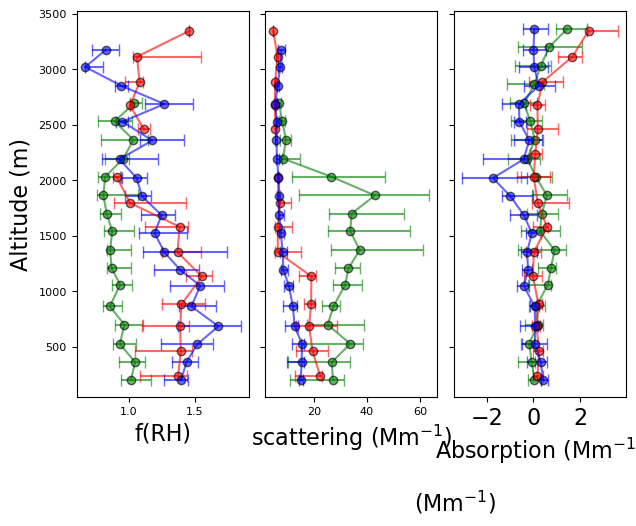

In [141]:
fig, ax = plt.subplots(1, 3, sharey='all')
ax[0].errorbar(Caribbean_transport_median['fRH550_RH20to80_ZIEMBA'], Caribbean_transport_median['GPS_Altitude_THORNHILL'], xerr=[Caribbean_transport_25['fRH550_RH20to80_ZIEMBA'], Caribbean_transport_75['fRH550_RH20to80_ZIEMBA']], marker='o', markeredgecolor = 'black', linestyle='-', capsize=4, alpha=.6, color="green", label = 'Caribbean')
ax[0].errorbar(North_America_transport_median['fRH550_RH20to80_ZIEMBA'], North_America_transport_median['GPS_Altitude_THORNHILL'], xerr=[North_America_transport_25['fRH550_RH20to80_ZIEMBA'], North_America_transport_75['fRH550_RH20to80_ZIEMBA']], marker='o', markeredgecolor = 'black', linestyle='-', capsize=4, alpha=.6, color="red", label = 'North America')
ax[0].errorbar(ocean_transport_median['fRH550_RH20to80_ZIEMBA'], ocean_transport_median['GPS_Altitude_THORNHILL'], xerr=[ocean_transport_25['fRH550_RH20to80_ZIEMBA'], ocean_transport_75['fRH550_RH20to80_ZIEMBA']], marker='o', markeredgecolor = 'black', linestyle='-', capsize=4, alpha=.6, color="blue", label = 'ocean')
ax[1].errorbar(Caribbean_transport_median['Sc550_submicron_amb_ZIEMBA'], Caribbean_transport_median['GPS_Altitude_THORNHILL'], xerr=[Caribbean_transport_25['Sc550_submicron_amb_ZIEMBA'], Caribbean_transport_75['Sc550_submicron_amb_ZIEMBA']], marker='o', markeredgecolor = 'black', linestyle='-', capsize=4, alpha=.6, color="green", label = 'Caribbean')
ax[1].errorbar(North_America_transport_median['Sc550_submicron_amb_ZIEMBA'], North_America_transport_median['GPS_Altitude_THORNHILL'], xerr=[North_America_transport_25['Sc550_submicron_amb_ZIEMBA'], North_America_transport_75['Sc550_submicron_amb_ZIEMBA']], marker='o', markeredgecolor = 'black', linestyle='-', capsize=4, alpha=.6, color="red", label = 'North America')
ax[1].errorbar(ocean_transport_median['Sc550_submicron_amb_ZIEMBA'], ocean_transport_median['GPS_Altitude_THORNHILL'], xerr=[ocean_transport_25['Sc550_submicron_amb_ZIEMBA'], ocean_transport_75['Sc550_submicron_amb_ZIEMBA']], marker='o', markeredgecolor = 'black', linestyle='-', capsize=4, alpha=.6, color="blue", label = 'Ocean')
ax[2].errorbar(Caribbean_transport_median['Abs532_total_ZIEMBA'], Caribbean_transport_median['GPS_Altitude_THORNHILL'], xerr=[Caribbean_transport_25['Abs532_total_ZIEMBA'], Caribbean_transport_75['Abs532_total_ZIEMBA']], marker='o', markeredgecolor = 'black', linestyle='-', capsize=4, alpha=.6, color="green", label = 'Caribbean')
ax[2].errorbar(North_America_transport_median['Abs532_total_ZIEMBA'], North_America_transport_median['GPS_Altitude_THORNHILL'], xerr=[North_America_transport_25['Abs532_total_ZIEMBA'], North_America_transport_75['Abs532_total_ZIEMBA']], marker='o', markeredgecolor = 'black', linestyle='-', capsize=4, alpha=.6, color="red", label = 'North America')
ax[2].errorbar(ocean_transport_median['Abs532_total_ZIEMBA'], ocean_transport_median['GPS_Altitude_THORNHILL'], xerr=[ocean_transport_25['Abs532_total_ZIEMBA'], ocean_transport_75['Abs532_total_ZIEMBA']], marker='o', markeredgecolor = 'black', linestyle='-', capsize=4, alpha=.6, color="blue", label = 'Ocean')
ax[0].set_xlabel('f(RH)', fontsize = 16)
ax[0].set_ylabel('Altitude (m)', fontsize = 16)
ax[1].set_xlabel('scattering (Mm$^{-1})$', fontsize = 16)
ax[2].set_xlabel('Absorption (Mm$^{-1}$)', fontsize = 16)
plt.xticks(fontsize=16)  # Set tick label size for x-axis
plt.yticks(fontsize=16)  # Set tick label size for y-axis
fig.text(0.65, -0.08, '(Mm$^{-1})$', ha='left', va='bottom', fontsize=16)
plt.tight_layout()

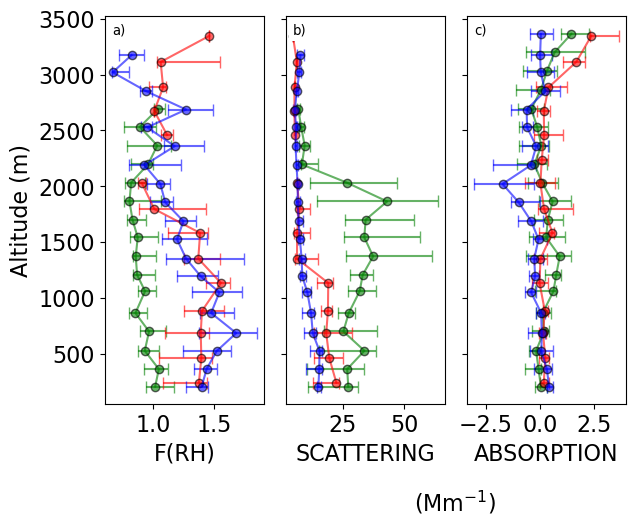

In [148]:
from matplotlib.transforms import ScaledTranslation
import matplotlib.ticker as ticker
fig, ax = plt.subplots(1, 3, sharey='all')
ax[0].errorbar(Caribbean_transport_median['fRH550_RH20to80_ZIEMBA'], Caribbean_transport_median['GPS_Altitude_THORNHILL'], xerr=[Caribbean_transport_25['fRH550_RH20to80_ZIEMBA'], Caribbean_transport_75['fRH550_RH20to80_ZIEMBA']], marker='o', markeredgecolor = 'black', linestyle='-', capsize=4, alpha=.6, color="green", label = 'Caribbean/North Africa')
ax[0].errorbar(North_America_transport_median['fRH550_RH20to80_ZIEMBA'], North_America_transport_median['GPS_Altitude_THORNHILL'], xerr=[North_America_transport_25['fRH550_RH20to80_ZIEMBA'], North_America_transport_75['fRH550_RH20to80_ZIEMBA']], marker='o', markeredgecolor = 'black', linestyle='-', capsize=4, alpha=.6, color="red", label = 'North America')
ax[0].errorbar(ocean_transport_median['fRH550_RH20to80_ZIEMBA'], ocean_transport_median['GPS_Altitude_THORNHILL'], xerr=[ocean_transport_25['fRH550_RH20to80_ZIEMBA'], ocean_transport_75['fRH550_RH20to80_ZIEMBA']], marker='o', markeredgecolor = 'black', linestyle='-', capsize=4, alpha=.6, color="blue", label = 'ocean')
ax[1].errorbar(Caribbean_transport_median['Sc550_submicron_amb_ZIEMBA'], Caribbean_transport_median['GPS_Altitude_THORNHILL'], xerr=[Caribbean_transport_25['Sc550_submicron_amb_ZIEMBA'], Caribbean_transport_75['Sc550_submicron_amb_ZIEMBA']], marker='o', markeredgecolor = 'black', linestyle='-', capsize=4, alpha=.6, color="green", label = 'Caribbean')
ax[1].errorbar(North_America_transport_median['Sc550_submicron_amb_ZIEMBA'], North_America_transport_median['GPS_Altitude_THORNHILL'], xerr=[North_America_transport_25['Sc550_submicron_amb_ZIEMBA'], North_America_transport_75['Sc550_submicron_amb_ZIEMBA']], marker='o', markeredgecolor = 'black', linestyle='-', capsize=4, alpha=.6, color="red", label = 'North America')
ax[1].errorbar(ocean_transport_median['Sc550_submicron_amb_ZIEMBA'], ocean_transport_median['GPS_Altitude_THORNHILL'], xerr=[ocean_transport_25['Sc550_submicron_amb_ZIEMBA'], ocean_transport_75['Sc550_submicron_amb_ZIEMBA']], marker='o', markeredgecolor = 'black', linestyle='-', capsize=4, alpha=.6, color="blue", label = 'Ocean')
ax[2].errorbar(Caribbean_transport_median['Abs532_total_ZIEMBA'], Caribbean_transport_median['GPS_Altitude_THORNHILL'], xerr=[Caribbean_transport_25['Abs532_total_ZIEMBA'], Caribbean_transport_75['Abs532_total_ZIEMBA']], marker='o', markeredgecolor = 'black', linestyle='-', capsize=4, alpha=.6, color="green", label = 'Caribbean/North Africa')
ax[2].errorbar(North_America_transport_median['Abs532_total_ZIEMBA'], North_America_transport_median['GPS_Altitude_THORNHILL'], xerr=[North_America_transport_25['Abs532_total_ZIEMBA'], North_America_transport_75['Abs532_total_ZIEMBA']], marker='o', markeredgecolor = 'black', linestyle='-', capsize=4, alpha=.6, color="red", label = 'North America')
ax[2].errorbar(ocean_transport_median['Abs532_total_ZIEMBA'], ocean_transport_median['GPS_Altitude_THORNHILL'], xerr=[ocean_transport_25['Abs532_total_ZIEMBA'], ocean_transport_75['Abs532_total_ZIEMBA']], marker='o', markeredgecolor = 'black', linestyle='-', capsize=4, alpha=.6, color="blue", label = 'Ocean')
ax[0].set_xlabel('F(RH)', fontsize = 16)
ax[0].set_ylabel('Altitude (m)', fontsize = 16)
ax[1].set_xlabel('SCATTERING', fontsize = 16)
ax[2].set_xlabel('ABSORPTION', fontsize = 16)
ax[0].tick_params(axis='both', labelsize=16)
ax[1].tick_params(axis='both', labelsize=16)
ax[2].tick_params(axis='both', labelsize=16) # Set tick label size for x-axis
#ax[2].legend(bbox_to_anchor=(-3, 1.02, 2, 4), loc = 3, ncol = 3, fontsize='16')
fig.text(0.65, -0.08, '(Mm$^{-1})$', ha='left', va='bottom', fontsize=16)
# Add labels 'a)', 'b)', 'c)'
labels = ['a)', 'b)', 'c)']
for i in range(3):
    trans = ScaledTranslation(10 / 72, -5 / 72, fig.dpi_scale_trans)
    ax[i].text(
        -0.04, 1, labels[i],
        transform=ax[i].transAxes + trans,
        fontsize='large', verticalalignment='top',
        bbox=dict(facecolor='1', edgecolor='none', pad=3.0)
    )

# Add legends to the subplots if needed
#ax[0].legend()

# Adjust spacing between subplots
plt.tight_layout()

NameError: name 'Africa_transport_median' is not defined

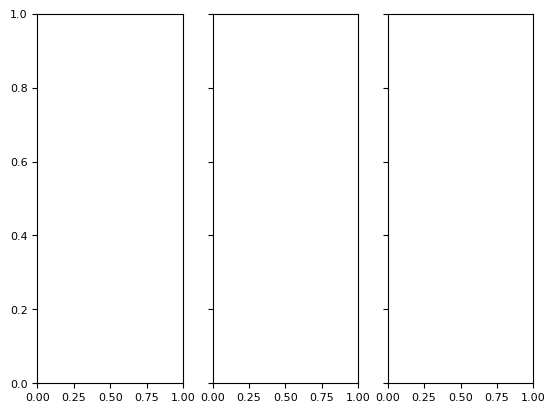

In [143]:
fig, ax = plt.subplots(1, 3, sharey='all')
ax[0].errorbar(Africa_transport_median['fRH550_RH20to80_ZIEMBA'], Africa_transport_median['GPS_Altitude_THORNHILL'], xerr=[Africa_transport_25['fRH550_RH20to80_ZIEMBA'], Africa_transport_75['fRH550_RH20to80_ZIEMBA']], marker='o', markeredgecolor = 'black', linestyle='-', capsize=4, alpha=.6, color="green", label = 'North Africa')
ax[0].errorbar(Caribbean_transport_median['fRH550_RH20to80_ZIEMBA'], Caribbean_transport_median['GPS_Altitude_THORNHILL'], xerr=[Caribbean_transport_25['fRH550_RH20to80_ZIEMBA'], Caribbean_transport_75['fRH550_RH20to80_ZIEMBA']], marker='o', markeredgecolor = 'black', linestyle='-', capsize=4, alpha=.6, color="blue", label = 'Caribbean')
ax[0].errorbar(North_America_transport_median['fRH550_RH20to80_ZIEMBA'], North_America_transport_median['GPS_Altitude_THORNHILL'], xerr=[North_America_transport_25['fRH550_RH20to80_ZIEMBA'], North_America_transport_75['fRH550_RH20to80_ZIEMBA']], marker='o', markeredgecolor = 'black', linestyle='-', capsize=4, alpha=.6, color="red", label = 'North America')
ax[0].errorbar(ocean_transport_median['fRH550_RH20to80_ZIEMBA'], ocean_transport_median['GPS_Altitude_THORNHILL'], xerr=[ocean_transport_25['fRH550_RH20to80_ZIEMBA'], ocean_transport_75['fRH550_RH20to80_ZIEMBA']], marker='o', markeredgecolor = 'black', linestyle='-', capsize=4, alpha=.6, color="grey", label = 'ocean')
ax[1].errorbar(Africa_transport_median['Sc550_submicron_amb_ZIEMBA'], Africa_transport_median['GPS_Altitude_THORNHILL'], xerr=[Africa_transport_25['Sc550_submicron_amb_ZIEMBA'], Africa_transport_75['Sc550_submicron_amb_ZIEMBA']], marker='o', markeredgecolor = 'black', linestyle='-', capsize=4, alpha=.6, color="green", label = 'North Africa')
ax[1].errorbar(Caribbean_transport_median['Sc550_submicron_amb_ZIEMBA'], Caribbean_transport_median['GPS_Altitude_THORNHILL'], xerr=[Caribbean_transport_25['Sc550_submicron_amb_ZIEMBA'], Caribbean_transport_75['Sc550_submicron_amb_ZIEMBA']], marker='o', markeredgecolor = 'black', linestyle='-', capsize=4, alpha=.6, color="blue", label = 'Caribbean')
ax[1].errorbar(North_America_transport_median['Sc550_submicron_amb_ZIEMBA'], North_America_transport_median['GPS_Altitude_THORNHILL'], xerr=[North_America_transport_25['Sc550_submicron_amb_ZIEMBA'], North_America_transport_75['Sc550_submicron_amb_ZIEMBA']], marker='o', markeredgecolor = 'black', linestyle='-', capsize=4, alpha=.6, color="red", label = 'North America')
ax[1].errorbar(ocean_transport_median['Sc550_submicron_amb_ZIEMBA'], ocean_transport_median['GPS_Altitude_THORNHILL'], xerr=[ocean_transport_25['Sc550_submicron_amb_ZIEMBA'], ocean_transport_75['Sc550_submicron_amb_ZIEMBA']], marker='o', markeredgecolor = 'black', linestyle='-', capsize=4, alpha=.6, color="grey", label = 'Ocean')
ax[2].errorbar(Africa_transport_median['Abs532_total_ZIEMBA'], Africa_transport_median['GPS_Altitude_THORNHILL'], xerr=[Africa_transport_25['Abs532_total_ZIEMBA'], Africa_transport_75['Abs532_total_ZIEMBA']], marker='o', markeredgecolor = 'black', linestyle='-', capsize=4, alpha=.6, color="green", label = 'North Africa')
ax[2].errorbar(Caribbean_transport_median['Abs532_total_ZIEMBA'], Caribbean_transport_median['GPS_Altitude_THORNHILL'], xerr=[Caribbean_transport_25['Abs532_total_ZIEMBA'], Caribbean_transport_75['Abs532_total_ZIEMBA']], marker='o', markeredgecolor = 'black', linestyle='-', capsize=4, alpha=.6, color="blue", label = 'Caribbean')
ax[2].errorbar(North_America_transport_median['Abs532_total_ZIEMBA'], North_America_transport_median['GPS_Altitude_THORNHILL'], xerr=[North_America_transport_25['Abs532_total_ZIEMBA'], North_America_transport_75['Abs532_total_ZIEMBA']], marker='o', markeredgecolor = 'black', linestyle='-', capsize=4, alpha=.6, color="red", label = 'North America')
ax[2].errorbar(ocean_transport_median['Abs532_total_ZIEMBA'], ocean_transport_median['GPS_Altitude_THORNHILL'], xerr=[ocean_transport_25['Abs532_total_ZIEMBA'], ocean_transport_75['Abs532_total_ZIEMBA']], marker='o', markeredgecolor = 'black', linestyle='-', capsize=4, alpha=.6, color="grey", label = 'Ocean')
ax[0].set_xlabel('f(RH)', fontsize = 12)
ax[0].set_ylabel('Altitude (m)', fontsize = 16)
ax[1].set_xlabel('scattering (Mm$^{-1})$', fontsize = 12)
ax[2].set_xlabel('Absorption (Mm$^{-1}$)', fontsize = 12)
plt.xticks(fontsize=12)  # Set tick label size for x-axis
plt.yticks(fontsize=12)  # Set tick label size for y-axis
#ax[1].legend()

In [ ]:
# Concatenate the dataframes vertically (along rows)
'''merged_df = pd.concat([Caribbean.describe(), Caribbean2.describe(), North_America.describe(), North_America2.describe(), ocean.describe(), ocean2.describe(), Africa.describe(), DAY14_subset_3000.describe()], axis=0)

# Reset the index of the merged dataframe
merged_df.reset_index(drop=False, inplace=True)

# Display the merged dataframe
merged_df
merged_df.to_csv('C:/Users/taiwoajayi/OneDrive - University of Arizona/python/hygro.csv')'''

"merged_df = pd.concat([Caribbean.describe(), Caribbean2.describe(), North_America.describe(), North_America2.describe(), ocean.describe(), ocean2.describe(), Africa.describe(), DAY14_subset_3000.describe()], axis=0)\n\n# Reset the index of the merged dataframe\nmerged_df.reset_index(drop=False, inplace=True)\n\n# Display the merged dataframe\nmerged_df\nmerged_df.to_csv('C:/Users/taiwoajayi/OneDrive - University of Arizona/python/hygro.csv')"